In [145]:
# an attempt to learn an effective 'trading' policy on a sine curve
# SineTrader sees a 400-point sine curve as windows of 32 points
# tries to make effective hold, buy, sell decisions
# train a DQN, pick a 'good' one and visualize where it trades
# max is +58% with rewards of about 7.35, I've seen 6.3 in some of my experiments

# rewards:
# 0.5x incremental reward for holding a good position per step
#  -1x reward for holding a bad position per step
# -2 for holding in the last step (we want to agent to balance buy/sell)
# rewarded total if positive at the last step
# stop loss - if more than 5% lost then cut run short

# state:
# window of 32 'prices'
# current price
# some measures of 'cash' held and goodness of current position, and percentage (3)
# overall sense of time of day, i.e. step 0 = 0.0, last step = 1.0
# ending ramp for last 15 steps (informative of upcoming end of day / need to sell out)

This example is after 100K epochs with a reward of 5.33
- green triangle are buys (best to be low)
- red triangles are sells (best to be high)
- the optimal strategy would also buy immediately at the start
- and sell at the end thus taking advantage of the partial cycles

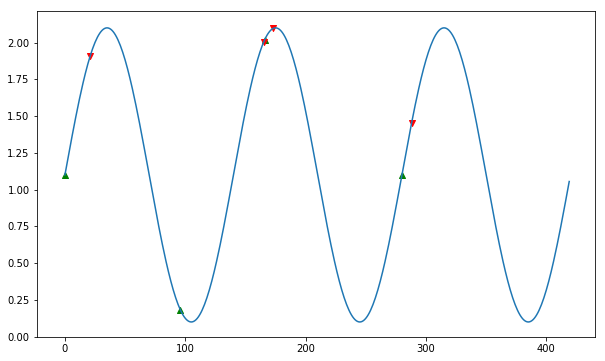

In [95]:
%matplotlib inline
import matplotlib.pyplot as plt
import gym
from gym import spaces
import inspect
import os.path as path
import math
import os
import sys
import numpy as np
import datetime
import random
import pickle
from math import pi as PI
import math
from pprint import pprint
import importlib
from collections import defaultdict
import datetime

from keras.models import Sequential
from keras.layers import *
from keras.callbacks import Callback
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

from rl.agents.dqn import DQNAgent
from rl.policy import *
from rl.memory import SequentialMemory

# from model import chosen_model
# import viz
import optuna

np.set_printoptions(formatter={'float': lambda x: "{0:.3f}".format(x)})

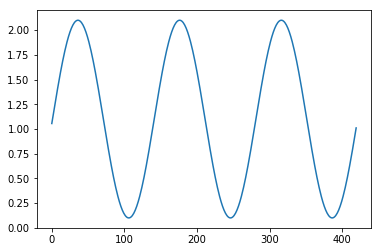

In [96]:
# viz data of the environment - input
# +31 because the first 'price' we see is actually the 31st datum. 
plt.plot(env.data[31:len(env.data)//2+31])

In [97]:
## params

WINDOW_SIZE = 32
N_DISCRETE_ACTIONS = 3 # hold, buy, sell
MAX_ACCOUNT_BALANCE = 100
FEE = 0.01
STOP_LOSS_PERCENT = 5.0

In [98]:
class SineTrader(gym.Env):
  """Custom Environment that follows gym interface"""
  metadata = {'render.modes': ['human']}

  def __init__(self, phase_offset=None, freq=3, verbose=False):
    super(SineTrader, self).__init__()
    self.phase_offset = phase_offset
    self.freq = freq
    self.verbose = verbose

    self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
    self.observation_space = spaces.Box(low=-10, high=10, shape=(1, 32), dtype=np.float32)
    self.reward_range = (-MAX_ACCOUNT_BALANCE, MAX_ACCOUNT_BALANCE)

  def random_phase(self):
    return random.random() * 2 * PI

  def reset(self, starting_cash=10.0, phase_offset=None, index=None):
    self.phase_offset = 0.0
    # self.phase_offset = phase_offset or self.random_phase()
    K = 420
    self.data = [math.sin((2.0*PI)*((a+K-32)/K*self.freq+self.phase_offset)) for a in range(K)]
    self.L = len(self.data)
    self.data = np.array(self.data + self.data) + 1.1

    self.index = 0
    # self.index = index or random.randint(0, self.L-WINDOW_SIZE-1)
    self.start_index = self.index

    self.f = 1.0 / (self.L - self.index)
    self.n_steps = 0
    self.viz = None
    self.trade = None
    self.trades = []

    self.starting_cash = starting_cash
    self.cash = self.starting_cash
    self.t_price = None
    self.prev_position = self.starting_cash

    if self.verbose:
      print('\nRESET:', self.phase_offset, self.index)

    return self._next_observation()

  def _next_observation(self):
    """[data_window, self-state]"""
    # extract the min-1 window from current sample
    w = self.data[self.index:self.index+WINDOW_SIZE].reshape(1, -1)
    # make this 1x6
    s = self.state.reshape(1, -1)
    # print(w.shape, s.shape)
    obs = np.concatenate([w, s])
    # return obs.reshape(-1, 1)
    return obs

  @property
  def state(self):
    near_end = max(self.index-(self.L-15-1), 0)/15.0
    s = np.array([
      self.cash / self.starting_cash,
      (self.cost_basis or 0.0) / self.starting_cash,
      self.gain_loss_percent,
      self.index / self.L,
      near_end,
      self.t_price or 0.0
    ])
    return np.pad(s, (0,32-len(s)), mode='constant')

  @property
  def holding(self):
    return self.t_price is not None

  @property
  def current_value(self):
    return self.price

  @property
  def cost(self):
    """what we bought the shares for w/o fees"""
    return self.t_price if self.t_price else 0.0

  @property
  def cost_basis(self):
    return self.t_price + FEE if self.holding else 0.0

  @property
  def price(self):
    v = self.data[self.index:self.index+WINDOW_SIZE][-1]
    return v

  @property
  def display_price(self):
    return self.price

  @property
  def gain_loss(self):
    """gain/loss of current open positions whether long or short"""
    if self.t_price is None:
      return 0
    else:
      return (self.price - self.t_price)
    # elif self.n_shares > 0:
    #   return self.n_shares * (self.price - self.t_price)
    # else:
    #   return self.n_shares * (self.t_price - self.price)

  @property
  def position(self):
    """cash + gain/loss"""
    return self.cash + self.cost + self.gain_loss

  @property
  def gain_loss_percent(self):
    return (100.0 * self.position / self.starting_cash) - 100.0

  @property
  def total(self):
    """difference from starting position"""
    return self.position - self.starting_cash

  def step(self, action):
    # Execute one time step within the environment
    self.n_steps += 1

    self.trade = None
    self.delta = 0
    self._take_action(action)

    self.index += 1

    # stop at the end of sequence
    self.done = done = self.index >= self.L-1
    # self.over = over = self.index >= self.L-2

    if done:
      if self.holding:
        self.reward = -2
      else:
        self.reward = self.total
    else:
      # some reward for holding a good position
      # negative hurt twice as much
      if self.total > 0.0:
        self.reward = (self.total / self.L) * 0.5
      else:
        self.reward = (self.total / self.L)

    if self.gain_loss_percent < (-STOP_LOSS_PERCENT):
      self.close_position()
      done = True

    obs = self._next_observation()

    self.prev_position = self.position

    return obs, self.reward, done, {}

  def _take_action(self, action):
    self.taken = '_'
    if action == 0: # hold
      self.taken = 'h'
      return
    elif action == 1: # buy
      if not self.holding:
        self.buy_long()
    elif action == 2: # sell
      if self.holding:
        self.sell_long()
    else:
      raise Exception("unknown action", action)

  def buy_long(self):
    self.t_price = self.price
    cost = self.price + FEE
    self.cash -= cost
    self.trade = {
      'step': self.index,
      'time': self.index,
      'type': 'buy',
      'subtype': 'buy-long',
      'price': self.t_price,
      'cost': cost,
    }
    self.trades.append(self.trade)
    self.taken = 'B'

  def sell_long(self):
    self.delta = (self.price - self.t_price) - FEE
    sale = self.price - FEE
    self.trade = {
      'step': self.index,
      'time': self.index,
      'type': 'sell',
      'subtype': 'sell-long',
      'price': self.price,
      'cost': FEE,
      'delta': self.delta,
      'proceeds': sale
    }
    self.trades.append(self.trade)
    self.cash += sale
    self.n_shares = 0
    self.t_price = None
    self.taken = 'S'

  def sell_short(self):
    pass

  def cover_short(self):
    pass

  def close_position(self):
    if self.holding:
      self.sell_long()

  def render(self, mode='human', close=False):
    return self._render_ansi()

  def _render_ansi(self, mode='human', close=False):
    # Render the environment to the screen
    print('d: {} a:{:s} r:{:02.2f} s:{:3d} $:{:0.2f} h:{:2d} gl:{:+02.3f}% #t:{:2d} p:{:+02.3f}' \
      .format(self.done, self.taken, self.reward, self.n_steps, self.cash, int(self.holding), self.gain_loss_percent, len(self.trades), self.price))


def test_nomodel():
    env = SineTrader()
    obs = env.reset()
    # explore maximum reward (manually)
    # nb: current price is end of window which is 32 steps ahead of the index
    # optimal trades: +58.306% (check last line)
    total_rewards = 0.0
    for i in range(env.L):
        if i in [0, 106, 246, 386]:
            a = 1
        elif i in [36, 176, 316, 418]: # last one is end reqd
            a = 2
        else:
            a = 0
        _, reward, done, _ = env.step(a)
        total_rewards += reward
        print('i: {:03d} a:{:d}{} r:{:+02.2f}'.format(i, a, env.taken, reward), end=' ')
        env.render()
        if done:
          print('done @ {} total_rewards: {}'.format(i, total_rewards))
          break

test_nomodel()

i: 000 a:1B r:+0.00 d: False a:B r:0.00 s:  1 $:8.93 h: 1 gl:+0.349% #t: 1 p:+1.100
i: 001 a:0h r:+0.00 d: False a:h r:0.00 s:  2 $:8.93 h: 1 gl:+0.797% #t: 1 p:+1.145
i: 002 a:0h r:+0.00 d: False a:h r:0.00 s:  3 $:8.93 h: 1 gl:+1.245% #t: 1 p:+1.190
i: 003 a:0h r:+0.00 d: False a:h r:0.00 s:  4 $:8.93 h: 1 gl:+1.691% #t: 1 p:+1.234
i: 004 a:0h r:+0.00 d: False a:h r:0.00 s:  5 $:8.93 h: 1 gl:+2.134% #t: 1 p:+1.279
i: 005 a:0h r:+0.00 d: False a:h r:0.00 s:  6 $:8.93 h: 1 gl:+2.574% #t: 1 p:+1.323
i: 006 a:0h r:+0.00 d: False a:h r:0.00 s:  7 $:8.93 h: 1 gl:+3.009% #t: 1 p:+1.366
i: 007 a:0h r:+0.00 d: False a:h r:0.00 s:  8 $:8.93 h: 1 gl:+3.439% #t: 1 p:+1.409
i: 008 a:0h r:+0.00 d: False a:h r:0.00 s:  9 $:8.93 h: 1 gl:+3.862% #t: 1 p:+1.451
i: 009 a:0h r:+0.00 d: False a:h r:0.00 s: 10 $:8.93 h: 1 gl:+4.279% #t: 1 p:+1.493
i: 010 a:0h r:+0.00 d: False a:h r:0.00 s: 11 $:8.93 h: 1 gl:+4.687% #t: 1 p:+1.534
i: 011 a:0h r:+0.00 d: False a:h r:0.00 s: 12 $:8.93 h: 1 gl:+5.087% #t: 1 p

i: 096 a:0h r:+0.00 d: False a:h r:0.00 s: 97 $:11.02 h: 0 gl:+10.249% #t: 2 p:+0.180
i: 097 a:0h r:+0.00 d: False a:h r:0.00 s: 98 $:11.02 h: 0 gl:+10.249% #t: 2 p:+0.164
i: 098 a:0h r:+0.00 d: False a:h r:0.00 s: 99 $:11.02 h: 0 gl:+10.249% #t: 2 p:+0.149
i: 099 a:0h r:+0.00 d: False a:h r:0.00 s:100 $:11.02 h: 0 gl:+10.249% #t: 2 p:+0.136
i: 100 a:0h r:+0.00 d: False a:h r:0.00 s:101 $:11.02 h: 0 gl:+10.249% #t: 2 p:+0.125
i: 101 a:0h r:+0.00 d: False a:h r:0.00 s:102 $:11.02 h: 0 gl:+10.249% #t: 2 p:+0.116
i: 102 a:0h r:+0.00 d: False a:h r:0.00 s:103 $:11.02 h: 0 gl:+10.249% #t: 2 p:+0.109
i: 103 a:0h r:+0.00 d: False a:h r:0.00 s:104 $:11.02 h: 0 gl:+10.249% #t: 2 p:+0.104
i: 104 a:0h r:+0.00 d: False a:h r:0.00 s:105 $:11.02 h: 0 gl:+10.249% #t: 2 p:+0.101
i: 105 a:0h r:+0.00 d: False a:h r:0.00 s:106 $:11.02 h: 0 gl:+10.249% #t: 2 p:+0.100
i: 106 a:1B r:+0.00 d: False a:B r:0.00 s:107 $:10.91 h: 1 gl:+10.159% #t: 3 p:+0.101
i: 107 a:0h r:+0.00 d: False a:h r:0.00 s:108 $:10.91 

i: 191 a:0h r:+0.00 d: False a:h r:0.00 s:192 $:13.00 h: 0 gl:+30.049% #t: 4 p:+1.853
i: 192 a:0h r:+0.00 d: False a:h r:0.00 s:193 $:13.00 h: 0 gl:+30.049% #t: 4 p:+1.823
i: 193 a:0h r:+0.00 d: False a:h r:0.00 s:194 $:13.00 h: 0 gl:+30.049% #t: 4 p:+1.791
i: 194 a:0h r:+0.00 d: False a:h r:0.00 s:195 $:13.00 h: 0 gl:+30.049% #t: 4 p:+1.758
i: 195 a:0h r:+0.00 d: False a:h r:0.00 s:196 $:13.00 h: 0 gl:+30.049% #t: 4 p:+1.723
i: 196 a:0h r:+0.00 d: False a:h r:0.00 s:197 $:13.00 h: 0 gl:+30.049% #t: 4 p:+1.688
i: 197 a:0h r:+0.00 d: False a:h r:0.00 s:198 $:13.00 h: 0 gl:+30.049% #t: 4 p:+1.651
i: 198 a:0h r:+0.00 d: False a:h r:0.00 s:199 $:13.00 h: 0 gl:+30.049% #t: 4 p:+1.613
i: 199 a:0h r:+0.00 d: False a:h r:0.00 s:200 $:13.00 h: 0 gl:+30.049% #t: 4 p:+1.574
i: 200 a:0h r:+0.00 d: False a:h r:0.00 s:201 $:13.00 h: 0 gl:+30.049% #t: 4 p:+1.534
i: 201 a:0h r:+0.00 d: False a:h r:0.00 s:202 $:13.00 h: 0 gl:+30.049% #t: 4 p:+1.493
i: 202 a:0h r:+0.00 d: False a:h r:0.00 s:203 $:13.00 

i: 286 a:0h r:+0.01 d: False a:h r:0.01 s:287 $:12.89 h: 1 gl:+42.609% #t: 5 p:+1.366
i: 287 a:0h r:+0.01 d: False a:h r:0.01 s:288 $:12.89 h: 1 gl:+43.039% #t: 5 p:+1.409
i: 288 a:0h r:+0.01 d: False a:h r:0.01 s:289 $:12.89 h: 1 gl:+43.462% #t: 5 p:+1.451
i: 289 a:0h r:+0.01 d: False a:h r:0.01 s:290 $:12.89 h: 1 gl:+43.879% #t: 5 p:+1.493
i: 290 a:0h r:+0.01 d: False a:h r:0.01 s:291 $:12.89 h: 1 gl:+44.287% #t: 5 p:+1.534
i: 291 a:0h r:+0.01 d: False a:h r:0.01 s:292 $:12.89 h: 1 gl:+44.687% #t: 5 p:+1.574
i: 292 a:0h r:+0.01 d: False a:h r:0.01 s:293 $:12.89 h: 1 gl:+45.078% #t: 5 p:+1.613
i: 293 a:0h r:+0.01 d: False a:h r:0.01 s:294 $:12.89 h: 1 gl:+45.458% #t: 5 p:+1.651
i: 294 a:0h r:+0.01 d: False a:h r:0.01 s:295 $:12.89 h: 1 gl:+45.827% #t: 5 p:+1.688
i: 295 a:0h r:+0.01 d: False a:h r:0.01 s:296 $:12.89 h: 1 gl:+46.184% #t: 5 p:+1.723
i: 296 a:0h r:+0.01 d: False a:h r:0.01 s:297 $:12.89 h: 1 gl:+46.528% #t: 5 p:+1.758
i: 297 a:0h r:+0.01 d: False a:h r:0.01 s:298 $:12.89 

i: 381 a:0h r:+0.01 d: False a:h r:0.01 s:382 $:14.98 h: 0 gl:+49.849% #t: 6 p:+0.116
i: 382 a:0h r:+0.01 d: False a:h r:0.01 s:383 $:14.98 h: 0 gl:+49.849% #t: 6 p:+0.109
i: 383 a:0h r:+0.01 d: False a:h r:0.01 s:384 $:14.98 h: 0 gl:+49.849% #t: 6 p:+0.104
i: 384 a:0h r:+0.01 d: False a:h r:0.01 s:385 $:14.98 h: 0 gl:+49.849% #t: 6 p:+0.101
i: 385 a:0h r:+0.01 d: False a:h r:0.01 s:386 $:14.98 h: 0 gl:+49.849% #t: 6 p:+0.100
i: 386 a:1B r:+0.01 d: False a:B r:0.01 s:387 $:14.87 h: 1 gl:+49.759% #t: 7 p:+0.101
i: 387 a:0h r:+0.01 d: False a:h r:0.01 s:388 $:14.87 h: 1 gl:+49.789% #t: 7 p:+0.104
i: 388 a:0h r:+0.01 d: False a:h r:0.01 s:389 $:14.87 h: 1 gl:+49.839% #t: 7 p:+0.109
i: 389 a:0h r:+0.01 d: False a:h r:0.01 s:390 $:14.87 h: 1 gl:+49.909% #t: 7 p:+0.116
i: 390 a:0h r:+0.01 d: False a:h r:0.01 s:391 $:14.87 h: 1 gl:+49.999% #t: 7 p:+0.125
i: 391 a:0h r:+0.01 d: False a:h r:0.01 s:392 $:14.87 h: 1 gl:+50.109% #t: 7 p:+0.136
i: 392 a:0h r:+0.01 d: False a:h r:0.01 s:393 $:14.87 

In [99]:
class DeeperModel(object):
  def build_model(self, n, d, nb_actions):
    model = Sequential()
    model.add(Flatten(input_shape=(1,) + (n+1, d)))
    model.add(Dense(10))
    model.add(LeakyReLU(alpha=0.03))
    model.add(Dense(5))
    model.add(LeakyReLU(alpha=0.03))
    model.add(Dense(5))
    model.add(LeakyReLU(alpha=0.03))
    model.add(Dense(5))
    model.add(LeakyReLU(alpha=0.03))
    model.add(Dense(nb_actions, activation='sigmoid'))
    model.add(Activation('linear'))
    return model    

  def compile_model(self, model):
    model.compile(optimizer=Adam(lr=0.001), metrics=['accuracy'])
    return model    

chosen_model = DeeperModel

model = DeeperModel().build_model(20, 4, 3)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_17 (Flatten)         (None, 84)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 10)                850       
_________________________________________________________________
leaky_re_lu_57 (LeakyReLU)   (None, 10)                0         
_________________________________________________________________
dense_74 (Dense)             (None, 5)                 55        
_________________________________________________________________
leaky_re_lu_58 (LeakyReLU)   (None, 5)                 0         
_________________________________________________________________
dense_75 (Dense)             (None, 5)                 30        
_________________________________________________________________
leaky_re_lu_59 (LeakyReLU)   (None, 5)                 0         
__________

In [100]:
class TrainingCallback(Callback):
  def __init__(self, saving=False, run_name='a_run'):
    self.saving = saving
    self.run_name = run_name

    self.metrics = {}
    self.best_metrics = defaultdict(float)

  def track(self, metric_name, value):
    self.metrics[metric_name] = value
    best_so_far = self.best_metrics[metric_name]
    if value > best_so_far:
      self.best_metrics[metric_name] = value
      if self.saving:
        fp = 'models/{}/weights_{:.2f}.h5f'.format(self.run_name, value)
        self.model.save_weights(fp, overwrite=True)

  def show_metrics(self):
    print()
    for key, value in self.metrics.items():
      print(key, value, 'best:', self.best_metrics[key])

  def on_episode_end(self, episode, logs):
    self.track('episode_reward', logs['episode_reward'])
    self.show_metrics()

In [125]:
run_name = datetime.datetime.now().strftime("run-%Y.%m.%d.%H.%M.%S")

ENV_NAME = chosen_model.__name__
env = SineTrader()

tb = TensorBoard(log_dir='./log/{}'.format(run_name))
os.makedirs('models/{}'.format(run_name), exist_ok=True)

K = 100000

def build_agent(env, K):
    nb_actions = env.action_space.n
    n, d = env.observation_space.shape
    model = chosen_model().build_model(n, d, nb_actions)

    memory = SequentialMemory(limit=K, window_length=1)

    policy = MaxBoltzmannQPolicy(eps=0.05, tau=0.8)

    dqn = DQNAgent(model=model,
                 nb_actions=nb_actions,
                 memory=memory,
                 nb_steps_warmup=1000,
                 target_model_update=1e-3,
                 policy=policy)
    dqn = chosen_model().compile_model(dqn)
    return dqn

dqn = build_agent(env, K)
callbacks = [TrainingCallback(), tb]
tcb = TrainingCallback(saving=True, run_name=run_name)
perf = dqn.fit(env, nb_steps=K, visualize=False, verbose=1, callbacks=[tcb, tb])

Training for 100000 steps ...
Interval 1 (0 steps performed)
  348/10000 [>.............................] - ETA: 3:32:22 - reward: 0.0000e+ - ETA: 11:10 - reward: 0.0000e+00 - ETA: 4:43 - reward: 0.0000e+00 - ETA: 3:44 - reward: 0.0000e+0 - ETA: 3:15 - reward: 0.0000e+0 - ETA: 2:52 - reward: 0.0000e+0 - ETA: 2:39 - reward: 0.0000e+0 - ETA: 2:33 - reward: 0.0000e+0 - ETA: 2:15 - reward: 0.0000e+0 - ETA: 1:59 - reward: 0.0000e+0 - ETA: 1:48 - reward: 0.0000e+0 - ETA: 1:41 - reward: 0.0000e+0 - ETA: 1:28 - reward: 0.0000e+0 - ETA: 1:19 - reward: 0.0000e+0 - ETA: 1:13 - reward: 0.0000e+0 - ETA: 1:11 - reward: 0.0000e+0 - ETA: 1:06 - reward: 2.3489e-0 - ETA: 1:03 - reward: 5.6038e-0 - ETA: 1:01 - reward: 4.7161e-05
episode_reward 0.013039261256597568 best: 0.013039261256597568
  419/10000 [>.............................] - ETA: 1:26 - reward: 3.7043e-0 - ETA: 1:23 - reward: 3.5529e-0 - ETA: 1:22 - reward: 3.4404e-0 - ETA: 1:22 - reward: 3.3780e-0 - ETA: 1:23 - reward: 3.3693e-0 - ETA: 1:22 

 1573/10000 [===>..........................] - ETA: 1:57 - reward: -5.0417e- - ETA: 1:57 - reward: -5.0267e- - ETA: 1:57 - reward: -5.0119e- - ETA: 1:57 - reward: -4.9935e- - ETA: 1:57 - reward: -4.9898e- - ETA: 1:57 - reward: -4.9752e- - ETA: 1:57 - reward: -4.9570e- - ETA: 1:57 - reward: -4.9426e- - ETA: 1:57 - reward: -4.9318e- - ETA: 1:57 - reward: -4.9175e- - ETA: 1:57 - reward: -4.9104e- - ETA: 1:57 - reward: -4.9087e- - ETA: 1:57 - reward: -4.9138e- - ETA: 1:57 - reward: -4.9188e- - ETA: 1:57 - reward: -4.9239e- - ETA: 1:57 - reward: -4.9264e- - ETA: 1:57 - reward: -4.9326e- - ETA: 1:57 - reward: -4.9351e- - ETA: 1:57 - reward: -4.9376e- - ETA: 1:57 - reward: -4.9400e- - ETA: 1:57 - reward: -4.9449e- - ETA: 1:57 - reward: -4.9510e- - ETA: 1:57 - reward: -4.9547e- - ETA: 1:57 - reward: -4.9595e- - ETA: 1:57 - reward: -4.9655e- - ETA: 1:57 - reward: -4.9715e- - ETA: 1:57 - reward: -4.9727e- - ETA: 1:57 - reward: -4.9750e- - ETA: 1:57 - reward: -4.9786e- - ETA: 1:57 - reward: -4.98

 2410/10000 [======>.......................] - ETA: 1:54 - reward: 9.5008e-0 - ETA: 1:54 - reward: 9.4912e-0 - ETA: 1:54 - reward: 9.4770e-0 - ETA: 1:54 - reward: 9.4675e-0 - ETA: 1:54 - reward: 9.4628e-0 - ETA: 1:54 - reward: 9.4533e-0 - ETA: 1:54 - reward: 9.4392e-0 - ETA: 1:54 - reward: 9.4251e-0 - ETA: 1:54 - reward: 9.4157e-0 - ETA: 1:54 - reward: 9.3970e-0 - ETA: 1:54 - reward: 9.3738e-0 - ETA: 1:54 - reward: 9.3553e-0 - ETA: 1:54 - reward: 9.3322e-0 - ETA: 1:54 - reward: 9.3182e-0 - ETA: 1:54 - reward: 9.2978e-0 - ETA: 1:54 - reward: 9.2612e-0 - ETA: 1:54 - reward: 9.2467e-0 - ETA: 1:54 - reward: 9.2153e-0 - ETA: 1:54 - reward: 9.1840e-0 - ETA: 1:54 - reward: 9.1606e-0 - ETA: 1:54 - reward: 9.1450e-0 - ETA: 1:54 - reward: 9.1294e-0 - ETA: 1:54 - reward: 9.1217e-0 - ETA: 1:54 - reward: 9.1055e-0 - ETA: 1:54 - reward: 9.0970e-0 - ETA: 1:55 - reward: 9.0886e-0 - ETA: 1:56 - reward: 9.0801e-0 - ETA: 1:56 - reward: 9.0716e-0 - ETA: 1:56 - reward: 9.0632e-0 - ETA: 1:57 - reward: 9.054

 3247/10000 [========>.....................] - ETA: 1:47 - reward: 2.2736e-0 - ETA: 1:47 - reward: 2.2720e-0 - ETA: 1:47 - reward: 2.2696e-0 - ETA: 1:47 - reward: 2.2664e-0 - ETA: 1:47 - reward: 2.2640e-0 - ETA: 1:47 - reward: 2.2608e-0 - ETA: 1:47 - reward: 2.2584e-0 - ETA: 1:46 - reward: 2.2553e-0 - ETA: 1:46 - reward: 2.2521e-0 - ETA: 1:46 - reward: 2.2498e-0 - ETA: 1:46 - reward: 2.2466e-0 - ETA: 1:47 - reward: 2.2458e-0 - ETA: 1:47 - reward: 2.2435e-0 - ETA: 1:46 - reward: 2.2404e-0 - ETA: 1:46 - reward: 2.2365e-0 - ETA: 1:46 - reward: 2.2326e-0 - ETA: 1:46 - reward: 2.2303e-0 - ETA: 1:46 - reward: 2.2279e-0 - ETA: 1:46 - reward: 2.2231e-0 - ETA: 1:46 - reward: 2.2171e-0 - ETA: 1:46 - reward: 2.2135e-0 - ETA: 1:46 - reward: 2.2076e-0 - ETA: 1:46 - reward: 2.2041e-0 - ETA: 1:46 - reward: 2.2017e-0 - ETA: 1:46 - reward: 2.2005e-0 - ETA: 1:46 - reward: 2.1982e-0 - ETA: 1:46 - reward: 2.1946e-0 - ETA: 1:46 - reward: 2.1888e-0 - ETA: 1:46 - reward: 2.1841e-0 - ETA: 1:46 - reward: 2.179

 4085/10000 [===========>..................] - ETA: 1:33 - reward: 1.4624e-0 - ETA: 1:33 - reward: 1.4612e-0 - ETA: 1:33 - reward: 1.4596e-0 - ETA: 1:33 - reward: 1.4584e-0 - ETA: 1:33 - reward: 1.4573e-0 - ETA: 1:33 - reward: 1.4561e-0 - ETA: 1:33 - reward: 1.4545e-0 - ETA: 1:33 - reward: 1.4529e-0 - ETA: 1:33 - reward: 1.4513e-0 - ETA: 1:33 - reward: 1.4498e-0 - ETA: 1:32 - reward: 1.4474e-0 - ETA: 1:32 - reward: 1.4447e-0 - ETA: 1:32 - reward: 1.4419e-0 - ETA: 1:32 - reward: 1.4343e-0 - ETA: 1:32 - reward: 1.4255e-0 - ETA: 1:32 - reward: 1.4166e-0 - ETA: 1:32 - reward: 1.4077e-0 - ETA: 1:32 - reward: 1.3989e-0 - ETA: 1:32 - reward: 1.3884e-0 - ETA: 1:31 - reward: 1.3814e-0 - ETA: 1:31 - reward: 1.3744e-0 - ETA: 1:31 - reward: 1.3644e-0 - ETA: 1:31 - reward: 1.3602e-0 - ETA: 1:31 - reward: 1.3582e-0 - ETA: 1:31 - reward: 1.3499e-0 - ETA: 1:31 - reward: 1.3437e-0 - ETA: 1:31 - reward: 1.3314e-0 - ETA: 1:31 - reward: 1.3190e-0 - ETA: 1:31 - reward: 1.3106e-0 - ETA: 1:31 - reward: 1.300

 4923/10000 [=============>................] - ETA: 1:20 - reward: 4.9736e-0 - ETA: 1:20 - reward: 4.9692e-0 - ETA: 1:20 - reward: 4.9626e-0 - ETA: 1:20 - reward: 4.9560e-0 - ETA: 1:19 - reward: 4.9494e-0 - ETA: 1:19 - reward: 4.9450e-0 - ETA: 1:19 - reward: 4.9396e-0 - ETA: 1:19 - reward: 4.9331e-0 - ETA: 1:19 - reward: 4.9298e-0 - ETA: 1:19 - reward: 4.9244e-0 - ETA: 1:19 - reward: 4.9201e-0 - ETA: 1:19 - reward: 4.9050e-0 - ETA: 1:19 - reward: 4.8833e-0 - ETA: 1:19 - reward: 4.8462e-0 - ETA: 1:18 - reward: 4.8122e-0 - ETA: 1:18 - reward: 4.7714e-0 - ETA: 1:18 - reward: 4.7308e-0 - ETA: 1:18 - reward: 4.7038e-0 - ETA: 1:18 - reward: 4.6701e-0 - ETA: 1:18 - reward: 4.6365e-0 - ETA: 1:18 - reward: 4.6097e-0 - ETA: 1:18 - reward: 4.5896e-0 - ETA: 1:18 - reward: 4.5628e-0 - ETA: 1:18 - reward: 4.5294e-0 - ETA: 1:18 - reward: 4.5028e-0 - ETA: 1:18 - reward: 4.4695e-0 - ETA: 1:17 - reward: 4.4377e-0 - ETA: 1:17 - reward: 4.4229e-0 - ETA: 1:17 - reward: 4.4187e-0 - ETA: 1:17 - reward: 4.430

 5759/10000 [================>.............] - ETA: 1:07 - reward: 4.2529e-0 - ETA: 1:07 - reward: 4.2497e-0 - ETA: 1:07 - reward: 4.2457e-0 - ETA: 1:07 - reward: 4.2417e-0 - ETA: 1:07 - reward: 4.2378e-0 - ETA: 1:06 - reward: 4.2338e-0 - ETA: 1:06 - reward: 4.2299e-0 - ETA: 1:06 - reward: 4.2268e-0 - ETA: 1:06 - reward: 4.2236e-0 - ETA: 1:06 - reward: 4.2197e-0 - ETA: 1:06 - reward: 4.2166e-0 - ETA: 1:06 - reward: 4.2127e-0 - ETA: 1:06 - reward: 4.2088e-0 - ETA: 1:06 - reward: 4.2049e-0 - ETA: 1:06 - reward: 4.2002e-0 - ETA: 1:06 - reward: 4.1963e-0 - ETA: 1:06 - reward: 4.1917e-0 - ETA: 1:05 - reward: 4.1810e-0 - ETA: 1:05 - reward: 4.1707e-0 - ETA: 1:05 - reward: 4.1485e-0 - ETA: 1:05 - reward: 4.1210e-0 - ETA: 1:05 - reward: 4.0936e-0 - ETA: 1:05 - reward: 4.0608e-0 - ETA: 1:05 - reward: 4.0390e-0 - ETA: 1:05 - reward: 4.0226e-0 - ETA: 1:05 - reward: 3.9954e-0 - ETA: 1:05 - reward: 3.9682e-0 - ETA: 1:05 - reward: 3.9411e-0 - ETA: 1:05 - reward: 3.9279e-0 - ETA: 1:05 - reward: 3.937

 6596/10000 [==================>...........] - ETA: 55s - reward: 5.9845e- - ETA: 55s - reward: 5.9826e- - ETA: 55s - reward: 5.9806e- - ETA: 55s - reward: 5.9768e- - ETA: 54s - reward: 5.9729e- - ETA: 54s - reward: 5.9681e- - ETA: 54s - reward: 5.9633e- - ETA: 54s - reward: 5.9585e- - ETA: 54s - reward: 5.9546e- - ETA: 54s - reward: 5.9498e- - ETA: 54s - reward: 5.9451e- - ETA: 54s - reward: 5.9403e- - ETA: 54s - reward: 5.9365e- - ETA: 54s - reward: 5.9317e- - ETA: 54s - reward: 5.9270e- - ETA: 54s - reward: 5.9222e- - ETA: 53s - reward: 5.9175e- - ETA: 53s - reward: 5.9067e- - ETA: 53s - reward: 5.8897e- - ETA: 53s - reward: 5.8693e- - ETA: 53s - reward: 5.8523e- - ETA: 53s - reward: 5.8387e- - ETA: 53s - reward: 5.8252e- - ETA: 53s - reward: 5.8083e- - ETA: 53s - reward: 5.7982e- - ETA: 53s - reward: 5.7880e- - ETA: 53s - reward: 5.7779e- - ETA: 53s - reward: 5.7611e- - ETA: 53s - reward: 5.7443e- - ETA: 53s - reward: 5.7275e- - ETA: 53s - reward: 5.7141e- - ETA: 52s - reward: 5.69

 7856/10000 [======================>.......] - ETA: 35s - reward: 2.8149e- - ETA: 35s - reward: 2.8130e- - ETA: 35s - reward: 2.8108e- - ETA: 35s - reward: 2.8085e- - ETA: 35s - reward: 2.8059e- - ETA: 35s - reward: 2.8033e- - ETA: 35s - reward: 2.8006e- - ETA: 35s - reward: 2.7984e- - ETA: 34s - reward: 2.7958e- - ETA: 34s - reward: 2.7943e- - ETA: 34s - reward: 2.7920e- - ETA: 34s - reward: 2.7894e- - ETA: 34s - reward: 2.7868e- - ETA: 34s - reward: 2.7704e- - ETA: 34s - reward: 2.7517e- - ETA: 34s - reward: 2.7313e- - ETA: 34s - reward: 2.7057e- - ETA: 33s - reward: 2.6801e- - ETA: 33s - reward: 2.6546e- - ETA: 33s - reward: 2.6315e- - ETA: 33s - reward: 2.6206e- - ETA: 33s - reward: 2.6271e- - ETA: 33s - reward: 2.6484e- - ETA: 33s - reward: 2.6665e- - ETA: 33s - reward: 2.6882e- - ETA: 33s - reward: 2.7098e- - ETA: 33s - reward: 2.7350e- - ETA: 32s - reward: 2.7602e- - ETA: 32s - reward: 2.7814e- - ETA: 32s - reward: 2.7969e- - ETA: 32s - reward: 2.7894e- - ETA: 32s - reward: 2.76

 9114/10000 [==========================>...] - ETA: 17s - reward: 7.1450e- - ETA: 17s - reward: 7.1426e- - ETA: 17s - reward: 7.1393e- - ETA: 17s - reward: 7.1360e- - ETA: 16s - reward: 7.1354e- - ETA: 16s - reward: 7.1398e- - ETA: 16s - reward: 7.1421e- - ETA: 16s - reward: 7.1448e- - ETA: 16s - reward: 7.1551e- - ETA: 16s - reward: 7.1681e- - ETA: 16s - reward: 7.1779e- - ETA: 16s - reward: 7.1885e- - ETA: 16s - reward: 7.1940e- - ETA: 16s - reward: 7.2165e- - ETA: 16s - reward: 7.2496e- - ETA: 16s - reward: 7.2766e- - ETA: 16s - reward: 7.2982e- - ETA: 16s - reward: 7.3090e- - ETA: 16s - reward: 7.3198e- - ETA: 16s - reward: 7.3414e- - ETA: 16s - reward: 7.3560e- - ETA: 16s - reward: 7.3834e- - ETA: 16s - reward: 7.4063e- - ETA: 16s - reward: 7.4290e- - ETA: 16s - reward: 7.4563e- - ETA: 16s - reward: 7.4836e- - ETA: 15s - reward: 7.5108e- - ETA: 15s - reward: 7.5423e- - ETA: 15s - reward: 7.5715e- - ETA: 15s - reward: 7.6005e- - ETA: 15s - reward: 7.6047e- - ETA: 15s - reward: 7.62

  371/10000 [>.............................] - ETA: 2:22 - reward: 0.0000e+0 - ETA: 1:26 - reward: -1.2835e- - ETA: 1:15 - reward: -6.9660e- - ETA: 1:12 - reward: -8.8602e- - ETA: 1:12 - reward: -1.0614e- - ETA: 1:18 - reward: -1.2997e- - ETA: 1:20 - reward: -1.5108e- - ETA: 1:20 - reward: -1.7065e- - ETA: 1:19 - reward: -1.9605e- - ETA: 1:18 - reward: -2.1580e- - ETA: 1:18 - reward: -2.3160e- - ETA: 1:18 - reward: -2.4454e- - ETA: 1:17 - reward: -2.5531e- - ETA: 1:17 - reward: -2.6232e- - ETA: 1:17 - reward: -2.6629e- - ETA: 1:16 - reward: -2.6972e- - ETA: 1:17 - reward: -2.7233e- - ETA: 1:18 - reward: -2.7466e- - ETA: 1:18 - reward: -2.7710e- - ETA: 1:17 - reward: -2.7957e- - ETA: 1:17 - reward: -2.8123e- - ETA: 1:16 - reward: -2.8348e- - ETA: 1:15 - reward: -2.8525e- - ETA: 1:15 - reward: -2.8685e- - ETA: 1:14 - reward: -2.8830e- - ETA: 1:14 - reward: -2.8962e- - ETA: 1:13 - reward: -2.9083e- - ETA: 1:13 - reward: -2.9194e- - ETA: 1:12 - reward: -2.9296e- - ETA: 1:12 - reward: -2.93

 2042/10000 [=====>........................] - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 1:00 - reward: 0.001 - ETA: 1:00 - reward: 0.001 - ETA: 1:00 - reward: 0.001 - ETA: 1:00 - reward: 0.001 - ETA: 1:00 - reward: 0.001 - ETA: 1:00 - reward: 0.001 - ETA: 1:00 - reward: 0.001 - ETA: 1:00 - reward: 0.001 - ETA: 1:00 - reward: 0.001 - ETA: 1:00 - reward: 0.001 - ETA: 1:00 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 9.9731e-0 - ETA: 1:01 - reward: 9.9121e-0 - ETA: 1:01 - reward: 9.8442e-0 - ETA: 1:00 - reward: 9.7845e-0 - ETA: 1:00 - reward: 9.7177e-0 - ETA: 1:00 - reward: 9.6589e-0 - ETA: 1:00 - reward: 9.6021e-0 - ETA: 1:00 - reward: 9.5882e-0 - ETA: 1:00 - reward: 9.5675e-0 - ETA: 1:00 - reward: 9.5196e-0 - ETA: 1:00 - reward: 9.4652e-0 - ETA: 1:00 - reward: 9.4113e-0 - ETA: 1:00 - r

 3722/10000 [==========>...................] - ETA: 49s - reward: 1.2056e-0 - ETA: 49s - reward: 1.2026e- - ETA: 49s - reward: 1.1994e- - ETA: 49s - reward: 1.1962e- - ETA: 49s - reward: 1.1933e- - ETA: 48s - reward: 1.1904e- - ETA: 48s - reward: 1.1876e- - ETA: 48s - reward: 1.1844e- - ETA: 48s - reward: 1.1816e- - ETA: 48s - reward: 1.1788e- - ETA: 48s - reward: 1.1757e- - ETA: 48s - reward: 1.1729e- - ETA: 48s - reward: 1.1702e- - ETA: 48s - reward: 1.1678e- - ETA: 48s - reward: 1.1650e- - ETA: 48s - reward: 1.1627e- - ETA: 48s - reward: 1.1605e- - ETA: 48s - reward: 1.1588e- - ETA: 48s - reward: 1.1572e- - ETA: 47s - reward: 1.1557e- - ETA: 47s - reward: 1.1543e- - ETA: 47s - reward: 1.1530e- - ETA: 47s - reward: 1.1516e- - ETA: 47s - reward: 1.1502e- - ETA: 47s - reward: 1.1486e- - ETA: 47s - reward: 1.1473e- - ETA: 47s - reward: 1.1457e- - ETA: 47s - reward: 1.1421e- - ETA: 47s - reward: 1.1372e- - ETA: 47s - reward: 1.1308e- - ETA: 47s - reward: 1.1245e- - ETA: 47s - reward: 1.1

 5398/10000 [===============>..............] - ETA: 37s - reward: 1.5989e- - ETA: 37s - reward: 1.5963e- - ETA: 36s - reward: 1.5941e- - ETA: 36s - reward: 1.5915e- - ETA: 36s - reward: 1.5896e- - ETA: 36s - reward: 1.5871e- - ETA: 36s - reward: 1.5846e- - ETA: 36s - reward: 1.5833e- - ETA: 36s - reward: 1.5814e- - ETA: 36s - reward: 1.5792e- - ETA: 36s - reward: 1.5764e- - ETA: 36s - reward: 1.5739e- - ETA: 36s - reward: 1.5718e- - ETA: 36s - reward: 1.5693e- - ETA: 36s - reward: 1.5668e- - ETA: 36s - reward: 1.5644e- - ETA: 36s - reward: 1.5619e- - ETA: 36s - reward: 1.5595e- - ETA: 36s - reward: 1.5570e- - ETA: 36s - reward: 1.5547e- - ETA: 35s - reward: 1.5527e- - ETA: 35s - reward: 1.5507e- - ETA: 35s - reward: 1.5489e- - ETA: 35s - reward: 1.5475e- - ETA: 35s - reward: 1.5457e- - ETA: 35s - reward: 1.5440e- - ETA: 35s - reward: 1.5423e- - ETA: 35s - reward: 1.5403e- - ETA: 35s - reward: 1.5379e- - ETA: 35s - reward: 1.5356e- - ETA: 35s - reward: 1.5288e- - ETA: 35s - reward: 1.52

 7071/10000 [====================>.........] - ETA: 24s - reward: 3.3743e- - ETA: 24s - reward: 3.3702e- - ETA: 24s - reward: 3.3662e- - ETA: 24s - reward: 3.3622e- - ETA: 23s - reward: 3.3581e- - ETA: 23s - reward: 3.3539e- - ETA: 23s - reward: 3.3490e- - ETA: 23s - reward: 3.3448e- - ETA: 23s - reward: 3.3412e- - ETA: 23s - reward: 3.3370e- - ETA: 23s - reward: 3.3322e- - ETA: 23s - reward: 3.3275e- - ETA: 23s - reward: 3.3227e- - ETA: 23s - reward: 3.3175e- - ETA: 23s - reward: 3.3126e- - ETA: 23s - reward: 3.3069e- - ETA: 23s - reward: 3.3019e- - ETA: 23s - reward: 3.2973e- - ETA: 23s - reward: 3.2928e- - ETA: 23s - reward: 3.2888e- - ETA: 23s - reward: 3.2853e- - ETA: 23s - reward: 3.2817e- - ETA: 22s - reward: 3.2782e- - ETA: 22s - reward: 3.2746e- - ETA: 22s - reward: 3.2708e- - ETA: 22s - reward: 3.2664e- - ETA: 22s - reward: 3.2610e- - ETA: 22s - reward: 3.2539e- - ETA: 22s - reward: 3.2461e- - ETA: 22s - reward: 3.2383e- - ETA: 22s - reward: 3.2295e- - ETA: 22s - reward: 3.22

 8332/10000 [=======================>......] - ETA: 15s - reward: 4.8599e- - ETA: 15s - reward: 4.8563e- - ETA: 15s - reward: 4.8526e- - ETA: 15s - reward: 4.8489e- - ETA: 15s - reward: 4.8453e- - ETA: 15s - reward: 4.8416e- - ETA: 15s - reward: 4.8379e- - ETA: 15s - reward: 4.8339e- - ETA: 15s - reward: 4.8299e- - ETA: 15s - reward: 4.8272e- - ETA: 15s - reward: 4.8246e- - ETA: 15s - reward: 4.8219e- - ETA: 15s - reward: 4.8180e- - ETA: 15s - reward: 4.8147e- - ETA: 15s - reward: 4.8120e- - ETA: 15s - reward: 4.8081e- - ETA: 15s - reward: 4.8041e- - ETA: 14s - reward: 4.7995e- - ETA: 14s - reward: 4.7954e- - ETA: 14s - reward: 4.7909e- - ETA: 14s - reward: 4.7864e- - ETA: 14s - reward: 4.7819e- - ETA: 14s - reward: 4.7767e- - ETA: 14s - reward: 4.7715e- - ETA: 14s - reward: 4.7662e- - ETA: 14s - reward: 4.7618e- - ETA: 14s - reward: 4.7573e- - ETA: 14s - reward: 4.7536e- - ETA: 14s - reward: 4.7492e- - ETA: 14s - reward: 4.7448e- - ETA: 14s - reward: 4.7412e- - ETA: 14s - reward: 4.73

episode_reward 0.33138942398862314 best: 3.3562518582376994
10000/10000 [==============================] - ETA: 3s - reward: 5.1948e-0 - ETA: 3s - reward: 5.1933e-0 - ETA: 3s - reward: 5.1949e-0 - ETA: 2s - reward: 5.1990e-0 - ETA: 2s - reward: 5.2046e-0 - ETA: 2s - reward: 5.2104e-0 - ETA: 2s - reward: 5.2152e-0 - ETA: 2s - reward: 5.2178e-0 - ETA: 2s - reward: 5.2175e-0 - ETA: 2s - reward: 5.2159e-0 - ETA: 2s - reward: 5.2143e-0 - ETA: 2s - reward: 5.2123e-0 - ETA: 2s - reward: 5.2102e-0 - ETA: 2s - reward: 5.2081e-0 - ETA: 2s - reward: 5.2060e-0 - ETA: 2s - reward: 5.2040e-0 - ETA: 2s - reward: 5.2019e-0 - ETA: 2s - reward: 5.1998e-0 - ETA: 2s - reward: 5.1978e-0 - ETA: 1s - reward: 5.1959e-0 - ETA: 1s - reward: 5.1945e-0 - ETA: 1s - reward: 5.1949e-0 - ETA: 1s - reward: 5.1964e-0 - ETA: 1s - reward: 5.1980e-0 - ETA: 1s - reward: 5.1996e-0 - ETA: 1s - reward: 5.2011e-0 - ETA: 1s - reward: 5.2027e-0 - ETA: 1s - reward: 5.2042e-0 - ETA: 1s - reward: 5.2052e-0 - ETA: 1s - reward: 5.206

episode_reward 0.15249128057262976 best: 3.3562518582376994
 2103/10000 [=====>........................] - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s 

 4196/10000 [===========>..................] - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward

 6294/10000 [=================>............] - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward

 8389/10000 [========================>.....] - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward

  476/10000 [>.............................] - ETA: 1:09 - reward: 6.5501e-0 - ETA: 1:08 - reward: 5.8039e-0 - ETA: 1:08 - reward: 5.2702e-0 - ETA: 1:07 - reward: 4.7762e-0 - ETA: 1:06 - reward: 4.3475e-0 - ETA: 1:06 - reward: 3.9686e-0 - ETA: 1:05 - reward: 3.6787e-0 - ETA: 1:05 - reward: 3.4245e-0 - ETA: 1:05 - reward: 3.1997e-0 - ETA: 1:06 - reward: 3.0476e-0 - ETA: 1:06 - reward: 2.8853e-0 - ETA: 1:07 - reward: 2.7375e-0 - ETA: 1:07 - reward: 2.6208e-0 - ETA: 1:07 - reward: 2.4778e-0 - ETA: 1:07 - reward: 2.3476e-0 - ETA: 1:07 - reward: 2.2285e-0 - ETA: 1:06 - reward: 2.1569e-0 - ETA: 1:06 - reward: 2.2796e-0 - ETA: 1:06 - reward: 2.5478e-0 - ETA: 1:05 - reward: 2.9935e-0 - ETA: 1:05 - reward: 3.4721e-0 - ETA: 1:05 - reward: 4.0396e-0 - ETA: 1:04 - reward: 4.5673e-0 - ETA: 1:04 - reward: 4.9937e-0 - ETA: 1:04 - reward: 5.2773e-0 - ETA: 1:04 - reward: 5.5702e-0 - ETA: 1:04 - reward: 5.8149e-0 - ETA: 1:04 - reward: 6.0461e-0 - ETA: 1:04 - reward: 6.1843e-0 - ETA: 1:04 - reward: 6.395

 2159/10000 [=====>........................] - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 59s - reward: 0.002 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA:

 4255/10000 [===========>..................] - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward

 6345/10000 [==================>...........] - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward

 8438/10000 [========================>.....] - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward

  538/10000 [>.............................] - ETA: 1:03 - reward: -7.1093e- - ETA: 1:02 - reward: -6.6354e- - ETA: 1:03 - reward: -6.2642e- - ETA: 1:02 - reward: -5.8933e- - ETA: 1:02 - reward: -5.5638e- - ETA: 1:01 - reward: -5.2693e- - ETA: 1:01 - reward: -5.0043e- - ETA: 1:01 - reward: -4.7903e- - ETA: 1:01 - reward: -4.5703e- - ETA: 1:01 - reward: -4.3696e- - ETA: 1:00 - reward: -4.1859e- - ETA: 1:00 - reward: -4.0169e- - ETA: 1:00 - reward: -3.8611e- - ETA: 1:00 - reward: -3.7169e- - ETA: 1:00 - reward: -3.5975e- - ETA: 1:00 - reward: -3.4789e- - ETA: 1:00 - reward: -3.3535e- - ETA: 1:00 - reward: -3.2343e- - ETA: 1:00 - reward: -3.1174e- - ETA: 1:00 - reward: -3.0435e- - ETA: 1:01 - reward: -3.0077e- - ETA: 1:02 - reward: -2.9508e- - ETA: 1:02 - reward: -2.8576e- - ETA: 1:02 - reward: -2.7698e- - ETA: 1:02 - reward: -2.6868e- - ETA: 1:01 - reward: -2.6168e- - ETA: 1:01 - reward: -2.5600e- - ETA: 1:01 - reward: -2.5215e- - ETA: 1:01 - reward: -2.5028e- - ETA: 1:01 - reward: -2.49

 2634/10000 [======>.......................] - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward

 4727/10000 [=============>................] - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward

episode_reward 2.231185824990658 best: 3.3562518582376994
 7243/10000 [====================>.........] - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - 

 8916/10000 [=========================>....] - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward:

 1008/10000 [==>...........................] - ETA: 58s - reward: -0.004 - ETA: 58s - reward: -0.004 - ETA: 58s - reward: -0.004 - ETA: 58s - reward: -0.004 - ETA: 58s - reward: -0.004 - ETA: 58s - reward: -0.004 - ETA: 58s - reward: -0.004 - ETA: 58s - reward: -0.004 - ETA: 58s - reward: -0.004 - ETA: 58s - reward: -0.004 - ETA: 58s - reward: -0.004 - ETA: 58s - reward: -0.004 - ETA: 58s - reward: -0.003 - ETA: 58s - reward: -0.003 - ETA: 57s - reward: -0.003 - ETA: 57s - reward: -0.003 - ETA: 57s - reward: -0.003 - ETA: 57s - reward: -0.003 - ETA: 57s - reward: -0.003 - ETA: 57s - reward: -0.003 - ETA: 57s - reward: -0.003 - ETA: 57s - reward: -0.003 - ETA: 57s - reward: -0.003 - ETA: 57s - reward: -0.003 - ETA: 57s - reward: -0.003 - ETA: 57s - reward: -0.003 - ETA: 57s - reward: -0.002 - ETA: 57s - reward: -0.002 - ETA: 56s - reward: -0.002 - ETA: 56s - reward: -0.002 - ETA: 56s - reward: -0.002 - ETA: 56s - reward: -0.002 - ETA: 56s - reward: -0.002 - ETA: 56s - reward: -0.002 - E

 2689/10000 [=======>......................] - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - E

 3947/10000 [==========>...................] - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward

 5200/10000 [==============>...............] - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward

 6879/10000 [===================>..........] - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward

 8554/10000 [========================>.....] - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward

  648/10000 [>.............................] - ETA: 1:00 - reward: 0.014 - ETA: 1:00 - reward: 0.013 - ETA: 1:00 - reward: 0.013 - ETA: 1:00 - reward: 0.012 - ETA: 1:00 - reward: 0.012 - ETA: 1:00 - reward: 0.011 - ETA: 1:00 - reward: 0.011 - ETA: 1:00 - reward: 0.011 - ETA: 1:00 - reward: 0.010 - ETA: 1:00 - reward: 0.010 - ETA: 1:00 - reward: 0.010 - ETA: 1:00 - reward: 0.010 - ETA: 59s - reward: 0.009 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward:

 2747/10000 [=======>......................] - ETA: 56s - reward: 0.01 - ETA: 56s - reward: 0.01 - ETA: 56s - reward: 0.01 - ETA: 56s - reward: 0.01 - ETA: 56s - reward: 0.01 - ETA: 56s - reward: 0.01 - ETA: 56s - reward: 0.01 - ETA: 56s - reward: 0.01 - ETA: 56s - reward: 0.01 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward

 4418/10000 [============>.................] - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward

 6515/10000 [==================>...........] - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward

 7772/10000 [======================>.......] - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward

 9447/10000 [===========================>..] - ETA: 8s - reward: 0.009 - ETA: 8s - reward: 0.009 - ETA: 8s - reward: 0.009 - ETA: 8s - reward: 0.009 - ETA: 8s - reward: 0.009 - ETA: 8s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 6s - reward: 0.009 - ETA: 6s - reward: 0.009 - ETA: 6s - reward: 0.009 - ETA: 6s - reward: 0.009 - ETA: 6s - reward: 0.009 - ETA: 6s - reward: 0.009 - ETA: 6s - reward: 0.009 - ETA: 6s - reward: 0.008 - ETA: 6s - reward: 0.008 - ETA: 6s - reward: 0.008 - ETA: 6s - reward: 0.008 - ETA: 6s - reward: 0.008 - ETA: 6s - reward:

 1126/10000 [==>...........................] - ETA: 1:19 - reward: 9.3090e-0 - ETA: 1:19 - reward: 9.2761e-0 - ETA: 1:20 - reward: 9.2500e-0 - ETA: 1:20 - reward: 9.2173e-0 - ETA: 1:20 - reward: 9.2037e-0 - ETA: 1:19 - reward: 9.1915e-0 - ETA: 1:19 - reward: 9.1776e-0 - ETA: 1:19 - reward: 9.1678e-0 - ETA: 1:19 - reward: 9.1581e-0 - ETA: 1:19 - reward: 9.1467e-0 - ETA: 1:19 - reward: 9.1355e-0 - ETA: 1:19 - reward: 9.1244e-0 - ETA: 1:19 - reward: 9.1135e-0 - ETA: 1:19 - reward: 9.1010e-0 - ETA: 1:19 - reward: 9.0887e-0 - ETA: 1:19 - reward: 9.0760e-0 - ETA: 1:19 - reward: 9.0470e-0 - ETA: 1:18 - reward: 9.0026e-0 - ETA: 1:18 - reward: 8.9597e-0 - ETA: 1:19 - reward: 8.9238e-0 - ETA: 1:19 - reward: 8.9024e-0 - ETA: 1:19 - reward: 8.8670e-0 - ETA: 1:19 - reward: 8.8396e-0 - ETA: 1:19 - reward: 8.8001e-0 - ETA: 1:19 - reward: 8.7777e-0 - ETA: 1:19 - reward: 8.7791e-0 - ETA: 1:19 - reward: 8.7889e-0 - ETA: 1:18 - reward: 8.7986e-0 - ETA: 1:18 - reward: 8.8081e-0 - ETA: 1:18 - reward: 8.817

 2308/10000 [=====>........................] - ETA: 1:07 - reward: -7.7466e- - ETA: 1:07 - reward: -7.7270e- - ETA: 1:07 - reward: -7.7030e- - ETA: 1:07 - reward: -7.6752e- - ETA: 1:07 - reward: -7.6554e- - ETA: 1:07 - reward: -7.6352e- - ETA: 1:07 - reward: -7.6092e- - ETA: 1:07 - reward: -7.5798e- - ETA: 1:07 - reward: -7.5576e- - ETA: 1:07 - reward: -7.5414e- - ETA: 1:07 - reward: -7.5257e- - ETA: 1:07 - reward: -7.5179e- - ETA: 1:07 - reward: -7.5024e- - ETA: 1:07 - reward: -7.4870e- - ETA: 1:07 - reward: -7.4716e- - ETA: 1:06 - reward: -7.4569e- - ETA: 1:06 - reward: -7.4519e- - ETA: 1:06 - reward: -7.4588e- - ETA: 1:06 - reward: -7.4675e- - ETA: 1:06 - reward: -7.4775e- - ETA: 1:06 - reward: -7.4874e- - ETA: 1:06 - reward: -7.4973e- - ETA: 1:06 - reward: -7.5071e- - ETA: 1:06 - reward: -7.5169e- - ETA: 1:06 - reward: -7.5252e- - ETA: 1:06 - reward: -7.5335e- - ETA: 1:06 - reward: -7.5428e- - ETA: 1:06 - reward: -7.5517e- - ETA: 1:06 - reward: -7.5580e- - ETA: 1:06 - reward: -7.56

 3984/10000 [==========>...................] - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward

 5659/10000 [===============>..............] - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward

 6913/10000 [===================>..........] - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward

 8588/10000 [========================>.....] - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward

25 episodes - episode_reward: 2.667 [-1.653, 5.334] - loss: 0.002 - acc: 0.465 - mean_q: 0.494

Interval 9 (80000 steps performed)
  266/10000 [..............................] - ETA: 4:11 - reward: 0.002 - ETA: 2:12 - reward: 0.002 - ETA: 1:50 - reward: 0.002 - ETA: 1:42 - reward: 0.002 - ETA: 1:37 - reward: 0.002 - ETA: 1:33 - reward: 0.002 - ETA: 1:29 - reward: 0.003 - ETA: 1:27 - reward: 0.003 - ETA: 1:24 - reward: 0.003 - ETA: 1:28 - reward: 0.003 - ETA: 1:29 - reward: 0.003 - ETA: 1:37 - reward: 0.003 - ETA: 1:40 - reward: 0.003 - ETA: 1:39 - reward: 0.003 - ETA: 1:36 - reward: 0.003 - ETA: 1:34 - reward: 0.002 - ETA: 1:37 - reward: 0.002 - ETA: 1:39 - reward: 0.002 - ETA: 1:41 - reward: 0.002 - ETA: 1:40 - reward: 0.002 - ETA: 1:39 - reward: 0.002 - ETA: 1:38 - reward: 0.002 - ETA: 1:36 - reward: 0.003 - ETA: 1:36 - reward: 0.003 - ETA: 1:35 - reward: 0.003 - ETA: 1:34 - reward: 0.003 - ETA: 1:33 - reward: 0.003 - ETA: 1:34 - reward: 0.003 - ETA: 1:33 - reward: 0.003 - ETA: 1:33 

 1944/10000 [====>.........................] - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:14 - reward: 0.006 - ETA: 1:14 - reward: 0.006 - ETA: 1:14 - reward: 0.006 - ETA: 1:14 - reward: 0.006 - ETA: 1:14 - reward: 0.006 - ETA: 1:14 - reward: 0.006 - ETA: 1:14 - reward: 0.006 - ETA: 1:14 - reward: 0.006 - ETA: 1:13 - reward: 0.006 - ETA: 1:13 - reward: 0.006 - ETA: 1:13 - reward: 0.006 - ETA: 1:13 - reward: 0.006 - E

 3615/10000 [=========>....................] - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward

 5480/10000 [===============>..............] - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward

 7996/10000 [======================>.......] - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward

10000/10000 [==============================] - ETA: 2s - reward: 0.004 - ETA: 2s - reward: 0.004 - ETA: 2s - reward: 0.004 - ETA: 2s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward:

 2154/10000 [=====>........................] - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward

 4252/10000 [===========>..................] - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward

 6343/10000 [==================>...........] - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward

 7599/10000 [=====================>........] - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward

 9275/10000 [==========================>...] - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward:

In [121]:
class ImagingCallback(Callback):
  def __init__(self, env, *args, **kwargs):
    super(ImagingCallback, self).__init__(*args, **kwargs)
    self.env = env
    self.history = []

  def on_episode_end(self, *args, **kwargs):
    bundle = (self.env.start_index, self.env.phase_offset, self.env.trades)
    self.history.append(bundle)

def image_from_file(env, dqn, wf):
  dqn.load_weights(wf)
  cb = ImagingCallback(env)
  _ = dqn.test(env, nb_episodes=1, visualize=False, callbacks=[cb], verbose=0)
  si, po, tds = cb.history[0]
  _ = env.reset(phase_offset=po, index=si)
  ax, fig = plt.subplots(figsize=(10, 6))
  plt.plot(env.data[32:len(env.data)//2+32])

  for _, _, tds in cb.history:
    for kind in ['buy', 'sell']:
      xs = [t['step'] for t in tds if t['type'] == kind]
      ys = [env.data[index+32] for index in xs]
      m = '^' if kind == 'buy' else 'v'
      c = 'g' if kind == 'buy' else 'r'
      plt.scatter(xs, ys, marker=m, c=c, alpha=1.0)

  return fig, tds

'models/run-2020.01.24.21.59.16/weights_5.33.h5f'

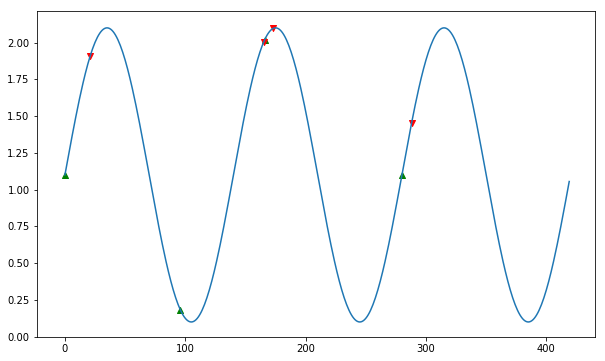

In [134]:
def sorted_ls(path):
    mtime = lambda f: os.stat(os.path.join(path, f)).st_mtime
    return list(sorted(os.listdir(path), key=mtime))

runs = sorted_ls('models')
latest_run = runs[-1]
models = [fn for fn in os.listdir('models/' + latest_run) if fn.endswith('.h5f')]
# sort models to best reward is last in list
j = len('weights_')
k = len('.h5f')
latest_model = sorted(models, key=lambda fn: fn[j:-k])[-1]
weights_fn = 'models/%s/%s' % (latest_run, latest_model) 
fig, trades = image_from_file(env, dqn, weights_fn)
_ = display(fig)
weights_fn

In [136]:
trades

[{'step': 0,
  'time': 0,
  'type': 'buy',
  'subtype': 'buy-long',
  'price': 1.0551351696494862,
  'cost': 1.0651351696494862},
 {'step': 21,
  'time': 21,
  'type': 'sell',
  'subtype': 'sell-long',
  'price': 1.8818314824680316,
  'cost': 0.01,
  'delta': 0.8166963128185454,
  'proceeds': 1.8718314824680315},
 {'step': 96,
  'time': 96,
  'type': 'buy',
  'subtype': 'buy-long',
  'price': 0.1990311320975806,
  'cost': 0.20903113209758062},
 {'step': 165,
  'time': 165,
  'type': 'sell',
  'subtype': 'sell-long',
  'price': 1.9805955318567359,
  'cost': 0.01,
  'delta': 1.7715643997591553,
  'proceeds': 1.9705955318567359},
 {'step': 166,
  'time': 166,
  'type': 'buy',
  'subtype': 'buy-long',
  'price': 2.0009688679024196,
  'cost': 2.0109688679024194},
 {'step': 173,
  'time': 173,
  'type': 'sell',
  'subtype': 'sell-long',
  'price': 2.0909497617679347,
  'cost': 0.01,
  'delta': 0.07998089386551512,
  'proceeds': 2.080949761767935},
 {'step': 280,
  'time': 280,
  'type': 'buy

"Not a happy chart - shouldn't this go up and to the right?"

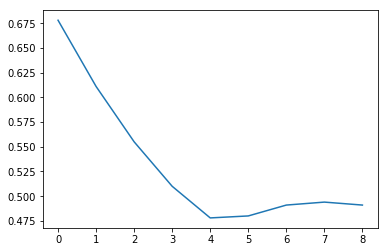

In [144]:
# hack to retrieve mean_q

train_text = """
Training for 100000 steps ...
Interval 1 (0 steps performed)
  348/10000 [>.............................] - ETA: 3:32:22 - reward: 0.0000e+ - ETA: 11:10 - reward: 0.0000e+00 - ETA: 4:43 - reward: 0.0000e+00 - ETA: 3:44 - reward: 0.0000e+0 - ETA: 3:15 - reward: 0.0000e+0 - ETA: 2:52 - reward: 0.0000e+0 - ETA: 2:39 - reward: 0.0000e+0 - ETA: 2:33 - reward: 0.0000e+0 - ETA: 2:15 - reward: 0.0000e+0 - ETA: 1:59 - reward: 0.0000e+0 - ETA: 1:48 - reward: 0.0000e+0 - ETA: 1:41 - reward: 0.0000e+0 - ETA: 1:28 - reward: 0.0000e+0 - ETA: 1:19 - reward: 0.0000e+0 - ETA: 1:13 - reward: 0.0000e+0 - ETA: 1:11 - reward: 0.0000e+0 - ETA: 1:06 - reward: 2.3489e-0 - ETA: 1:03 - reward: 5.6038e-0 - ETA: 1:01 - reward: 4.7161e-05
episode_reward 0.013039261256597568 best: 0.013039261256597568
  419/10000 [>.............................] - ETA: 1:26 - reward: 3.7043e-0 - ETA: 1:23 - reward: 3.5529e-0 - ETA: 1:22 - reward: 3.4404e-0 - ETA: 1:22 - reward: 3.3780e-0 - ETA: 1:23 - reward: 3.3693e-0 - ETA: 1:22 - reward: 3.2598e-0 - ETA: 1:19 - reward: 1.0404e-05
episode_reward -0.008680035553254724 best: 0.013039261256597568
  649/10000 [>.............................] - ETA: 1:19 - reward: 1.0233e-0 - ETA: 1:19 - reward: 1.1056e-0 - ETA: 1:18 - reward: 1.7472e-0 - ETA: 1:18 - reward: 2.0573e-0 - ETA: 1:16 - reward: 2.7976e-0 - ETA: 1:15 - reward: 3.4016e-0 - ETA: 1:15 - reward: 3.7574e-0 - ETA: 1:14 - reward: 4.3111e-0 - ETA: 1:12 - reward: 5.0319e-0 - ETA: 1:10 - reward: 5.7763e-0 - ETA: 1:09 - reward: 6.1969e-0 - ETA: 1:09 - reward: 6.5996e-0 - ETA: 1:08 - reward: 6.8905e-0 - ETA: 1:07 - reward: 7.4157e-0 - ETA: 1:06 - reward: 7.7685e-0 - ETA: 1:07 - reward: 7.8545e-0 - ETA: 1:07 - reward: 8.1626e-0 - ETA: 1:06 - reward: 8.5129e-0 - ETA: 1:04 - reward: 7.9493e-05
episode_reward 0.0388093143612613 best: 0.0388093143612613
  888/10000 [=>............................] - ETA: 1:05 - reward: 6.5606e-0 - ETA: 1:06 - reward: 6.5506e-0 - ETA: 1:06 - reward: 6.5111e-0 - ETA: 1:06 - reward: 6.4527e-0 - ETA: 1:05 - reward: 6.3020e-0 - ETA: 1:05 - reward: 6.1935e-0 - ETA: 1:04 - reward: 6.1059e-0 - ETA: 1:05 - reward: 6.0973e-0 - ETA: 1:04 - reward: 5.9956e-0 - ETA: 1:03 - reward: 5.2304e-0 - ETA: 1:03 - reward: 4.2963e-0 - ETA: 1:03 - reward: 3.9238e-0 - ETA: 1:02 - reward: 3.3010e-0 - ETA: 1:02 - reward: 2.5984e-0 - ETA: 1:01 - reward: 2.5184e-0 - ETA: 1:01 - reward: 3.2070e-0 - ETA: 1:01 - reward: 4.7502e-0 - ETA: 1:01 - reward: 5.9111e-0 - ETA: 1:01 - reward: 6.7970e-0 - ETA: 1:01 - reward: 8.0415e-0 - ETA: 1:00 - reward: 9.9343e-0 - ETA: 1:00 - reward: 1.1186e-0 - ETA: 1:00 - reward: 1.1524e-0 - ETA: 1:00 - reward: 1.1572e-0 - ETA: 1:00 - reward: 1.0458e-04
episode_reward 0.04726810085716372 best: 0.04726810085716372
  952/10000 [=>............................] - ETA: 1:01 - reward: 1.0150e-0 - ETA: 1:02 - reward: 1.0139e-0 - ETA: 1:01 - reward: 9.9600e-0 - ETA: 1:01 - reward: 9.8408e-0 - ETA: 1:01 - reward: 9.7139e-0 - ETA: 1:01 - reward: 9.6620e-0 - ETA: 1:01 - reward: 9.5903e-0 - ETA: 1:01 - reward: 9.2874e-05
episode_reward -0.008884831933975221 best: 0.04726810085716372
 1178/10000 [==>...........................] - ETA: 1:01 - reward: 8.4950e-0 - ETA: 1:00 - reward: 8.3643e-0 - ETA: 1:00 - reward: 8.3301e-0 - ETA: 1:00 - reward: 8.2943e-0 - ETA: 1:39 - reward: 8.3107e-0 - ETA: 1:39 - reward: 8.2853e-0 - ETA: 1:39 - reward: 8.2206e-0 - ETA: 1:39 - reward: 8.0988e-0 - ETA: 1:39 - reward: 7.8321e-0 - ETA: 1:39 - reward: 7.5440e-0 - ETA: 1:40 - reward: 7.4300e-0 - ETA: 1:41 - reward: 7.3139e-0 - ETA: 1:41 - reward: 6.8517e-0 - ETA: 1:41 - reward: 6.5074e-0 - ETA: 1:41 - reward: 6.2790e-0 - ETA: 1:41 - reward: 5.8249e-0 - ETA: 1:41 - reward: 5.1502e-0 - ETA: 1:41 - reward: 4.5939e-0 - ETA: 1:41 - reward: 4.1526e-0 - ETA: 1:41 - reward: 3.7147e-0 - ETA: 1:41 - reward: 3.1720e-0 - ETA: 1:41 - reward: 2.8489e-0 - ETA: 1:41 - reward: 2.5275e-0 - ETA: 1:41 - reward: 2.1019e-0 - ETA: 1:41 - reward: 1.5743e-0 - ETA: 1:41 - reward: 1.1557e-0 - ETA: 1:41 - reward: 8.4382e-0 - ETA: 1:41 - reward: 7.4024e-0 - ETA: 1:42 - reward: 5.3366e-0 - ETA: 1:42 - reward: 3.2785e-0 - ETA: 1:42 - reward: -1.8339e- - ETA: 1:42 - reward: -7.9072e- - ETA: 1:42 - reward: -9.9169e- - ETA: 1:42 - reward: -1.1919e- - ETA: 1:42 - reward: -1.5902e- - ETA: 1:42 - reward: -2.0841e- - ETA: 1:42 - reward: -2.3782e- - ETA: 1:43 - reward: -2.5734e- - ETA: 1:43 - reward: -2.9618e- - ETA: 1:43 - reward: -3.3474e- - ETA: 1:43 - reward: -3.7303e- - ETA: 1:43 - reward: -3.8256e- - ETA: 1:44 - reward: -4.0156e- - ETA: 1:44 - reward: -4.2995e- - ETA: 1:44 - reward: -4.3938e- - ETA: 1:44 - reward: -4.6756e- - ETA: 1:44 - reward: -5.0491e- - ETA: 1:44 - reward: -5.3275e- - ETA: 1:45 - reward: -5.6965e- - ETA: 1:45 - reward: -5.7883e- - ETA: 1:45 - reward: -5.8800e- - ETA: 1:46 - reward: -5.9715e- - ETA: 1:46 - reward: -6.3360e- - ETA: 1:46 - reward: -6.7880e- - ETA: 1:45 - reward: -7.2362e- - ETA: 1:45 - reward: -7.5032e- - ETA: 1:45 - reward: -8.0333e- - ETA: 1:45 - reward: -8.4708e-05
episode_reward -0.18479068245276173 best: 0.04726810085716372
 1260/10000 [==>...........................] - ETA: 1:46 - reward: -8.7343e- - ETA: 1:46 - reward: -8.7195e- - ETA: 1:46 - reward: -8.6975e- - ETA: 1:46 - reward: -8.6683e- - ETA: 1:46 - reward: -8.6320e- - ETA: 1:46 - reward: -8.6032e- - ETA: 1:49 - reward: -8.5889e- - ETA: 1:50 - reward: -8.5818e- - ETA: 1:50 - reward: -8.5747e- - ETA: 1:51 - reward: -8.5675e- - ETA: 1:52 - reward: -8.5604e- - ETA: 1:52 - reward: -8.5392e- - ETA: 1:52 - reward: -8.5321e- - ETA: 1:53 - reward: -8.5251e- - ETA: 1:53 - reward: -8.5181e- - ETA: 1:53 - reward: -8.4831e- - ETA: 1:53 - reward: -8.4553e- - ETA: 1:53 - reward: -8.4484e- - ETA: 1:54 - reward: -8.4277e- - ETA: 1:54 - reward: -8.4071e- - ETA: 1:54 - reward: -8.3934e- - ETA: 1:54 - reward: -8.3662e- - ETA: 1:54 - reward: -8.3459e- - ETA: 1:54 - reward: -8.3190e- - ETA: 1:54 - reward: -8.2989e- - ETA: 1:54 - reward: -8.2723e- - ETA: 1:54 - reward: -8.2525e- - ETA: 1:54 - reward: -8.2687e- - ETA: 1:55 - reward: -8.3188e- - ETA: 1:55 - reward: -8.3565e- - ETA: 1:55 - reward: -8.5885e-05
episode_reward -0.008465236417381297 best: 0.04726810085716372
 1345/10000 [===>..........................] - ETA: 1:55 - reward: -8.8374e- - ETA: 1:55 - reward: -8.7712e- - ETA: 1:55 - reward: -8.7135e- - ETA: 1:55 - reward: -8.5973e- - ETA: 1:56 - reward: -8.4473e- - ETA: 1:56 - reward: -8.2663e- - ETA: 1:56 - reward: -8.0573e- - ETA: 1:56 - reward: -7.9043e- - ETA: 1:56 - reward: -7.6572e- - ETA: 1:56 - reward: -7.3018e- - ETA: 1:56 - reward: -6.9268e- - ETA: 1:56 - reward: -6.8313e- - ETA: 1:56 - reward: -6.5438e- - ETA: 1:56 - reward: -6.1647e- - ETA: 1:56 - reward: -5.8010e- - ETA: 1:57 - reward: -5.6283e- - ETA: 1:56 - reward: -5.2342e- - ETA: 1:57 - reward: -5.1629e- - ETA: 1:57 - reward: -5.0291e- - ETA: 1:57 - reward: -4.8518e- - ETA: 1:57 - reward: -4.6634e- - ETA: 1:57 - reward: -4.5347e- - ETA: 1:57 - reward: -4.4793e- - ETA: 1:57 - reward: -4.4672e- - ETA: 1:57 - reward: -4.6709e- - ETA: 1:57 - reward: -4.9566e-05
episode_reward 0.04379293168465097 best: 0.04726810085716372
 1573/10000 [===>..........................] - ETA: 1:57 - reward: -5.0417e- - ETA: 1:57 - reward: -5.0267e- - ETA: 1:57 - reward: -5.0119e- - ETA: 1:57 - reward: -4.9935e- - ETA: 1:57 - reward: -4.9898e- - ETA: 1:57 - reward: -4.9752e- - ETA: 1:57 - reward: -4.9570e- - ETA: 1:57 - reward: -4.9426e- - ETA: 1:57 - reward: -4.9318e- - ETA: 1:57 - reward: -4.9175e- - ETA: 1:57 - reward: -4.9104e- - ETA: 1:57 - reward: -4.9087e- - ETA: 1:57 - reward: -4.9138e- - ETA: 1:57 - reward: -4.9188e- - ETA: 1:57 - reward: -4.9239e- - ETA: 1:57 - reward: -4.9264e- - ETA: 1:57 - reward: -4.9326e- - ETA: 1:57 - reward: -4.9351e- - ETA: 1:57 - reward: -4.9376e- - ETA: 1:57 - reward: -4.9400e- - ETA: 1:57 - reward: -4.9449e- - ETA: 1:57 - reward: -4.9510e- - ETA: 1:57 - reward: -4.9547e- - ETA: 1:57 - reward: -4.9595e- - ETA: 1:57 - reward: -4.9655e- - ETA: 1:57 - reward: -4.9715e- - ETA: 1:57 - reward: -4.9727e- - ETA: 1:57 - reward: -4.9750e- - ETA: 1:57 - reward: -4.9786e- - ETA: 1:57 - reward: -4.9821e- - ETA: 1:57 - reward: -4.9879e- - ETA: 1:57 - reward: -4.9914e- - ETA: 1:57 - reward: -5.0018e- - ETA: 1:58 - reward: -5.0054e- - ETA: 1:58 - reward: -5.0125e- - ETA: 1:58 - reward: -5.0268e- - ETA: 1:58 - reward: -5.0410e- - ETA: 1:58 - reward: -5.0516e- - ETA: 1:57 - reward: -5.0692e- - ETA: 1:57 - reward: -5.0867e- - ETA: 1:57 - reward: -5.1006e- - ETA: 1:57 - reward: -5.1213e- - ETA: 1:57 - reward: -5.1384e- - ETA: 1:57 - reward: -5.1520e- - ETA: 1:57 - reward: -5.1655e- - ETA: 1:57 - reward: -5.1790e- - ETA: 1:56 - reward: -5.1957e- - ETA: 1:56 - reward: -5.2090e- - ETA: 1:56 - reward: -5.2223e- - ETA: 1:56 - reward: -5.2387e- - ETA: 1:56 - reward: -5.2518e- - ETA: 1:56 - reward: -5.2648e- - ETA: 1:56 - reward: -5.2810e- - ETA: 1:56 - reward: -5.3823e- - ETA: 1:56 - reward: -5.6284e- - ETA: 1:56 - reward: -5.8803e- - ETA: 1:55 - reward: -6.2314e- - ETA: 1:55 - reward: -6.6633e- - ETA: 1:55 - reward: -7.0207e- - ETA: 1:55 - reward: -7.3117e-05
episode_reward -0.04710195902865329 best: 0.04726810085716372
 1989/10000 [====>.........................] - ETA: 1:55 - reward: -7.3024e- - ETA: 1:55 - reward: -7.2885e- - ETA: 1:55 - reward: -7.2747e- - ETA: 1:55 - reward: -7.2609e- - ETA: 1:55 - reward: -7.2426e- - ETA: 1:55 - reward: -7.2244e- - ETA: 1:55 - reward: -7.2018e- - ETA: 1:55 - reward: -7.1883e- - ETA: 1:55 - reward: -7.1704e- - ETA: 1:55 - reward: -7.1481e- - ETA: 1:55 - reward: -7.1260e- - ETA: 1:55 - reward: -7.1040e- - ETA: 1:54 - reward: -7.0821e- - ETA: 1:54 - reward: -7.0604e- - ETA: 1:54 - reward: -7.0517e- - ETA: 1:55 - reward: -7.0474e- - ETA: 1:55 - reward: -7.0301e- - ETA: 1:55 - reward: -7.0087e- - ETA: 1:55 - reward: -6.9959e- - ETA: 1:54 - reward: -6.9790e- - ETA: 1:54 - reward: -6.9621e- - ETA: 1:54 - reward: -6.9452e- - ETA: 1:54 - reward: -6.9285e- - ETA: 1:54 - reward: -6.9086e- - ETA: 1:54 - reward: -6.9228e- - ETA: 1:54 - reward: -6.9345e- - ETA: 1:54 - reward: -6.9438e- - ETA: 1:54 - reward: -6.9530e- - ETA: 1:54 - reward: -6.9623e- - ETA: 1:53 - reward: -6.9639e- - ETA: 1:53 - reward: -6.9148e- - ETA: 1:53 - reward: -6.8061e- - ETA: 1:53 - reward: -6.7082e- - ETA: 1:53 - reward: -6.5842e- - ETA: 1:53 - reward: -6.3173e- - ETA: 1:53 - reward: -5.8970e- - ETA: 1:53 - reward: -5.4675e- - ETA: 1:53 - reward: -4.9737e- - ETA: 1:53 - reward: -4.4616e- - ETA: 1:53 - reward: -4.0540e- - ETA: 1:52 - reward: -3.6484e- - ETA: 1:52 - reward: -3.1439e- - ETA: 1:52 - reward: -2.6423e- - ETA: 1:52 - reward: -2.2431e- - ETA: 1:52 - reward: -1.8456e- - ETA: 1:52 - reward: -1.3514e- - ETA: 1:52 - reward: -9.5803e- - ETA: 1:52 - reward: -5.6979e- - ETA: 1:52 - reward: -2.2118e- - ETA: 1:52 - reward: 1.4697e-06 - ETA: 1:52 - reward: 2.7279e-0 - ETA: 1:52 - reward: 4.3869e-0 - ETA: 1:52 - reward: 6.1833e-0 - ETA: 1:52 - reward: 7.5312e-0 - ETA: 1:52 - reward: 8.4719e-0 - ETA: 1:51 - reward: 9.1054e-0 - ETA: 1:51 - reward: 9.8507e-0 - ETA: 1:51 - reward: 1.0592e-0 - ETA: 1:51 - reward: 1.1329e-0 - ETA: 1:51 - reward: 1.1916e-0 - ETA: 1:51 - reward: 1.2500e-0 - ETA: 1:51 - reward: 1.2937e-0 - ETA: 1:51 - reward: 1.3866e-0 - ETA: 1:51 - reward: 1.5278e-0 - ETA: 1:51 - reward: 1.6755e-0 - ETA: 1:51 - reward: 1.8931e-0 - ETA: 1:50 - reward: 2.1599e-0 - ETA: 1:50 - reward: 2.4471e-0 - ETA: 1:50 - reward: 2.6341e-0 - ETA: 1:50 - reward: 2.9891e-0 - ETA: 1:50 - reward: 3.4006e-0 - ETA: 1:50 - reward: 3.7632e-0 - ETA: 1:50 - reward: 4.1484e-0 - ETA: 1:50 - reward: 4.6441e-0 - ETA: 1:50 - reward: 4.9401e-0 - ETA: 1:50 - reward: 5.4313e-0 - ETA: 1:50 - reward: 5.8224e-0 - ETA: 1:50 - reward: 6.1146e-0 - ETA: 1:50 - reward: 6.4059e-0 - ETA: 1:50 - reward: 6.7929e-0 - ETA: 1:50 - reward: 7.2744e-0 - ETA: 1:50 - reward: 7.4662e-0 - ETA: 1:50 - reward: 7.7533e-0 - ETA: 1:50 - reward: 7.9442e-0 - ETA: 1:50 - reward: 8.2298e-0 - ETA: 1:50 - reward: 8.6092e-0 - ETA: 1:50 - reward: 8.7983e-0 - ETA: 1:50 - reward: 8.8927e-0 - ETA: 1:50 - reward: 8.9870e-0 - ETA: 1:50 - reward: 9.0812e-0 - ETA: 1:50 - reward: 9.2693e-0 - ETA: 1:50 - reward: 9.5508e-0 - ETA: 1:50 - reward: 9.9247e-0 - ETA: 1:50 - reward: 1.0297e-0 - ETA: 1:50 - reward: 1.0483e-0 - ETA: 1:50 - reward: 1.0853e-0 - ETA: 1:50 - reward: 1.1313e-0 - ETA: 1:50 - reward: 1.1680e-0 - ETA: 1:50 - reward: 1.2045e-0 - ETA: 1:52 - reward: 1.2136e-0 - ETA: 1:52 - reward: 1.2227e-0 - ETA: 1:52 - reward: 1.2500e-0 - ETA: 1:52 - reward: 1.2590e-0 - ETA: 1:52 - reward: 1.2681e-0 - ETA: 1:53 - reward: 1.2771e-0 - ETA: 1:53 - reward: 1.2862e-0 - ETA: 1:53 - reward: 1.3042e-0 - ETA: 1:53 - reward: 1.3132e-0 - ETA: 1:54 - reward: 1.3222e-0 - ETA: 1:54 - reward: 1.3491e-0 - ETA: 1:53 - reward: 1.3938e-0 - ETA: 1:53 - reward: 1.4383e-04
episode_reward 2.008515832115362 best: 2.008515832115362
 2410/10000 [======>.......................] - ETA: 1:54 - reward: 9.5008e-0 - ETA: 1:54 - reward: 9.4912e-0 - ETA: 1:54 - reward: 9.4770e-0 - ETA: 1:54 - reward: 9.4675e-0 - ETA: 1:54 - reward: 9.4628e-0 - ETA: 1:54 - reward: 9.4533e-0 - ETA: 1:54 - reward: 9.4392e-0 - ETA: 1:54 - reward: 9.4251e-0 - ETA: 1:54 - reward: 9.4157e-0 - ETA: 1:54 - reward: 9.3970e-0 - ETA: 1:54 - reward: 9.3738e-0 - ETA: 1:54 - reward: 9.3553e-0 - ETA: 1:54 - reward: 9.3322e-0 - ETA: 1:54 - reward: 9.3182e-0 - ETA: 1:54 - reward: 9.2978e-0 - ETA: 1:54 - reward: 9.2612e-0 - ETA: 1:54 - reward: 9.2467e-0 - ETA: 1:54 - reward: 9.2153e-0 - ETA: 1:54 - reward: 9.1840e-0 - ETA: 1:54 - reward: 9.1606e-0 - ETA: 1:54 - reward: 9.1450e-0 - ETA: 1:54 - reward: 9.1294e-0 - ETA: 1:54 - reward: 9.1217e-0 - ETA: 1:54 - reward: 9.1055e-0 - ETA: 1:54 - reward: 9.0970e-0 - ETA: 1:55 - reward: 9.0886e-0 - ETA: 1:56 - reward: 9.0801e-0 - ETA: 1:56 - reward: 9.0716e-0 - ETA: 1:56 - reward: 9.0632e-0 - ETA: 1:57 - reward: 9.0547e-0 - ETA: 1:57 - reward: 9.0379e-0 - ETA: 1:57 - reward: 9.0210e-0 - ETA: 1:57 - reward: 8.9958e-0 - ETA: 1:58 - reward: 8.9875e-0 - ETA: 1:57 - reward: 8.9540e-0 - ETA: 1:57 - reward: 8.9207e-0 - ETA: 1:57 - reward: 8.8875e-0 - ETA: 1:57 - reward: 8.8627e-0 - ETA: 1:57 - reward: 8.8545e-0 - ETA: 1:58 - reward: 8.8380e-0 - ETA: 1:58 - reward: 8.8215e-0 - ETA: 1:58 - reward: 8.8133e-0 - ETA: 1:58 - reward: 8.7887e-0 - ETA: 1:58 - reward: 8.7560e-0 - ETA: 1:58 - reward: 8.7153e-0 - ETA: 1:58 - reward: 8.6829e-0 - ETA: 1:58 - reward: 8.6668e-0 - ETA: 1:58 - reward: 8.6587e-0 - ETA: 1:58 - reward: 8.6426e-0 - ETA: 1:58 - reward: 8.6185e-0 - ETA: 1:58 - reward: 8.5945e-0 - ETA: 1:58 - reward: 8.5705e-0 - ETA: 1:58 - reward: 8.5386e-0 - ETA: 1:58 - reward: 8.5069e-0 - ETA: 1:58 - reward: 8.4831e-0 - ETA: 1:58 - reward: 8.4516e-0 - ETA: 1:58 - reward: 8.4280e-0 - ETA: 1:58 - reward: 8.3967e-0 - ETA: 1:58 - reward: 8.3889e-0 - ETA: 1:58 - reward: 8.3733e-0 - ETA: 1:58 - reward: 8.3577e-0 - ETA: 1:58 - reward: 8.3189e-0 - ETA: 1:57 - reward: 8.2803e-0 - ETA: 1:57 - reward: 8.2418e-0 - ETA: 1:57 - reward: 8.2035e-0 - ETA: 1:57 - reward: 8.1730e-0 - ETA: 1:57 - reward: 8.1275e-0 - ETA: 1:57 - reward: 8.0897e-0 - ETA: 1:57 - reward: 8.0521e-0 - ETA: 1:56 - reward: 8.0147e-0 - ETA: 1:56 - reward: 7.9775e-0 - ETA: 1:56 - reward: 7.9478e-0 - ETA: 1:56 - reward: 7.9182e-0 - ETA: 1:56 - reward: 7.8888e-0 - ETA: 1:56 - reward: 7.8517e-0 - ETA: 1:56 - reward: 7.8281e-0 - ETA: 1:56 - reward: 7.8045e-0 - ETA: 1:56 - reward: 7.7889e-0 - ETA: 1:56 - reward: 7.7575e-0 - ETA: 1:56 - reward: 7.7082e-0 - ETA: 1:55 - reward: 7.6681e-0 - ETA: 1:55 - reward: 7.6249e-0 - ETA: 1:55 - reward: 7.5958e-0 - ETA: 1:55 - reward: 7.5720e-0 - ETA: 1:55 - reward: 7.5576e-0 - ETA: 1:55 - reward: 7.5518e-0 - ETA: 1:54 - reward: 7.5519e-0 - ETA: 1:54 - reward: 7.5577e-0 - ETA: 1:54 - reward: 7.5635e-0 - ETA: 1:54 - reward: 7.5719e-0 - ETA: 1:54 - reward: 7.5859e-0 - ETA: 1:54 - reward: 7.6058e-0 - ETA: 1:54 - reward: 7.6260e-0 - ETA: 1:53 - reward: 7.6461e-0 - ETA: 1:53 - reward: 7.6661e-0 - ETA: 1:53 - reward: 7.6794e-0 - ETA: 1:53 - reward: 7.6926e-0 - ETA: 1:53 - reward: 7.7058e-0 - ETA: 1:53 - reward: 7.7223e-0 - ETA: 1:53 - reward: 7.7386e-0 - ETA: 1:52 - reward: 7.7549e-0 - ETA: 1:52 - reward: 7.7696e-0 - ETA: 1:52 - reward: 7.7778e-0 - ETA: 1:52 - reward: 7.7829e-0 - ETA: 1:52 - reward: 7.7855e-0 - ETA: 1:52 - reward: 7.7859e-0 - ETA: 1:52 - reward: 7.7836e-0 - ETA: 1:52 - reward: 7.7801e-0 - ETA: 1:51 - reward: 7.7765e-0 - ETA: 1:51 - reward: 7.7730e-0 - ETA: 1:51 - reward: 7.7707e-0 - ETA: 1:51 - reward: 7.7678e-0 - ETA: 1:51 - reward: 7.7649e-0 - ETA: 1:51 - reward: 7.7632e-04
episode_reward 0.5133987336542398 best: 2.008515832115362
 2830/10000 [=======>......................] - ETA: 1:51 - reward: 9.9789e-0 - ETA: 1:51 - reward: 9.9582e-0 - ETA: 1:51 - reward: 9.9377e-0 - ETA: 1:51 - reward: 9.9172e-0 - ETA: 1:50 - reward: 9.8968e-0 - ETA: 1:50 - reward: 9.8765e-0 - ETA: 1:50 - reward: 9.8563e-0 - ETA: 1:50 - reward: 9.8361e-0 - ETA: 1:50 - reward: 9.8161e-0 - ETA: 1:50 - reward: 9.8001e-0 - ETA: 1:50 - reward: 9.7842e-0 - ETA: 1:50 - reward: 9.7643e-0 - ETA: 1:49 - reward: 9.7406e-0 - ETA: 1:49 - reward: 9.7209e-0 - ETA: 1:49 - reward: 9.7013e-0 - ETA: 1:49 - reward: 9.6857e-0 - ETA: 1:49 - reward: 9.6663e-0 - ETA: 1:49 - reward: 9.6546e-0 - ETA: 1:49 - reward: 9.6353e-0 - ETA: 1:49 - reward: 9.6315e-0 - ETA: 1:49 - reward: 9.6199e-0 - ETA: 1:49 - reward: 9.6046e-0 - ETA: 1:49 - reward: 9.5854e-0 - ETA: 1:49 - reward: 9.5740e-0 - ETA: 1:49 - reward: 9.5550e-0 - ETA: 1:48 - reward: 9.5360e-0 - ETA: 1:48 - reward: 9.5151e-0 - ETA: 1:48 - reward: 9.4995e-0 - ETA: 1:48 - reward: 9.4875e-0 - ETA: 1:48 - reward: 9.4738e-0 - ETA: 1:48 - reward: 9.4627e-0 - ETA: 1:48 - reward: 9.4545e-0 - ETA: 1:48 - reward: 9.4504e-0 - ETA: 1:47 - reward: 9.4500e-0 - ETA: 1:47 - reward: 9.4540e-0 - ETA: 1:47 - reward: 9.4635e-0 - ETA: 1:47 - reward: 9.4720e-0 - ETA: 1:47 - reward: 9.4790e-0 - ETA: 1:47 - reward: 9.4915e-0 - ETA: 1:47 - reward: 9.5038e-0 - ETA: 1:47 - reward: 9.5148e-0 - ETA: 1:46 - reward: 9.5273e-0 - ETA: 1:46 - reward: 9.5377e-0 - ETA: 1:46 - reward: 9.5480e-0 - ETA: 1:46 - reward: 9.5582e-0 - ETA: 1:46 - reward: 9.5705e-0 - ETA: 1:46 - reward: 9.5807e-0 - ETA: 1:46 - reward: 9.5878e-0 - ETA: 1:46 - reward: 9.5906e-0 - ETA: 1:45 - reward: 9.5902e-0 - ETA: 1:45 - reward: 9.5873e-0 - ETA: 1:45 - reward: 9.5848e-0 - ETA: 1:45 - reward: 9.5807e-0 - ETA: 1:45 - reward: 9.5775e-0 - ETA: 1:45 - reward: 9.5750e-0 - ETA: 1:45 - reward: 9.5742e-0 - ETA: 1:45 - reward: 9.5702e-0 - ETA: 1:45 - reward: 9.5661e-0 - ETA: 1:45 - reward: 9.5629e-0 - ETA: 1:45 - reward: 9.5597e-0 - ETA: 1:45 - reward: 9.5557e-0 - ETA: 1:45 - reward: 9.5518e-0 - ETA: 1:45 - reward: 9.5502e-0 - ETA: 1:45 - reward: 9.5494e-0 - ETA: 1:45 - reward: 9.5473e-0 - ETA: 1:45 - reward: 9.5456e-0 - ETA: 1:45 - reward: 9.5438e-0 - ETA: 1:45 - reward: 9.5415e-0 - ETA: 1:45 - reward: 9.5399e-0 - ETA: 1:45 - reward: 9.5398e-0 - ETA: 1:45 - reward: 9.5404e-0 - ETA: 1:45 - reward: 9.5412e-0 - ETA: 1:45 - reward: 9.5417e-0 - ETA: 1:45 - reward: 9.5436e-0 - ETA: 1:45 - reward: 9.5457e-0 - ETA: 1:45 - reward: 9.5486e-0 - ETA: 1:45 - reward: 9.5504e-0 - ETA: 1:45 - reward: 9.5514e-0 - ETA: 1:45 - reward: 9.5524e-0 - ETA: 1:45 - reward: 9.5523e-0 - ETA: 1:45 - reward: 9.5498e-0 - ETA: 1:44 - reward: 9.5420e-0 - ETA: 1:44 - reward: 9.5278e-0 - ETA: 1:44 - reward: 9.5135e-0 - ETA: 1:44 - reward: 9.5022e-0 - ETA: 1:44 - reward: 9.4965e-0 - ETA: 1:44 - reward: 9.4908e-0 - ETA: 1:44 - reward: 9.4880e-0 - ETA: 1:44 - reward: 9.4851e-0 - ETA: 1:44 - reward: 9.4766e-0 - ETA: 1:44 - reward: 9.4682e-0 - ETA: 1:44 - reward: 9.4541e-0 - ETA: 1:44 - reward: 9.4429e-0 - ETA: 1:44 - reward: 9.4345e-0 - ETA: 1:44 - reward: 9.4289e-0 - ETA: 1:44 - reward: 9.4206e-0 - ETA: 1:44 - reward: 9.4067e-0 - ETA: 1:44 - reward: 9.4011e-0 - ETA: 1:44 - reward: 9.3985e-0 - ETA: 1:44 - reward: 9.3933e-0 - ETA: 1:44 - reward: 9.3862e-0 - ETA: 1:44 - reward: 9.3797e-0 - ETA: 1:44 - reward: 9.3730e-0 - ETA: 1:44 - reward: 9.3642e-0 - ETA: 1:45 - reward: 9.3621e-0 - ETA: 1:46 - reward: 9.3599e-0 - ETA: 1:46 - reward: 9.3517e-0 - ETA: 1:46 - reward: 9.3481e-0 - ETA: 1:46 - reward: 9.3464e-0 - ETA: 1:46 - reward: 9.3448e-0 - ETA: 1:46 - reward: 2.2744e-04
episode_reward -1.7632467584593492 best: 2.008515832115362
 3247/10000 [========>.....................] - ETA: 1:47 - reward: 2.2736e-0 - ETA: 1:47 - reward: 2.2720e-0 - ETA: 1:47 - reward: 2.2696e-0 - ETA: 1:47 - reward: 2.2664e-0 - ETA: 1:47 - reward: 2.2640e-0 - ETA: 1:47 - reward: 2.2608e-0 - ETA: 1:47 - reward: 2.2584e-0 - ETA: 1:46 - reward: 2.2553e-0 - ETA: 1:46 - reward: 2.2521e-0 - ETA: 1:46 - reward: 2.2498e-0 - ETA: 1:46 - reward: 2.2466e-0 - ETA: 1:47 - reward: 2.2458e-0 - ETA: 1:47 - reward: 2.2435e-0 - ETA: 1:46 - reward: 2.2404e-0 - ETA: 1:46 - reward: 2.2365e-0 - ETA: 1:46 - reward: 2.2326e-0 - ETA: 1:46 - reward: 2.2303e-0 - ETA: 1:46 - reward: 2.2279e-0 - ETA: 1:46 - reward: 2.2231e-0 - ETA: 1:46 - reward: 2.2171e-0 - ETA: 1:46 - reward: 2.2135e-0 - ETA: 1:46 - reward: 2.2076e-0 - ETA: 1:46 - reward: 2.2041e-0 - ETA: 1:46 - reward: 2.2017e-0 - ETA: 1:46 - reward: 2.2005e-0 - ETA: 1:46 - reward: 2.1982e-0 - ETA: 1:46 - reward: 2.1946e-0 - ETA: 1:46 - reward: 2.1888e-0 - ETA: 1:46 - reward: 2.1841e-0 - ETA: 1:46 - reward: 2.1794e-0 - ETA: 1:46 - reward: 2.1771e-0 - ETA: 1:46 - reward: 2.1724e-0 - ETA: 1:46 - reward: 2.1667e-0 - ETA: 1:46 - reward: 2.1622e-0 - ETA: 1:45 - reward: 2.1579e-0 - ETA: 1:45 - reward: 2.1552e-0 - ETA: 1:45 - reward: 2.1545e-0 - ETA: 1:45 - reward: 2.1553e-0 - ETA: 1:45 - reward: 2.1575e-0 - ETA: 1:45 - reward: 2.1631e-0 - ETA: 1:45 - reward: 2.1725e-0 - ETA: 1:45 - reward: 2.1856e-0 - ETA: 1:45 - reward: 2.1988e-0 - ETA: 1:45 - reward: 2.2142e-0 - ETA: 1:44 - reward: 2.2343e-0 - ETA: 1:44 - reward: 2.2543e-0 - ETA: 1:44 - reward: 2.2742e-0 - ETA: 1:44 - reward: 2.2940e-0 - ETA: 1:44 - reward: 2.3137e-0 - ETA: 1:44 - reward: 2.3333e-0 - ETA: 1:44 - reward: 2.3490e-0 - ETA: 1:44 - reward: 2.3647e-0 - ETA: 1:43 - reward: 2.3841e-0 - ETA: 1:43 - reward: 2.4074e-0 - ETA: 1:43 - reward: 2.4262e-0 - ETA: 1:43 - reward: 2.4409e-0 - ETA: 1:43 - reward: 2.4516e-0 - ETA: 1:43 - reward: 2.4588e-0 - ETA: 1:43 - reward: 2.4650e-0 - ETA: 1:43 - reward: 2.4706e-0 - ETA: 1:43 - reward: 2.4750e-0 - ETA: 1:42 - reward: 2.4789e-0 - ETA: 1:42 - reward: 2.4835e-0 - ETA: 1:42 - reward: 2.4866e-0 - ETA: 1:42 - reward: 2.4911e-0 - ETA: 1:42 - reward: 2.4949e-0 - ETA: 1:42 - reward: 2.4987e-0 - ETA: 1:42 - reward: 2.5029e-0 - ETA: 1:42 - reward: 2.5076e-0 - ETA: 1:41 - reward: 2.5149e-0 - ETA: 1:41 - reward: 2.5214e-0 - ETA: 1:41 - reward: 2.5322e-0 - ETA: 1:41 - reward: 2.5352e-0 - ETA: 1:41 - reward: 2.5485e-0 - ETA: 1:41 - reward: 2.5676e-0 - ETA: 1:41 - reward: 2.5842e-0 - ETA: 1:41 - reward: 2.6059e-0 - ETA: 1:41 - reward: 2.6322e-0 - ETA: 1:41 - reward: 2.6532e-0 - ETA: 1:41 - reward: 2.6724e-0 - ETA: 1:41 - reward: 2.6889e-0 - ETA: 1:40 - reward: 2.7044e-0 - ETA: 1:40 - reward: 2.7132e-0 - ETA: 1:40 - reward: 2.7172e-0 - ETA: 1:40 - reward: 2.7185e-0 - ETA: 1:40 - reward: 2.7187e-0 - ETA: 1:40 - reward: 2.7190e-0 - ETA: 1:40 - reward: 2.7192e-0 - ETA: 1:40 - reward: 2.7194e-0 - ETA: 1:39 - reward: 2.7197e-0 - ETA: 1:39 - reward: 2.7197e-0 - ETA: 1:39 - reward: 2.7198e-0 - ETA: 1:40 - reward: 2.7199e-0 - ETA: 1:39 - reward: 2.7201e-0 - ETA: 1:39 - reward: 2.7201e-0 - ETA: 1:39 - reward: 2.7200e-0 - ETA: 1:39 - reward: 2.7200e-0 - ETA: 1:39 - reward: 2.7199e-0 - ETA: 1:39 - reward: 2.7204e-04
episode_reward 0.5354148107301633 best: 2.008515832115362
 3666/10000 [=========>....................] - ETA: 1:39 - reward: 3.6279e-0 - ETA: 1:39 - reward: 3.6223e-0 - ETA: 1:39 - reward: 3.6157e-0 - ETA: 1:39 - reward: 3.6123e-0 - ETA: 1:39 - reward: 3.6079e-0 - ETA: 1:38 - reward: 3.6024e-0 - ETA: 1:38 - reward: 3.5969e-0 - ETA: 1:38 - reward: 3.5925e-0 - ETA: 1:38 - reward: 3.5871e-0 - ETA: 1:38 - reward: 3.5838e-0 - ETA: 1:38 - reward: 3.5812e-0 - ETA: 1:38 - reward: 3.5765e-0 - ETA: 1:38 - reward: 3.5668e-0 - ETA: 1:38 - reward: 3.5556e-0 - ETA: 1:38 - reward: 3.5466e-0 - ETA: 1:38 - reward: 3.5355e-0 - ETA: 1:38 - reward: 3.5266e-0 - ETA: 1:38 - reward: 3.5177e-0 - ETA: 1:37 - reward: 3.5063e-0 - ETA: 1:37 - reward: 3.4903e-0 - ETA: 1:37 - reward: 3.4771e-0 - ETA: 1:37 - reward: 3.4665e-0 - ETA: 1:37 - reward: 3.4529e-0 - ETA: 1:37 - reward: 3.4355e-0 - ETA: 1:37 - reward: 3.4182e-0 - ETA: 1:37 - reward: 3.4009e-0 - ETA: 1:36 - reward: 3.3866e-0 - ETA: 1:36 - reward: 3.3751e-0 - ETA: 1:36 - reward: 3.3609e-0 - ETA: 1:36 - reward: 3.3467e-0 - ETA: 1:36 - reward: 3.3296e-0 - ETA: 1:36 - reward: 3.3127e-0 - ETA: 1:36 - reward: 3.2963e-0 - ETA: 1:36 - reward: 3.2830e-0 - ETA: 1:35 - reward: 3.2671e-0 - ETA: 1:35 - reward: 3.2513e-0 - ETA: 1:35 - reward: 3.2407e-0 - ETA: 1:35 - reward: 3.2276e-0 - ETA: 1:35 - reward: 3.2145e-0 - ETA: 1:35 - reward: 3.2040e-0 - ETA: 1:35 - reward: 3.1910e-0 - ETA: 1:35 - reward: 3.1754e-0 - ETA: 1:35 - reward: 3.1625e-0 - ETA: 1:35 - reward: 3.1518e-0 - ETA: 1:34 - reward: 3.1397e-0 - ETA: 1:34 - reward: 3.1246e-0 - ETA: 1:34 - reward: 3.1156e-0 - ETA: 1:34 - reward: 3.1066e-0 - ETA: 1:34 - reward: 3.1006e-0 - ETA: 1:34 - reward: 3.0887e-0 - ETA: 1:34 - reward: 3.0797e-0 - ETA: 1:34 - reward: 3.0678e-0 - ETA: 1:34 - reward: 3.0520e-0 - ETA: 1:34 - reward: 3.0360e-0 - ETA: 1:34 - reward: 3.0263e-0 - ETA: 1:34 - reward: 3.0135e-0 - ETA: 1:34 - reward: 3.0040e-0 - ETA: 1:34 - reward: 2.9976e-0 - ETA: 1:34 - reward: 2.9944e-0 - ETA: 1:34 - reward: 2.9849e-0 - ETA: 1:34 - reward: 2.9690e-0 - ETA: 1:34 - reward: 2.9595e-0 - ETA: 1:34 - reward: 2.9500e-0 - ETA: 1:34 - reward: 2.9437e-0 - ETA: 1:34 - reward: 2.9311e-0 - ETA: 1:34 - reward: 2.9217e-0 - ETA: 1:34 - reward: 2.9069e-0 - ETA: 1:34 - reward: 2.8950e-0 - ETA: 1:33 - reward: 2.8803e-0 - ETA: 1:33 - reward: 2.8685e-0 - ETA: 1:33 - reward: 2.8541e-0 - ETA: 1:33 - reward: 2.8426e-0 - ETA: 1:33 - reward: 2.8312e-0 - ETA: 1:33 - reward: 2.8197e-0 - ETA: 1:33 - reward: 2.8083e-0 - ETA: 1:34 - reward: 2.8054e-0 - ETA: 1:34 - reward: 2.8026e-0 - ETA: 1:34 - reward: 2.7997e-0 - ETA: 1:34 - reward: 2.7969e-0 - ETA: 1:34 - reward: 2.7884e-0 - ETA: 1:34 - reward: 2.7799e-0 - ETA: 1:34 - reward: 2.7770e-0 - ETA: 1:35 - reward: 2.7714e-0 - ETA: 1:34 - reward: 2.7600e-0 - ETA: 1:34 - reward: 2.7516e-0 - ETA: 1:34 - reward: 2.7403e-0 - ETA: 1:34 - reward: 2.7291e-0 - ETA: 1:34 - reward: 2.7234e-0 - ETA: 1:34 - reward: 2.7106e-0 - ETA: 1:34 - reward: 2.7041e-0 - ETA: 1:34 - reward: 2.6913e-0 - ETA: 1:34 - reward: 2.6752e-0 - ETA: 1:34 - reward: 2.6560e-0 - ETA: 1:34 - reward: 2.6368e-0 - ETA: 1:34 - reward: 2.6209e-0 - ETA: 1:34 - reward: 2.6051e-0 - ETA: 1:33 - reward: 2.5892e-0 - ETA: 1:33 - reward: 2.5699e-0 - ETA: 1:33 - reward: 2.5507e-0 - ETA: 1:33 - reward: 2.5347e-0 - ETA: 1:33 - reward: 2.5220e-0 - ETA: 1:33 - reward: 2.5125e-04
episode_reward -0.6425085673854587 best: 2.008515832115362
 4085/10000 [===========>..................] - ETA: 1:33 - reward: 1.4624e-0 - ETA: 1:33 - reward: 1.4612e-0 - ETA: 1:33 - reward: 1.4596e-0 - ETA: 1:33 - reward: 1.4584e-0 - ETA: 1:33 - reward: 1.4573e-0 - ETA: 1:33 - reward: 1.4561e-0 - ETA: 1:33 - reward: 1.4545e-0 - ETA: 1:33 - reward: 1.4529e-0 - ETA: 1:33 - reward: 1.4513e-0 - ETA: 1:33 - reward: 1.4498e-0 - ETA: 1:32 - reward: 1.4474e-0 - ETA: 1:32 - reward: 1.4447e-0 - ETA: 1:32 - reward: 1.4419e-0 - ETA: 1:32 - reward: 1.4343e-0 - ETA: 1:32 - reward: 1.4255e-0 - ETA: 1:32 - reward: 1.4166e-0 - ETA: 1:32 - reward: 1.4077e-0 - ETA: 1:32 - reward: 1.3989e-0 - ETA: 1:32 - reward: 1.3884e-0 - ETA: 1:31 - reward: 1.3814e-0 - ETA: 1:31 - reward: 1.3744e-0 - ETA: 1:31 - reward: 1.3644e-0 - ETA: 1:31 - reward: 1.3602e-0 - ETA: 1:31 - reward: 1.3582e-0 - ETA: 1:31 - reward: 1.3499e-0 - ETA: 1:31 - reward: 1.3437e-0 - ETA: 1:31 - reward: 1.3314e-0 - ETA: 1:31 - reward: 1.3190e-0 - ETA: 1:31 - reward: 1.3106e-0 - ETA: 1:31 - reward: 1.3001e-0 - ETA: 1:31 - reward: 1.2876e-0 - ETA: 1:31 - reward: 1.2771e-0 - ETA: 1:31 - reward: 1.2688e-0 - ETA: 1:30 - reward: 1.2584e-0 - ETA: 1:30 - reward: 1.2502e-0 - ETA: 1:30 - reward: 1.2419e-0 - ETA: 1:30 - reward: 1.2337e-0 - ETA: 1:30 - reward: 1.2275e-0 - ETA: 1:30 - reward: 1.2213e-0 - ETA: 1:30 - reward: 1.2111e-0 - ETA: 1:30 - reward: 1.2070e-0 - ETA: 1:30 - reward: 1.1968e-0 - ETA: 1:30 - reward: 1.1862e-0 - ETA: 1:30 - reward: 1.1756e-0 - ETA: 1:30 - reward: 1.1649e-0 - ETA: 1:30 - reward: 1.1564e-0 - ETA: 1:30 - reward: 1.1479e-0 - ETA: 1:29 - reward: 1.1373e-0 - ETA: 1:29 - reward: 1.1247e-0 - ETA: 1:29 - reward: 1.1141e-0 - ETA: 1:29 - reward: 1.1036e-0 - ETA: 1:29 - reward: 1.0932e-0 - ETA: 1:29 - reward: 1.0827e-0 - ETA: 1:29 - reward: 1.0744e-0 - ETA: 1:29 - reward: 1.0661e-0 - ETA: 1:29 - reward: 1.0557e-0 - ETA: 1:29 - reward: 1.0433e-0 - ETA: 1:28 - reward: 1.0330e-0 - ETA: 1:28 - reward: 1.0247e-0 - ETA: 1:28 - reward: 1.0146e-0 - ETA: 1:28 - reward: 1.0045e-0 - ETA: 1:28 - reward: 9.9481e-0 - ETA: 1:28 - reward: 9.8904e-0 - ETA: 1:28 - reward: 9.7946e-0 - ETA: 1:28 - reward: 9.6799e-0 - ETA: 1:28 - reward: 9.5655e-0 - ETA: 1:28 - reward: 9.4705e-0 - ETA: 1:27 - reward: 9.3757e-0 - ETA: 1:27 - reward: 9.2812e-0 - ETA: 1:27 - reward: 9.1869e-0 - ETA: 1:27 - reward: 9.1116e-0 - ETA: 1:27 - reward: 9.0177e-0 - ETA: 1:27 - reward: 8.9241e-0 - ETA: 1:27 - reward: 8.8307e-0 - ETA: 1:27 - reward: 8.7189e-0 - ETA: 1:27 - reward: 8.6260e-0 - ETA: 1:27 - reward: 8.5518e-0 - ETA: 1:26 - reward: 8.4593e-0 - ETA: 1:26 - reward: 8.3671e-0 - ETA: 1:26 - reward: 8.2567e-0 - ETA: 1:26 - reward: 8.1649e-0 - ETA: 1:26 - reward: 8.0917e-0 - ETA: 1:26 - reward: 8.0186e-0 - ETA: 1:26 - reward: 7.9456e-0 - ETA: 1:26 - reward: 7.8547e-0 - ETA: 1:26 - reward: 7.7639e-0 - ETA: 1:26 - reward: 7.6734e-0 - ETA: 1:25 - reward: 7.5650e-0 - ETA: 1:25 - reward: 7.4750e-0 - ETA: 1:25 - reward: 7.3851e-0 - ETA: 1:25 - reward: 7.2955e-0 - ETA: 1:25 - reward: 7.2240e-05
episode_reward -0.518270898546566 best: 2.008515832115362
 4506/10000 [============>.................] - ETA: 1:25 - reward: 4.4741e-0 - ETA: 1:25 - reward: 4.4686e-0 - ETA: 1:25 - reward: 4.4632e-0 - ETA: 1:25 - reward: 4.4610e-0 - ETA: 1:25 - reward: 4.4577e-0 - ETA: 1:25 - reward: 4.4523e-0 - ETA: 1:25 - reward: 4.4469e-0 - ETA: 1:25 - reward: 4.4415e-0 - ETA: 1:25 - reward: 4.4361e-0 - ETA: 1:24 - reward: 4.4318e-0 - ETA: 1:24 - reward: 4.4275e-0 - ETA: 1:24 - reward: 4.4222e-0 - ETA: 1:24 - reward: 4.4168e-0 - ETA: 1:24 - reward: 4.4115e-0 - ETA: 1:24 - reward: 4.4062e-0 - ETA: 1:24 - reward: 4.4009e-0 - ETA: 1:24 - reward: 4.3956e-0 - ETA: 1:24 - reward: 4.3893e-0 - ETA: 1:24 - reward: 4.3840e-0 - ETA: 1:23 - reward: 4.3777e-0 - ETA: 1:23 - reward: 4.3714e-0 - ETA: 1:23 - reward: 4.3672e-0 - ETA: 1:23 - reward: 4.3631e-0 - ETA: 1:23 - reward: 4.3579e-0 - ETA: 1:23 - reward: 4.3527e-0 - ETA: 1:23 - reward: 4.3475e-0 - ETA: 1:23 - reward: 4.3998e-0 - ETA: 1:23 - reward: 4.4886e-0 - ETA: 1:23 - reward: 4.5862e-0 - ETA: 1:23 - reward: 4.9235e-0 - ETA: 1:22 - reward: 5.4176e-0 - ETA: 1:22 - reward: 6.2645e-0 - ETA: 1:22 - reward: 7.3569e-0 - ETA: 1:22 - reward: 8.2758e-0 - ETA: 1:22 - reward: 9.1929e-0 - ETA: 1:22 - reward: 1.0124e-0 - ETA: 1:22 - reward: 1.1138e-0 - ETA: 1:22 - reward: 1.2217e-0 - ETA: 1:22 - reward: 1.3603e-0 - ETA: 1:22 - reward: 1.4427e-0 - ETA: 1:22 - reward: 1.4697e-0 - ETA: 1:22 - reward: 1.4964e-0 - ETA: 1:22 - reward: 1.5741e-0 - ETA: 1:22 - reward: 1.6470e-0 - ETA: 1:22 - reward: 1.7544e-0 - ETA: 1:22 - reward: 1.8246e-0 - ETA: 1:22 - reward: 1.8396e-0 - ETA: 1:22 - reward: 1.8783e-0 - ETA: 1:22 - reward: 1.9067e-0 - ETA: 1:22 - reward: 1.9278e-0 - ETA: 1:22 - reward: 1.9316e-0 - ETA: 1:22 - reward: 1.9343e-0 - ETA: 1:22 - reward: 1.9363e-0 - ETA: 1:22 - reward: 1.9397e-0 - ETA: 1:21 - reward: 1.9391e-0 - ETA: 1:21 - reward: 1.9327e-0 - ETA: 1:21 - reward: 1.9238e-0 - ETA: 1:21 - reward: 1.9175e-0 - ETA: 1:21 - reward: 1.9099e-0 - ETA: 1:21 - reward: 1.9049e-0 - ETA: 1:21 - reward: 1.8983e-0 - ETA: 1:21 - reward: 1.8920e-0 - ETA: 1:21 - reward: 1.8868e-0 - ETA: 1:21 - reward: 1.8848e-0 - ETA: 1:21 - reward: 1.8837e-0 - ETA: 1:21 - reward: 1.8827e-0 - ETA: 1:21 - reward: 1.8817e-0 - ETA: 1:21 - reward: 1.8786e-0 - ETA: 1:21 - reward: 1.8765e-0 - ETA: 1:22 - reward: 1.8755e-0 - ETA: 1:22 - reward: 1.8744e-0 - ETA: 1:22 - reward: 1.8734e-0 - ETA: 1:22 - reward: 1.8724e-0 - ETA: 1:22 - reward: 1.8682e-0 - ETA: 1:22 - reward: 1.8641e-0 - ETA: 1:22 - reward: 1.8610e-0 - ETA: 1:22 - reward: 1.8580e-0 - ETA: 1:22 - reward: 1.8549e-0 - ETA: 1:21 - reward: 1.8508e-0 - ETA: 1:21 - reward: 1.8477e-0 - ETA: 1:21 - reward: 1.8447e-0 - ETA: 1:21 - reward: 1.8437e-0 - ETA: 1:21 - reward: 1.8416e-0 - ETA: 1:21 - reward: 1.8386e-0 - ETA: 1:21 - reward: 1.8345e-0 - ETA: 1:21 - reward: 1.8315e-0 - ETA: 1:21 - reward: 1.8274e-0 - ETA: 1:21 - reward: 1.8234e-0 - ETA: 1:21 - reward: 1.8204e-0 - ETA: 1:21 - reward: 1.8173e-0 - ETA: 1:21 - reward: 1.8123e-0 - ETA: 1:21 - reward: 1.8083e-0 - ETA: 1:21 - reward: 1.8033e-0 - ETA: 1:21 - reward: 1.7993e-0 - ETA: 1:21 - reward: 1.7963e-0 - ETA: 1:21 - reward: 1.7923e-0 - ETA: 1:21 - reward: 1.7792e-0 - ETA: 1:21 - reward: 1.7597e-0 - ETA: 1:21 - reward: 1.7480e-0 - ETA: 1:20 - reward: 1.7325e-0 - ETA: 1:20 - reward: 1.7131e-0 - ETA: 1:20 - reward: 1.6938e-0 - ETA: 1:20 - reward: 1.6745e-0 - ETA: 1:20 - reward: 1.6629e-0 - ETA: 1:20 - reward: 1.6437e-0 - ETA: 1:20 - reward: 1.6298e-0 - ETA: 1:20 - reward: 1.6386e-0 - ETA: 1:20 - reward: 4.9747e-05
episode_reward 0.20586861599014838 best: 2.008515832115362
 4923/10000 [=============>................] - ETA: 1:20 - reward: 4.9736e-0 - ETA: 1:20 - reward: 4.9692e-0 - ETA: 1:20 - reward: 4.9626e-0 - ETA: 1:20 - reward: 4.9560e-0 - ETA: 1:19 - reward: 4.9494e-0 - ETA: 1:19 - reward: 4.9450e-0 - ETA: 1:19 - reward: 4.9396e-0 - ETA: 1:19 - reward: 4.9331e-0 - ETA: 1:19 - reward: 4.9298e-0 - ETA: 1:19 - reward: 4.9244e-0 - ETA: 1:19 - reward: 4.9201e-0 - ETA: 1:19 - reward: 4.9050e-0 - ETA: 1:19 - reward: 4.8833e-0 - ETA: 1:19 - reward: 4.8462e-0 - ETA: 1:18 - reward: 4.8122e-0 - ETA: 1:18 - reward: 4.7714e-0 - ETA: 1:18 - reward: 4.7308e-0 - ETA: 1:18 - reward: 4.7038e-0 - ETA: 1:18 - reward: 4.6701e-0 - ETA: 1:18 - reward: 4.6365e-0 - ETA: 1:18 - reward: 4.6097e-0 - ETA: 1:18 - reward: 4.5896e-0 - ETA: 1:18 - reward: 4.5628e-0 - ETA: 1:18 - reward: 4.5294e-0 - ETA: 1:18 - reward: 4.5028e-0 - ETA: 1:18 - reward: 4.4695e-0 - ETA: 1:17 - reward: 4.4377e-0 - ETA: 1:17 - reward: 4.4229e-0 - ETA: 1:17 - reward: 4.4187e-0 - ETA: 1:17 - reward: 4.4302e-0 - ETA: 1:17 - reward: 4.4702e-0 - ETA: 1:17 - reward: 4.5078e-0 - ETA: 1:17 - reward: 4.5879e-0 - ETA: 1:17 - reward: 4.6676e-0 - ETA: 1:17 - reward: 4.7872e-0 - ETA: 1:17 - reward: 4.8961e-0 - ETA: 1:17 - reward: 5.0442e-0 - ETA: 1:17 - reward: 5.2002e-0 - ETA: 1:17 - reward: 5.2950e-0 - ETA: 1:17 - reward: 5.4199e-0 - ETA: 1:17 - reward: 5.5690e-0 - ETA: 1:16 - reward: 5.7050e-0 - ETA: 1:16 - reward: 5.8226e-0 - ETA: 1:16 - reward: 5.9175e-0 - ETA: 1:16 - reward: 5.9969e-0 - ETA: 1:16 - reward: 6.0324e-0 - ETA: 1:16 - reward: 6.0425e-0 - ETA: 1:16 - reward: 6.0473e-0 - ETA: 1:16 - reward: 6.0533e-0 - ETA: 1:16 - reward: 6.0544e-0 - ETA: 1:16 - reward: 6.0537e-0 - ETA: 1:15 - reward: 6.0529e-0 - ETA: 1:15 - reward: 6.0522e-0 - ETA: 1:15 - reward: 6.0516e-0 - ETA: 1:15 - reward: 6.0509e-0 - ETA: 1:15 - reward: 6.0501e-0 - ETA: 1:15 - reward: 6.0494e-0 - ETA: 1:15 - reward: 6.0495e-0 - ETA: 1:15 - reward: 6.0623e-0 - ETA: 1:15 - reward: 6.0906e-0 - ETA: 1:15 - reward: 6.1367e-0 - ETA: 1:15 - reward: 6.1941e-0 - ETA: 1:15 - reward: 6.2889e-0 - ETA: 1:14 - reward: 6.4330e-0 - ETA: 1:14 - reward: 6.5677e-0 - ETA: 1:14 - reward: 6.6551e-0 - ETA: 1:14 - reward: 6.7155e-0 - ETA: 1:14 - reward: 6.8082e-0 - ETA: 1:14 - reward: 6.9339e-0 - ETA: 1:14 - reward: 7.0897e-0 - ETA: 1:14 - reward: 7.2669e-0 - ETA: 1:14 - reward: 7.4241e-0 - ETA: 1:14 - reward: 7.5137e-0 - ETA: 1:14 - reward: 7.6049e-0 - ETA: 1:14 - reward: 7.6595e-0 - ETA: 1:14 - reward: 7.7033e-0 - ETA: 1:14 - reward: 7.7206e-0 - ETA: 1:13 - reward: 7.7323e-0 - ETA: 1:13 - reward: 7.7420e-0 - ETA: 1:13 - reward: 7.7517e-0 - ETA: 1:13 - reward: 7.7594e-0 - ETA: 1:13 - reward: 7.7691e-0 - ETA: 1:13 - reward: 7.7718e-0 - ETA: 1:13 - reward: 7.7752e-0 - ETA: 1:13 - reward: 7.7785e-0 - ETA: 1:13 - reward: 7.7820e-0 - ETA: 1:13 - reward: 7.7847e-0 - ETA: 1:13 - reward: 7.7873e-0 - ETA: 1:13 - reward: 7.7902e-0 - ETA: 1:12 - reward: 7.7953e-05
episode_reward 0.26781008528688727 best: 2.008515832115362
 5341/10000 [===============>..............] - ETA: 1:12 - reward: 9.9872e-0 - ETA: 1:12 - reward: 9.9791e-0 - ETA: 1:12 - reward: 9.9690e-0 - ETA: 1:12 - reward: 9.9569e-0 - ETA: 1:12 - reward: 9.9448e-0 - ETA: 1:12 - reward: 9.9347e-0 - ETA: 1:12 - reward: 9.9247e-0 - ETA: 1:12 - reward: 9.9147e-0 - ETA: 1:12 - reward: 9.8935e-0 - ETA: 1:12 - reward: 9.8725e-0 - ETA: 1:12 - reward: 9.8568e-0 - ETA: 1:12 - reward: 9.8359e-0 - ETA: 1:11 - reward: 9.8098e-0 - ETA: 1:11 - reward: 9.7786e-0 - ETA: 1:11 - reward: 9.7353e-0 - ETA: 1:11 - reward: 9.6901e-0 - ETA: 1:11 - reward: 9.6338e-0 - ETA: 1:11 - reward: 9.5775e-0 - ETA: 1:11 - reward: 9.5214e-0 - ETA: 1:11 - reward: 9.4765e-0 - ETA: 1:11 - reward: 9.4083e-0 - ETA: 1:11 - reward: 9.3442e-0 - ETA: 1:11 - reward: 9.2803e-0 - ETA: 1:10 - reward: 9.2037e-0 - ETA: 1:10 - reward: 9.1401e-0 - ETA: 1:10 - reward: 9.0766e-0 - ETA: 1:10 - reward: 9.0259e-0 - ETA: 1:10 - reward: 8.9626e-0 - ETA: 1:10 - reward: 8.9120e-0 - ETA: 1:10 - reward: 8.8490e-0 - ETA: 1:10 - reward: 8.8112e-0 - ETA: 1:10 - reward: 8.7609e-0 - ETA: 1:10 - reward: 8.7232e-0 - ETA: 1:10 - reward: 8.6730e-0 - ETA: 1:10 - reward: 8.6230e-0 - ETA: 1:10 - reward: 8.5605e-0 - ETA: 1:10 - reward: 8.5105e-0 - ETA: 1:09 - reward: 8.4483e-0 - ETA: 1:09 - reward: 8.3861e-0 - ETA: 1:09 - reward: 8.3178e-0 - ETA: 1:09 - reward: 8.2766e-0 - ETA: 1:09 - reward: 8.2629e-0 - ETA: 1:09 - reward: 8.2354e-0 - ETA: 1:09 - reward: 8.2080e-0 - ETA: 1:09 - reward: 8.1669e-0 - ETA: 1:09 - reward: 8.1122e-0 - ETA: 1:09 - reward: 8.0849e-0 - ETA: 1:09 - reward: 8.0440e-0 - ETA: 1:09 - reward: 7.9895e-0 - ETA: 1:09 - reward: 7.9350e-0 - ETA: 1:09 - reward: 7.8807e-0 - ETA: 1:09 - reward: 7.8400e-0 - ETA: 1:09 - reward: 7.7994e-0 - ETA: 1:09 - reward: 7.7588e-0 - ETA: 1:09 - reward: 7.7047e-0 - ETA: 1:09 - reward: 7.6507e-0 - ETA: 1:09 - reward: 7.5968e-0 - ETA: 1:09 - reward: 7.5430e-0 - ETA: 1:09 - reward: 7.4758e-0 - ETA: 1:09 - reward: 7.4088e-0 - ETA: 1:09 - reward: 7.3954e-0 - ETA: 1:09 - reward: 7.3821e-0 - ETA: 1:09 - reward: 7.3687e-0 - ETA: 1:09 - reward: 7.3553e-0 - ETA: 1:09 - reward: 7.3419e-0 - ETA: 1:09 - reward: 7.3286e-0 - ETA: 1:09 - reward: 7.3152e-0 - ETA: 1:09 - reward: 7.3019e-0 - ETA: 1:09 - reward: 7.2618e-0 - ETA: 1:09 - reward: 7.2085e-0 - ETA: 1:09 - reward: 7.1686e-0 - ETA: 1:09 - reward: 7.1302e-0 - ETA: 1:09 - reward: 7.0933e-0 - ETA: 1:09 - reward: 7.0320e-0 - ETA: 1:09 - reward: 6.9830e-0 - ETA: 1:09 - reward: 6.9234e-0 - ETA: 1:09 - reward: 6.8967e-0 - ETA: 1:09 - reward: 6.9003e-0 - ETA: 1:09 - reward: 6.9258e-0 - ETA: 1:09 - reward: 6.9517e-0 - ETA: 1:08 - reward: 6.9893e-0 - ETA: 1:08 - reward: 7.0200e-0 - ETA: 1:08 - reward: 7.0544e-0 - ETA: 1:08 - reward: 7.0827e-0 - ETA: 1:08 - reward: 7.0897e-0 - ETA: 1:08 - reward: 7.0754e-0 - ETA: 1:08 - reward: 7.0594e-0 - ETA: 1:08 - reward: 7.0474e-0 - ETA: 1:08 - reward: 7.0329e-0 - ETA: 1:08 - reward: 7.0191e-0 - ETA: 1:08 - reward: 7.0053e-0 - ETA: 1:08 - reward: 6.9846e-0 - ETA: 1:08 - reward: 6.9502e-0 - ETA: 1:08 - reward: 6.9226e-0 - ETA: 1:08 - reward: 6.8952e-0 - ETA: 1:08 - reward: 6.8746e-0 - ETA: 1:08 - reward: 6.8540e-0 - ETA: 1:07 - reward: 6.8267e-0 - ETA: 1:07 - reward: 6.7994e-0 - ETA: 1:07 - reward: 6.7653e-0 - ETA: 1:07 - reward: 6.7312e-0 - ETA: 1:07 - reward: 6.7040e-0 - ETA: 1:07 - reward: 6.6701e-0 - ETA: 1:07 - reward: 6.6363e-0 - ETA: 1:07 - reward: 6.6092e-0 - ETA: 1:07 - reward: 6.5822e-05
episode_reward -0.2646533914531633 best: 2.008515832115362
 5759/10000 [================>.............] - ETA: 1:07 - reward: 4.2529e-0 - ETA: 1:07 - reward: 4.2497e-0 - ETA: 1:07 - reward: 4.2457e-0 - ETA: 1:07 - reward: 4.2417e-0 - ETA: 1:07 - reward: 4.2378e-0 - ETA: 1:06 - reward: 4.2338e-0 - ETA: 1:06 - reward: 4.2299e-0 - ETA: 1:06 - reward: 4.2268e-0 - ETA: 1:06 - reward: 4.2236e-0 - ETA: 1:06 - reward: 4.2197e-0 - ETA: 1:06 - reward: 4.2166e-0 - ETA: 1:06 - reward: 4.2127e-0 - ETA: 1:06 - reward: 4.2088e-0 - ETA: 1:06 - reward: 4.2049e-0 - ETA: 1:06 - reward: 4.2002e-0 - ETA: 1:06 - reward: 4.1963e-0 - ETA: 1:06 - reward: 4.1917e-0 - ETA: 1:05 - reward: 4.1810e-0 - ETA: 1:05 - reward: 4.1707e-0 - ETA: 1:05 - reward: 4.1485e-0 - ETA: 1:05 - reward: 4.1210e-0 - ETA: 1:05 - reward: 4.0936e-0 - ETA: 1:05 - reward: 4.0608e-0 - ETA: 1:05 - reward: 4.0390e-0 - ETA: 1:05 - reward: 4.0226e-0 - ETA: 1:05 - reward: 3.9954e-0 - ETA: 1:05 - reward: 3.9682e-0 - ETA: 1:05 - reward: 3.9411e-0 - ETA: 1:05 - reward: 3.9279e-0 - ETA: 1:05 - reward: 3.9370e-0 - ETA: 1:04 - reward: 3.9703e-0 - ETA: 1:04 - reward: 4.0221e-0 - ETA: 1:04 - reward: 4.0946e-0 - ETA: 1:04 - reward: 4.2075e-0 - ETA: 1:04 - reward: 4.3186e-0 - ETA: 1:04 - reward: 4.4405e-0 - ETA: 1:04 - reward: 4.5167e-0 - ETA: 1:04 - reward: 4.6194e-0 - ETA: 1:04 - reward: 4.7210e-0 - ETA: 1:04 - reward: 4.8422e-0 - ETA: 1:04 - reward: 4.9522e-0 - ETA: 1:04 - reward: 5.0634e-0 - ETA: 1:03 - reward: 5.1459e-0 - ETA: 1:03 - reward: 5.1751e-0 - ETA: 1:03 - reward: 5.2048e-0 - ETA: 1:03 - reward: 5.2111e-0 - ETA: 1:03 - reward: 5.2148e-0 - ETA: 1:03 - reward: 5.2175e-0 - ETA: 1:03 - reward: 5.2203e-0 - ETA: 1:03 - reward: 5.2230e-0 - ETA: 1:03 - reward: 5.2276e-0 - ETA: 1:03 - reward: 5.2322e-0 - ETA: 1:03 - reward: 5.2358e-0 - ETA: 1:03 - reward: 5.2404e-0 - ETA: 1:03 - reward: 5.2422e-0 - ETA: 1:03 - reward: 5.2431e-0 - ETA: 1:03 - reward: 5.2476e-0 - ETA: 1:03 - reward: 5.2513e-0 - ETA: 1:03 - reward: 5.2554e-0 - ETA: 1:03 - reward: 5.2594e-0 - ETA: 1:03 - reward: 5.2643e-0 - ETA: 1:02 - reward: 5.2692e-0 - ETA: 1:02 - reward: 5.2741e-0 - ETA: 1:02 - reward: 5.2790e-0 - ETA: 1:02 - reward: 5.2839e-0 - ETA: 1:02 - reward: 5.2878e-0 - ETA: 1:02 - reward: 5.2927e-0 - ETA: 1:02 - reward: 5.2966e-0 - ETA: 1:02 - reward: 5.3005e-0 - ETA: 1:02 - reward: 5.3044e-0 - ETA: 1:02 - reward: 5.3092e-0 - ETA: 1:02 - reward: 5.3131e-0 - ETA: 1:02 - reward: 5.3150e-0 - ETA: 1:02 - reward: 5.3179e-0 - ETA: 1:02 - reward: 5.3208e-0 - ETA: 1:02 - reward: 5.3237e-0 - ETA: 1:02 - reward: 5.3224e-0 - ETA: 1:01 - reward: 5.3117e-0 - ETA: 1:01 - reward: 5.2990e-0 - ETA: 1:01 - reward: 5.2883e-0 - ETA: 1:01 - reward: 5.2798e-0 - ETA: 1:01 - reward: 5.2713e-0 - ETA: 1:01 - reward: 5.2628e-0 - ETA: 1:01 - reward: 5.2565e-0 - ETA: 1:01 - reward: 5.2438e-0 - ETA: 1:01 - reward: 5.2333e-0 - ETA: 1:01 - reward: 5.2193e-0 - ETA: 1:01 - reward: 5.2024e-0 - ETA: 1:01 - reward: 5.1922e-0 - ETA: 1:01 - reward: 5.1888e-0 - ETA: 1:01 - reward: 5.1787e-0 - ETA: 1:01 - reward: 5.1652e-0 - ETA: 1:00 - reward: 5.1484e-0 - ETA: 1:00 - reward: 5.1316e-0 - ETA: 1:00 - reward: 5.1114e-05
episode_reward 0.006999189449266183 best: 2.008515832115362
 6182/10000 [=================>............] - ETA: 1:00 - reward: 4.0651e-0 - ETA: 1:00 - reward: 4.0680e-0 - ETA: 1:00 - reward: 4.0908e-0 - ETA: 1:00 - reward: 4.1349e-0 - ETA: 1:00 - reward: 4.1979e-0 - ETA: 1:00 - reward: 4.2763e-0 - ETA: 1:00 - reward: 4.3659e-0 - ETA: 1:00 - reward: 4.4815e-0 - ETA: 1:00 - reward: 4.5975e-0 - ETA: 59s - reward: 4.6923e-0 - ETA: 59s - reward: 4.7870e- - ETA: 59s - reward: 4.8742e- - ETA: 59s - reward: 4.9428e- - ETA: 59s - reward: 4.9646e- - ETA: 59s - reward: 4.9906e- - ETA: 59s - reward: 5.0085e- - ETA: 59s - reward: 5.0197e- - ETA: 59s - reward: 5.0186e- - ETA: 59s - reward: 5.0149e- - ETA: 59s - reward: 5.0119e- - ETA: 59s - reward: 5.0088e- - ETA: 59s - reward: 5.0070e- - ETA: 59s - reward: 5.0052e- - ETA: 59s - reward: 5.0028e- - ETA: 59s - reward: 4.9998e- - ETA: 58s - reward: 4.9974e- - ETA: 58s - reward: 4.9950e- - ETA: 58s - reward: 4.9920e- - ETA: 58s - reward: 4.9902e- - ETA: 58s - reward: 4.9872e- - ETA: 58s - reward: 4.9848e- - ETA: 58s - reward: 4.9824e- - ETA: 58s - reward: 4.9812e- - ETA: 58s - reward: 4.9806e- - ETA: 58s - reward: 4.9800e- - ETA: 58s - reward: 4.9776e- - ETA: 58s - reward: 4.9753e- - ETA: 58s - reward: 4.9735e- - ETA: 58s - reward: 4.9711e- - ETA: 58s - reward: 4.9682e- - ETA: 58s - reward: 4.9658e- - ETA: 58s - reward: 4.9646e- - ETA: 58s - reward: 4.9623e- - ETA: 58s - reward: 4.9599e- - ETA: 58s - reward: 4.9575e- - ETA: 58s - reward: 4.9552e- - ETA: 57s - reward: 4.9523e- - ETA: 57s - reward: 4.9487e- - ETA: 57s - reward: 4.9352e- - ETA: 57s - reward: 4.9198e- - ETA: 57s - reward: 4.9122e- - ETA: 57s - reward: 4.8994e- - ETA: 57s - reward: 4.8867e- - ETA: 57s - reward: 4.8714e- - ETA: 57s - reward: 4.8587e- - ETA: 57s - reward: 4.8461e- - ETA: 57s - reward: 4.8334e- - ETA: 56s - reward: 4.8208e- - ETA: 56s - reward: 4.8158e- - ETA: 57s - reward: 4.8133e- - ETA: 57s - reward: 4.8107e- - ETA: 57s - reward: 4.8082e- - ETA: 57s - reward: 4.7982e- - ETA: 57s - reward: 4.7931e- - ETA: 57s - reward: 4.7906e- - ETA: 57s - reward: 4.7881e- - ETA: 57s - reward: 4.7806e- - ETA: 57s - reward: 4.7730e- - ETA: 57s - reward: 4.7653e- - ETA: 57s - reward: 4.7596e- - ETA: 57s - reward: 4.7521e- - ETA: 57s - reward: 4.7502e- - ETA: 57s - reward: 4.7446e- - ETA: 57s - reward: 4.7427e- - ETA: 57s - reward: 4.7371e- - ETA: 57s - reward: 4.7377e- - ETA: 57s - reward: 4.7503e- - ETA: 57s - reward: 4.7754e- - ETA: 56s - reward: 4.8223e- - ETA: 56s - reward: 4.8701e- - ETA: 56s - reward: 4.9392e- - ETA: 56s - reward: 4.9991e- - ETA: 56s - reward: 5.0606e- - ETA: 56s - reward: 5.1210e- - ETA: 56s - reward: 5.1779e- - ETA: 56s - reward: 5.2406e- - ETA: 56s - reward: 5.2899e- - ETA: 56s - reward: 5.3267e- - ETA: 56s - reward: 5.3356e- - ETA: 56s - reward: 5.3352e- - ETA: 56s - reward: 5.3348e- - ETA: 55s - reward: 5.3345e- - ETA: 55s - reward: 5.3342e- - ETA: 55s - reward: 5.3340e- - ETA: 55s - reward: 5.3337e- - ETA: 55s - reward: 5.3334e- - ETA: 55s - reward: 5.3331e- - ETA: 55s - reward: 5.3327e- - ETA: 55s - reward: 5.3323e- - ETA: 55s - reward: 5.3320e- - ETA: 55s - reward: 5.3317e- - ETA: 55s - reward: 5.3313e- - ETA: 55s - reward: 5.3308e- - ETA: 55s - reward: 5.3304e- - ETA: 55s - reward: 5.3301e- - ETA: 55s - reward: 5.9855e-05
episode_reward 0.13570627579961808 best: 2.008515832115362
 6596/10000 [==================>...........] - ETA: 55s - reward: 5.9845e- - ETA: 55s - reward: 5.9826e- - ETA: 55s - reward: 5.9806e- - ETA: 55s - reward: 5.9768e- - ETA: 54s - reward: 5.9729e- - ETA: 54s - reward: 5.9681e- - ETA: 54s - reward: 5.9633e- - ETA: 54s - reward: 5.9585e- - ETA: 54s - reward: 5.9546e- - ETA: 54s - reward: 5.9498e- - ETA: 54s - reward: 5.9451e- - ETA: 54s - reward: 5.9403e- - ETA: 54s - reward: 5.9365e- - ETA: 54s - reward: 5.9317e- - ETA: 54s - reward: 5.9270e- - ETA: 54s - reward: 5.9222e- - ETA: 53s - reward: 5.9175e- - ETA: 53s - reward: 5.9067e- - ETA: 53s - reward: 5.8897e- - ETA: 53s - reward: 5.8693e- - ETA: 53s - reward: 5.8523e- - ETA: 53s - reward: 5.8387e- - ETA: 53s - reward: 5.8252e- - ETA: 53s - reward: 5.8083e- - ETA: 53s - reward: 5.7982e- - ETA: 53s - reward: 5.7880e- - ETA: 53s - reward: 5.7779e- - ETA: 53s - reward: 5.7611e- - ETA: 53s - reward: 5.7443e- - ETA: 53s - reward: 5.7275e- - ETA: 53s - reward: 5.7141e- - ETA: 52s - reward: 5.6974e- - ETA: 52s - reward: 5.6774e- - ETA: 52s - reward: 5.6607e- - ETA: 52s - reward: 5.6441e- - ETA: 52s - reward: 5.6275e- - ETA: 52s - reward: 5.6109e- - ETA: 52s - reward: 5.5975e- - ETA: 52s - reward: 5.5947e- - ETA: 52s - reward: 5.5943e- - ETA: 52s - reward: 5.5932e- - ETA: 52s - reward: 5.5876e- - ETA: 52s - reward: 5.5781e- - ETA: 52s - reward: 5.5650e- - ETA: 51s - reward: 5.5486e- - ETA: 51s - reward: 5.5323e- - ETA: 51s - reward: 5.5159e- - ETA: 51s - reward: 5.4996e- - ETA: 51s - reward: 5.4866e- - ETA: 51s - reward: 5.4670e- - ETA: 51s - reward: 5.4390e- - ETA: 51s - reward: 5.4041e- - ETA: 51s - reward: 5.3672e- - ETA: 51s - reward: 5.3369e- - ETA: 51s - reward: 5.2940e- - ETA: 51s - reward: 5.2477e- - ETA: 51s - reward: 5.1918e- - ETA: 50s - reward: 5.1452e- - ETA: 50s - reward: 5.0988e- - ETA: 50s - reward: 5.0709e- - ETA: 50s - reward: 5.0153e- - ETA: 50s - reward: 4.9691e- - ETA: 50s - reward: 4.9229e- - ETA: 50s - reward: 4.8767e- - ETA: 50s - reward: 4.8307e- - ETA: 50s - reward: 4.7847e- - ETA: 50s - reward: 4.7388e- - ETA: 50s - reward: 4.6930e- - ETA: 50s - reward: 4.6472e- - ETA: 50s - reward: 4.6107e- - ETA: 49s - reward: 4.5741e- - ETA: 49s - reward: 4.5194e- - ETA: 49s - reward: 4.4649e- - ETA: 49s - reward: 4.4194e- - ETA: 49s - reward: 4.3650e- - ETA: 49s - reward: 4.3198e- - ETA: 49s - reward: 4.2746e- - ETA: 49s - reward: 4.2385e- - ETA: 49s - reward: 4.2114e- - ETA: 49s - reward: 4.1754e- - ETA: 49s - reward: 4.1304e- - ETA: 49s - reward: 4.0945e- - ETA: 49s - reward: 4.0586e- - ETA: 48s - reward: 4.0138e- - ETA: 48s - reward: 3.9691e- - ETA: 48s - reward: 3.9334e- - ETA: 48s - reward: 3.8981e- - ETA: 48s - reward: 3.8536e- - ETA: 48s - reward: 3.8003e- - ETA: 48s - reward: 3.7586e-05
episode_reward -0.33291717778733787 best: 2.008515832115362
 7019/10000 [====================>.........] - ETA: 48s - reward: 5.6201e- - ETA: 48s - reward: 5.6167e- - ETA: 48s - reward: 5.6116e- - ETA: 48s - reward: 5.6073e- - ETA: 48s - reward: 5.6031e- - ETA: 48s - reward: 5.5997e- - ETA: 47s - reward: 5.5963e- - ETA: 47s - reward: 5.5929e- - ETA: 47s - reward: 5.5887e- - ETA: 47s - reward: 5.5845e- - ETA: 47s - reward: 5.5812e- - ETA: 47s - reward: 5.5778e- - ETA: 47s - reward: 5.5736e- - ETA: 47s - reward: 5.5694e- - ETA: 47s - reward: 5.5653e- - ETA: 47s - reward: 5.5611e- - ETA: 47s - reward: 5.5569e- - ETA: 47s - reward: 5.5536e- - ETA: 47s - reward: 5.5503e- - ETA: 47s - reward: 5.5470e- - ETA: 47s - reward: 5.5445e- - ETA: 46s - reward: 5.5412e- - ETA: 46s - reward: 5.5379e- - ETA: 46s - reward: 5.5345e- - ETA: 46s - reward: 5.5321e- - ETA: 46s - reward: 5.5304e- - ETA: 46s - reward: 5.5302e- - ETA: 46s - reward: 5.5651e- - ETA: 46s - reward: 5.6497e- - ETA: 46s - reward: 5.7222e- - ETA: 46s - reward: 5.7656e- - ETA: 46s - reward: 5.8586e- - ETA: 46s - reward: 5.9939e- - ETA: 46s - reward: 6.1728e- - ETA: 46s - reward: 6.3892e- - ETA: 46s - reward: 6.6422e- - ETA: 46s - reward: 6.9642e- - ETA: 46s - reward: 7.3235e- - ETA: 46s - reward: 7.7479e- - ETA: 46s - reward: 8.1883e- - ETA: 46s - reward: 8.4817e- - ETA: 46s - reward: 8.7750e- - ETA: 46s - reward: 9.3609e- - ETA: 46s - reward: 1.0092e- - ETA: 46s - reward: 1.0531e- - ETA: 45s - reward: 1.1260e- - ETA: 45s - reward: 1.2135e- - ETA: 45s - reward: 1.2862e- - ETA: 45s - reward: 1.3443e- - ETA: 45s - reward: 1.3588e- - ETA: 45s - reward: 1.3734e- - ETA: 45s - reward: 1.3879e- - ETA: 45s - reward: 1.4169e- - ETA: 45s - reward: 1.4459e- - ETA: 45s - reward: 1.4748e- - ETA: 46s - reward: 1.4893e- - ETA: 46s - reward: 1.5038e- - ETA: 45s - reward: 1.5761e- - ETA: 45s - reward: 1.6194e- - ETA: 45s - reward: 1.6627e- - ETA: 45s - reward: 1.7060e- - ETA: 45s - reward: 1.7780e- - ETA: 45s - reward: 1.8355e- - ETA: 45s - reward: 1.8786e- - ETA: 45s - reward: 1.9504e- - ETA: 45s - reward: 1.9934e- - ETA: 45s - reward: 2.0936e- - ETA: 45s - reward: 2.1651e- - ETA: 45s - reward: 2.2364e- - ETA: 45s - reward: 2.3219e- - ETA: 45s - reward: 2.3930e- - ETA: 44s - reward: 2.4782e- - ETA: 44s - reward: 2.5491e- - ETA: 44s - reward: 2.6199e- - ETA: 44s - reward: 2.7188e- - ETA: 44s - reward: 2.8175e- - ETA: 44s - reward: 2.9020e- - ETA: 44s - reward: 2.9733e- - ETA: 44s - reward: 3.0444e- - ETA: 44s - reward: 3.1437e- - ETA: 44s - reward: 3.2286e- - ETA: 43s - reward: 3.2993e- - ETA: 43s - reward: 3.3692e- - ETA: 43s - reward: 3.4396e- - ETA: 43s - reward: 3.4837e- - ETA: 43s - reward: 3.5387e- - ETA: 43s - reward: 3.5826e- - ETA: 43s - reward: 3.6485e- - ETA: 43s - reward: 3.7252e- - ETA: 43s - reward: 3.7908e- - ETA: 43s - reward: 3.8671e- - ETA: 43s - reward: 3.9434e- - ETA: 42s - reward: 4.0195e- - ETA: 42s - reward: 4.0846e- - ETA: 42s - reward: 4.1604e- - ETA: 42s - reward: 4.2360e- - ETA: 42s - reward: 4.3115e-05
episode_reward 0.9370181855960662 best: 2.008515832115362
 7439/10000 [=====================>........] - ETA: 42s - reward: 1.3874e- - ETA: 42s - reward: 1.3867e- - ETA: 42s - reward: 1.3855e- - ETA: 42s - reward: 1.3843e- - ETA: 42s - reward: 1.3829e- - ETA: 42s - reward: 1.3822e- - ETA: 41s - reward: 1.3817e- - ETA: 41s - reward: 1.3815e- - ETA: 41s - reward: 1.3809e- - ETA: 41s - reward: 1.3788e- - ETA: 41s - reward: 1.3725e- - ETA: 41s - reward: 1.3656e- - ETA: 41s - reward: 1.3558e- - ETA: 41s - reward: 1.3484e- - ETA: 41s - reward: 1.3394e- - ETA: 41s - reward: 1.3290e- - ETA: 40s - reward: 1.3186e- - ETA: 40s - reward: 1.3112e- - ETA: 40s - reward: 1.3038e- - ETA: 40s - reward: 1.2964e- - ETA: 40s - reward: 1.2876e- - ETA: 40s - reward: 1.2772e- - ETA: 40s - reward: 1.2683e- - ETA: 40s - reward: 1.2609e- - ETA: 40s - reward: 1.2535e- - ETA: 40s - reward: 1.2447e- - ETA: 40s - reward: 1.2373e- - ETA: 39s - reward: 1.2300e- - ETA: 39s - reward: 1.2215e- - ETA: 39s - reward: 1.2116e- - ETA: 39s - reward: 1.2031e- - ETA: 39s - reward: 1.1930e- - ETA: 39s - reward: 1.1830e- - ETA: 39s - reward: 1.1731e- - ETA: 39s - reward: 1.1645e- - ETA: 39s - reward: 1.1546e- - ETA: 38s - reward: 1.1446e- - ETA: 38s - reward: 1.1347e- - ETA: 38s - reward: 1.1248e- - ETA: 38s - reward: 1.1164e- - ETA: 38s - reward: 1.1079e- - ETA: 38s - reward: 1.0981e- - ETA: 38s - reward: 1.0911e- - ETA: 38s - reward: 1.0841e- - ETA: 38s - reward: 1.0757e- - ETA: 38s - reward: 1.0673e- - ETA: 38s - reward: 1.0589e- - ETA: 37s - reward: 1.0506e- - ETA: 37s - reward: 1.0408e- - ETA: 37s - reward: 1.0316e- - ETA: 37s - reward: 1.0223e- - ETA: 37s - reward: 1.0145e- - ETA: 37s - reward: 1.0066e- - ETA: 37s - reward: 9.9741e- - ETA: 37s - reward: 9.8956e- - ETA: 37s - reward: 9.8173e- - ETA: 36s - reward: 9.7322e- - ETA: 36s - reward: 9.6433e- - ETA: 36s - reward: 9.5398e- - ETA: 36s - reward: 9.4365e- - ETA: 36s - reward: 9.3334e- - ETA: 36s - reward: 9.2746e- - ETA: 36s - reward: 9.2158e- - ETA: 36s - reward: 9.1864e- - ETA: 36s - reward: 9.1278e- - ETA: 36s - reward: 9.0399e- - ETA: 36s - reward: 8.9350e- - ETA: 36s - reward: 8.8451e- - ETA: 35s - reward: 8.7555e- - ETA: 35s - reward: 8.6660e- - ETA: 35s - reward: 2.8157e-05
episode_reward -0.7646629359681527 best: 2.008515832115362
 7856/10000 [======================>.......] - ETA: 35s - reward: 2.8149e- - ETA: 35s - reward: 2.8130e- - ETA: 35s - reward: 2.8108e- - ETA: 35s - reward: 2.8085e- - ETA: 35s - reward: 2.8059e- - ETA: 35s - reward: 2.8033e- - ETA: 35s - reward: 2.8006e- - ETA: 35s - reward: 2.7984e- - ETA: 34s - reward: 2.7958e- - ETA: 34s - reward: 2.7943e- - ETA: 34s - reward: 2.7920e- - ETA: 34s - reward: 2.7894e- - ETA: 34s - reward: 2.7868e- - ETA: 34s - reward: 2.7704e- - ETA: 34s - reward: 2.7517e- - ETA: 34s - reward: 2.7313e- - ETA: 34s - reward: 2.7057e- - ETA: 33s - reward: 2.6801e- - ETA: 33s - reward: 2.6546e- - ETA: 33s - reward: 2.6315e- - ETA: 33s - reward: 2.6206e- - ETA: 33s - reward: 2.6271e- - ETA: 33s - reward: 2.6484e- - ETA: 33s - reward: 2.6665e- - ETA: 33s - reward: 2.6882e- - ETA: 33s - reward: 2.7098e- - ETA: 33s - reward: 2.7350e- - ETA: 32s - reward: 2.7602e- - ETA: 32s - reward: 2.7814e- - ETA: 32s - reward: 2.7969e- - ETA: 32s - reward: 2.7894e- - ETA: 32s - reward: 2.7610e- - ETA: 32s - reward: 2.7327e- - ETA: 32s - reward: 2.7068e- - ETA: 32s - reward: 2.6646e- - ETA: 32s - reward: 2.6225e- - ETA: 32s - reward: 2.5805e- - ETA: 31s - reward: 2.5373e- - ETA: 31s - reward: 2.4895e- - ETA: 31s - reward: 2.4419e- - ETA: 31s - reward: 2.3944e- - ETA: 31s - reward: 2.3470e- - ETA: 31s - reward: 2.2996e- - ETA: 31s - reward: 2.2523e- - ETA: 31s - reward: 2.2119e- - ETA: 31s - reward: 2.1715e- - ETA: 31s - reward: 2.1446e- - ETA: 30s - reward: 2.0976e- - ETA: 30s - reward: 2.0507e- - ETA: 30s - reward: 2.0039e- - ETA: 30s - reward: 1.9571e- - ETA: 30s - reward: 1.9105e- - ETA: 30s - reward: 1.8706e- - ETA: 30s - reward: 1.8241e- - ETA: 30s - reward: 1.7776e- - ETA: 30s - reward: 1.7313e- - ETA: 29s - reward: 1.6851e- - ETA: 29s - reward: 1.6455e- - ETA: 29s - reward: 1.6060e- - ETA: 29s - reward: 1.5665e- - ETA: 29s - reward: 1.5206e- - ETA: 29s - reward: 1.4747e- - ETA: 29s - reward: 1.4289e- - ETA: 29s - reward: 1.3832e-05
episode_reward -0.3107420604512235 best: 2.008515832115362
 8271/10000 [=======================>......] - ETA: 29s - reward: -1.2888e-0 - ETA: 29s - reward: -1.2876e-0 - ETA: 29s - reward: -1.2783e-0 - ETA: 29s - reward: -1.2743e-0 - ETA: 29s - reward: -1.2589e-0 - ETA: 28s - reward: -1.2037e-0 - ETA: 28s - reward: -1.1275e-0 - ETA: 28s - reward: -1.0262e-0 - ETA: 28s - reward: -9.3642e-0 - ETA: 28s - reward: -8.6672e-0 - ETA: 28s - reward: -8.0999e-0 - ETA: 28s - reward: -7.6671e-0 - ETA: 28s - reward: -7.5349e-0 - ETA: 28s - reward: -7.7386e-0 - ETA: 28s - reward: -7.9613e-0 - ETA: 27s - reward: -8.1837e-0 - ETA: 27s - reward: -8.4057e-0 - ETA: 27s - reward: -8.6272e-0 - ETA: 27s - reward: -8.8484e-0 - ETA: 27s - reward: -9.0692e-0 - ETA: 27s - reward: -9.2640e-0 - ETA: 27s - reward: -9.4586e-0 - ETA: 27s - reward: -9.6528e-0 - ETA: 27s - reward: -9.8468e-0 - ETA: 27s - reward: -1.0012e-0 - ETA: 26s - reward: -9.9308e-0 - ETA: 26s - reward: -9.6740e-0 - ETA: 26s - reward: -9.4155e-0 - ETA: 26s - reward: -9.1943e-0 - ETA: 26s - reward: -8.9367e-0 - ETA: 26s - reward: -8.6428e-0 - ETA: 26s - reward: -8.3494e-0 - ETA: 26s - reward: -8.1298e-0 - ETA: 26s - reward: -7.8740e-0 - ETA: 25s - reward: -7.6572e-0 - ETA: 25s - reward: -7.5027e-0 - ETA: 25s - reward: -7.4256e-0 - ETA: 25s - reward: -7.3357e-0 - ETA: 25s - reward: -7.2459e-0 - ETA: 25s - reward: -7.1647e-0 - ETA: 25s - reward: -6.9843e-0 - ETA: 25s - reward: -6.6678e-0 - ETA: 25s - reward: -6.3385e-0 - ETA: 25s - reward: -6.0566e-0 - ETA: 24s - reward: -5.7752e-0 - ETA: 24s - reward: -5.4793e-0 - ETA: 24s - reward: -5.1786e-0 - ETA: 24s - reward: -4.8783e-0 - ETA: 24s - reward: -4.5286e-0 - ETA: 24s - reward: -4.2293e-0 - ETA: 24s - reward: -3.9304e-0 - ETA: 24s - reward: -3.5823e-0 - ETA: 24s - reward: -3.2347e-0 - ETA: 24s - reward: -2.8878e-0 - ETA: 24s - reward: -2.5909e-0 - ETA: 23s - reward: -2.2944e-0 - ETA: 23s - reward: -1.9984e-0 - ETA: 23s - reward: -1.7027e-0 - ETA: 23s - reward: -1.4107e-0 - ETA: 23s - reward: -1.1798e-0 - ETA: 23s - reward: -1.0019e-0 - ETA: 23s - reward: -8.1908e-0 - ETA: 23s - reward: -5.1785e-0 - ETA: 23s - reward: -1.3671e-0 - ETA: 23s - reward: 2.4234e-07 
episode_reward 0.48163192533108784 best: 2.008515832115362
 8694/10000 [=========================>....] - ETA: 23s - reward: 4.5947e- - ETA: 22s - reward: 4.5919e- - ETA: 22s - reward: 4.5880e- - ETA: 22s - reward: 4.5842e- - ETA: 22s - reward: 4.5803e- - ETA: 22s - reward: 4.5770e- - ETA: 22s - reward: 4.5731e- - ETA: 22s - reward: 4.5693e- - ETA: 22s - reward: 4.5655e- - ETA: 22s - reward: 4.5616e- - ETA: 22s - reward: 4.5584e- - ETA: 21s - reward: 4.5551e- - ETA: 21s - reward: 4.5529e- - ETA: 21s - reward: 4.5507e- - ETA: 21s - reward: 4.5480e- - ETA: 21s - reward: 4.5458e- - ETA: 21s - reward: 4.5431e- - ETA: 21s - reward: 4.5415e- - ETA: 21s - reward: 4.5388e- - ETA: 21s - reward: 4.5361e- - ETA: 21s - reward: 4.5328e- - ETA: 21s - reward: 4.5298e- - ETA: 21s - reward: 4.5320e- - ETA: 21s - reward: 4.5340e- - ETA: 21s - reward: 4.5360e- - ETA: 20s - reward: 4.5380e- - ETA: 20s - reward: 4.5399e- - ETA: 20s - reward: 4.5423e- - ETA: 20s - reward: 4.5442e- - ETA: 20s - reward: 4.5465e- - ETA: 20s - reward: 4.5488e- - ETA: 20s - reward: 4.5498e- - ETA: 20s - reward: 4.5518e- - ETA: 20s - reward: 4.5537e- - ETA: 20s - reward: 4.5557e- - ETA: 20s - reward: 4.5580e- - ETA: 20s - reward: 4.5603e- - ETA: 19s - reward: 4.5625e- - ETA: 19s - reward: 4.5648e- - ETA: 19s - reward: 4.5667e- - ETA: 19s - reward: 4.5690e- - ETA: 19s - reward: 4.5711e- - ETA: 19s - reward: 4.5753e- - ETA: 19s - reward: 4.5875e- - ETA: 19s - reward: 4.6037e- - ETA: 19s - reward: 4.6199e- - ETA: 19s - reward: 4.6407e- - ETA: 18s - reward: 4.6618e- - ETA: 18s - reward: 4.6827e- - ETA: 18s - reward: 4.7037e- - ETA: 18s - reward: 4.7186e- - ETA: 18s - reward: 4.7395e- - ETA: 18s - reward: 4.7603e- - ETA: 18s - reward: 4.7795e- - ETA: 18s - reward: 4.7945e- - ETA: 18s - reward: 4.8121e- - ETA: 18s - reward: 4.8271e- - ETA: 18s - reward: 4.8372e- - ETA: 18s - reward: 4.8522e- - ETA: 17s - reward: 4.8622e- - ETA: 17s - reward: 4.8721e- - ETA: 17s - reward: 4.8821e- - ETA: 17s - reward: 4.8921e- - ETA: 17s - reward: 4.9020e- - ETA: 17s - reward: 4.9141e- - ETA: 17s - reward: 4.9216e- - ETA: 17s - reward: 4.9283e- - ETA: 17s - reward: 4.9338e- - ETA: 17s - reward: 4.9408e- - ETA: 17s - reward: 4.9478e- - ETA: 17s - reward: 4.9565e- - ETA: 17s - reward: 4.9635e- - ETA: 17s - reward: 4.9714e- - ETA: 17s - reward: 4.9814e-05
episode_reward 0.2410548058328792 best: 2.008515832115362
 9114/10000 [==========================>...] - ETA: 17s - reward: 7.1450e- - ETA: 17s - reward: 7.1426e- - ETA: 17s - reward: 7.1393e- - ETA: 17s - reward: 7.1360e- - ETA: 16s - reward: 7.1354e- - ETA: 16s - reward: 7.1398e- - ETA: 16s - reward: 7.1421e- - ETA: 16s - reward: 7.1448e- - ETA: 16s - reward: 7.1551e- - ETA: 16s - reward: 7.1681e- - ETA: 16s - reward: 7.1779e- - ETA: 16s - reward: 7.1885e- - ETA: 16s - reward: 7.1940e- - ETA: 16s - reward: 7.2165e- - ETA: 16s - reward: 7.2496e- - ETA: 16s - reward: 7.2766e- - ETA: 16s - reward: 7.2982e- - ETA: 16s - reward: 7.3090e- - ETA: 16s - reward: 7.3198e- - ETA: 16s - reward: 7.3414e- - ETA: 16s - reward: 7.3560e- - ETA: 16s - reward: 7.3834e- - ETA: 16s - reward: 7.4063e- - ETA: 16s - reward: 7.4290e- - ETA: 16s - reward: 7.4563e- - ETA: 16s - reward: 7.4836e- - ETA: 15s - reward: 7.5108e- - ETA: 15s - reward: 7.5423e- - ETA: 15s - reward: 7.5715e- - ETA: 15s - reward: 7.6005e- - ETA: 15s - reward: 7.6047e- - ETA: 15s - reward: 7.6213e- - ETA: 15s - reward: 7.6420e- - ETA: 15s - reward: 7.6636e- - ETA: 15s - reward: 7.6899e- - ETA: 15s - reward: 7.7206e- - ETA: 15s - reward: 7.7468e- - ETA: 15s - reward: 7.7774e- - ETA: 15s - reward: 7.8150e- - ETA: 14s - reward: 7.8649e- - ETA: 14s - reward: 7.9088e- - ETA: 14s - reward: 7.9526e- - ETA: 14s - reward: 8.0037e- - ETA: 14s - reward: 8.0547e- - ETA: 14s - reward: 8.0910e- - ETA: 14s - reward: 8.1273e- - ETA: 14s - reward: 8.1709e- - ETA: 14s - reward: 8.2050e- - ETA: 14s - reward: 8.2183e- - ETA: 14s - reward: 8.2230e- - ETA: 14s - reward: 8.2258e- - ETA: 13s - reward: 8.2287e- - ETA: 13s - reward: 8.2321e- - ETA: 13s - reward: 8.2385e- - ETA: 13s - reward: 8.2532e- - ETA: 13s - reward: 8.2721e- - ETA: 13s - reward: 8.2855e- - ETA: 13s - reward: 8.3024e- - ETA: 13s - reward: 8.3192e- - ETA: 13s - reward: 8.3428e- - ETA: 13s - reward: 8.3630e- - ETA: 13s - reward: 8.3764e- - ETA: 13s - reward: 8.3965e- - ETA: 13s - reward: 8.4200e- - ETA: 12s - reward: 8.4434e- - ETA: 12s - reward: 8.4668e- - ETA: 12s - reward: 8.4901e- - ETA: 12s - reward: 8.5034e- - ETA: 12s - reward: 8.5260e- - ETA: 12s - reward: 8.5281e- - ETA: 12s - reward: 8.5054e- - ETA: 12s - reward: 8.4824e- - ETA: 12s - reward: 8.4595e- - ETA: 12s - reward: 8.4399e- - ETA: 12s - reward: 8.4203e- - ETA: 11s - reward: 8.3975e- - ETA: 11s - reward: 8.3747e- - ETA: 11s - reward: 8.3520e- - ETA: 11s - reward: 8.3293e- - ETA: 11s - reward: 8.3066e-05
episode_reward 0.04663619794742288 best: 2.008515832115362
 9534/10000 [===========================>..] - ETA: 11s - reward: 7.3282e- - ETA: 11s - reward: 7.3234e- - ETA: 11s - reward: 7.3178e- - ETA: 11s - reward: 7.3122e- - ETA: 11s - reward: 7.3066e- - ETA: 11s - reward: 7.3010e- - ETA: 11s - reward: 7.2970e- - ETA: 10s - reward: 7.2938e- - ETA: 10s - reward: 7.2914e- - ETA: 10s - reward: 7.2882e- - ETA: 10s - reward: 7.2851e- - ETA: 10s - reward: 7.2803e- - ETA: 10s - reward: 7.2755e- - ETA: 10s - reward: 7.2700e- - ETA: 10s - reward: 7.2645e- - ETA: 10s - reward: 7.2597e- - ETA: 10s - reward: 7.2550e- - ETA: 10s - reward: 7.2503e- - ETA: 10s - reward: 7.2413e- - ETA: 10s - reward: 7.2295e- - ETA: 9s - reward: 7.2227e-05 - ETA: 9s - reward: 7.2258e-0 - ETA: 9s - reward: 7.2290e-0 - ETA: 9s - reward: 7.2318e-0 - ETA: 9s - reward: 7.2346e-0 - ETA: 9s - reward: 7.2370e-0 - ETA: 9s - reward: 7.2404e-0 - ETA: 9s - reward: 7.2607e-0 - ETA: 9s - reward: 7.2958e-0 - ETA: 9s - reward: 7.3368e-0 - ETA: 9s - reward: 7.3763e-0 - ETA: 8s - reward: 7.4148e-0 - ETA: 8s - reward: 7.4451e-0 - ETA: 8s - reward: 7.4754e-0 - ETA: 8s - reward: 7.5107e-0 - ETA: 8s - reward: 7.5459e-0 - ETA: 8s - reward: 7.5761e-0 - ETA: 8s - reward: 7.6112e-0 - ETA: 8s - reward: 7.6443e-0 - ETA: 8s - reward: 7.6684e-0 - ETA: 8s - reward: 7.6872e-0 - ETA: 8s - reward: 7.7093e-0 - ETA: 8s - reward: 7.7317e-0 - ETA: 7s - reward: 7.7578e-0 - ETA: 7s - reward: 7.7801e-0 - ETA: 7s - reward: 7.8060e-0 - ETA: 7s - reward: 7.8320e-0 - ETA: 7s - reward: 7.8542e-0 - ETA: 7s - reward: 7.8819e-0 - ETA: 7s - reward: 7.9223e-0 - ETA: 7s - reward: 7.9627e-0 - ETA: 7s - reward: 8.0097e-0 - ETA: 7s - reward: 8.0500e-0 - ETA: 7s - reward: 8.0864e-0 - ETA: 6s - reward: 8.1018e-0 - ETA: 6s - reward: 8.1006e-0 - ETA: 6s - reward: 8.0992e-0 - ETA: 6s - reward: 8.0982e-0 - ETA: 6s - reward: 8.0968e-0 - ETA: 6s - reward: 8.0959e-0 - ETA: 6s - reward: 8.0944e-0 - ETA: 6s - reward: 8.0930e-0 - ETA: 6s - reward: 8.0925e-0 - ETA: 6s - reward: 8.0920e-0 - ETA: 6s - reward: 8.0901e-0 - ETA: 6s - reward: 8.0882e-0 - ETA: 6s - reward: 8.0878e-0 - ETA: 6s - reward: 8.0854e-0 - ETA: 6s - reward: 8.0830e-0 - ETA: 6s - reward: 8.0806e-0 - ETA: 6s - reward: 8.0783e-0 - ETA: 6s - reward: 8.0766e-0 - ETA: 6s - reward: 8.0819e-0 - ETA: 6s - reward: 8.0901e-0 - ETA: 6s - reward: 8.0968e-0 - ETA: 6s - reward: 8.1058e-0 - ETA: 6s - reward: 8.1102e-0 - ETA: 6s - reward: 1.0963e-04
episode_reward 0.3771773597760138 best: 2.008515832115362
 9949/10000 [============================>.] - ETA: 6s - reward: 1.0962e-0 - ETA: 5s - reward: 1.0956e-0 - ETA: 5s - reward: 1.0947e-0 - ETA: 5s - reward: 1.0938e-0 - ETA: 5s - reward: 1.0929e-0 - ETA: 5s - reward: 1.0923e-0 - ETA: 5s - reward: 1.0915e-0 - ETA: 5s - reward: 1.0906e-0 - ETA: 5s - reward: 1.0897e-0 - ETA: 5s - reward: 1.0888e-0 - ETA: 5s - reward: 1.0879e-0 - ETA: 4s - reward: 1.0870e-0 - ETA: 4s - reward: 1.0861e-0 - ETA: 4s - reward: 1.0852e-0 - ETA: 4s - reward: 1.0833e-0 - ETA: 4s - reward: 1.0812e-0 - ETA: 4s - reward: 1.0793e-0 - ETA: 4s - reward: 1.0788e-0 - ETA: 4s - reward: 1.0785e-0 - ETA: 4s - reward: 1.0782e-0 - ETA: 4s - reward: 1.0781e-0 - ETA: 4s - reward: 1.0788e-0 - ETA: 3s - reward: 1.0807e-0 - ETA: 3s - reward: 1.0856e-0 - ETA: 3s - reward: 1.0917e-0 - ETA: 3s - reward: 1.0980e-0 - ETA: 3s - reward: 1.1042e-0 - ETA: 3s - reward: 1.1093e-0 - ETA: 3s - reward: 1.1150e-0 - ETA: 3s - reward: 1.1207e-0 - ETA: 3s - reward: 1.1264e-0 - ETA: 3s - reward: 1.1320e-0 - ETA: 2s - reward: 1.1377e-0 - ETA: 2s - reward: 1.1429e-0 - ETA: 2s - reward: 1.1477e-0 - ETA: 2s - reward: 1.1524e-0 - ETA: 2s - reward: 1.1572e-0 - ETA: 2s - reward: 1.1607e-0 - ETA: 2s - reward: 1.1663e-0 - ETA: 2s - reward: 1.1753e-0 - ETA: 2s - reward: 1.1870e-0 - ETA: 2s - reward: 1.2006e-0 - ETA: 1s - reward: 1.2146e-0 - ETA: 1s - reward: 1.2284e-0 - ETA: 1s - reward: 1.2406e-0 - ETA: 1s - reward: 1.2544e-0 - ETA: 1s - reward: 1.2683e-0 - ETA: 1s - reward: 1.2810e-0 - ETA: 1s - reward: 1.2931e-0 - ETA: 1s - reward: 1.3058e-0 - ETA: 1s - reward: 1.3072e-0 - ETA: 1s - reward: 1.3128e-0 - ETA: 1s - reward: 1.3170e-0 - ETA: 1s - reward: 1.3184e-0 - ETA: 1s - reward: 1.3226e-0 - ETA: 1s - reward: 1.3282e-0 - ETA: 0s - reward: 1.3337e-0 - ETA: 0s - reward: 1.3365e-0 - ETA: 0s - reward: 1.3407e-0 - ETA: 0s - reward: 1.3462e-0 - ETA: 0s - reward: 1.3518e-0 - ETA: 0s - reward: 1.3587e-0 - ETA: 0s - reward: 1.3670e-04
episode_reward 1.5912945062571455 best: 2.008515832115362
10000/10000 [==============================] - ETA: 0s - reward: 2.6487e-0 - ETA: 0s - reward: 2.6479e-0 - ETA: 0s - reward: 2.6471e-0 - ETA: 0s - reward: 2.6458e-0 - ETA: 0s - reward: 2.6442e-0 - ETA: 0s - reward: 2.6423e-0 - ETA: 0s - reward: 2.6402e-0 - ETA: 0s - reward: 2.6386e-0 - 127s 13ms/step - reward: 2.6365e-04
29 episodes - episode_reward: 0.091 [-1.763, 2.009] - loss: 0.001 - acc: 0.671 - mean_q: 0.678

Interval 2 (10000 steps performed)
  371/10000 [>.............................] - ETA: 2:22 - reward: 0.0000e+0 - ETA: 1:26 - reward: -1.2835e- - ETA: 1:15 - reward: -6.9660e- - ETA: 1:12 - reward: -8.8602e- - ETA: 1:12 - reward: -1.0614e- - ETA: 1:18 - reward: -1.2997e- - ETA: 1:20 - reward: -1.5108e- - ETA: 1:20 - reward: -1.7065e- - ETA: 1:19 - reward: -1.9605e- - ETA: 1:18 - reward: -2.1580e- - ETA: 1:18 - reward: -2.3160e- - ETA: 1:18 - reward: -2.4454e- - ETA: 1:17 - reward: -2.5531e- - ETA: 1:17 - reward: -2.6232e- - ETA: 1:17 - reward: -2.6629e- - ETA: 1:16 - reward: -2.6972e- - ETA: 1:17 - reward: -2.7233e- - ETA: 1:18 - reward: -2.7466e- - ETA: 1:18 - reward: -2.7710e- - ETA: 1:17 - reward: -2.7957e- - ETA: 1:17 - reward: -2.8123e- - ETA: 1:16 - reward: -2.8348e- - ETA: 1:15 - reward: -2.8525e- - ETA: 1:15 - reward: -2.8685e- - ETA: 1:14 - reward: -2.8830e- - ETA: 1:14 - reward: -2.8962e- - ETA: 1:13 - reward: -2.9083e- - ETA: 1:13 - reward: -2.9194e- - ETA: 1:12 - reward: -2.9296e- - ETA: 1:12 - reward: -2.9390e- - ETA: 1:11 - reward: -2.9478e- - ETA: 1:11 - reward: -2.9559e- - ETA: 1:11 - reward: -2.9635e- - ETA: 1:10 - reward: -2.9706e- - ETA: 1:10 - reward: -2.9145e- - ETA: 1:10 - reward: -2.7787e- - ETA: 1:09 - reward: -2.6506e- - ETA: 1:09 - reward: -2.5300e- - ETA: 1:09 - reward: -2.4162e- - ETA: 1:09 - reward: -2.3349e- - ETA: 1:09 - reward: -2.2317e- - ETA: 1:09 - reward: -2.1339e- - ETA: 1:08 - reward: -2.0930e- - ETA: 1:09 - reward: -2.0865e- - ETA: 1:09 - reward: -2.0803e- - ETA: 1:09 - reward: -2.0707e- - ETA: 1:09 - reward: -2.0615e- - ETA: 1:09 - reward: -2.0528e- - ETA: 1:09 - reward: -2.0445e- - ETA: 1:08 - reward: -2.0365e- - ETA: 1:08 - reward: -1.9880e-04
episode_reward 0.003400499962999473 best: 2.008515832115362
  784/10000 [=>............................] - ETA: 1:09 - reward: 9.7998e-06 - ETA: 1:08 - reward: 1.5385e-0 - ETA: 1:08 - reward: 2.3863e-0 - ETA: 1:08 - reward: 3.5796e-0 - ETA: 1:08 - reward: 4.7283e-0 - ETA: 1:08 - reward: 5.8328e-0 - ETA: 1:08 - reward: 6.7649e-0 - ETA: 1:08 - reward: 7.5397e-0 - ETA: 1:08 - reward: 8.5396e-0 - ETA: 1:08 - reward: 9.5036e-0 - ETA: 1:07 - reward: 1.0434e-0 - ETA: 1:07 - reward: 1.1221e-0 - ETA: 1:07 - reward: 1.2091e-0 - ETA: 1:07 - reward: 1.2882e-0 - ETA: 1:07 - reward: 1.3641e-0 - ETA: 1:07 - reward: 1.4272e-0 - ETA: 1:06 - reward: 1.4958e-0 - ETA: 1:06 - reward: 1.5743e-0 - ETA: 1:06 - reward: 1.7081e-0 - ETA: 1:06 - reward: 1.8941e-0 - ETA: 1:06 - reward: 2.1267e-0 - ETA: 1:06 - reward: 2.3833e-0 - ETA: 1:06 - reward: 2.6339e-0 - ETA: 1:06 - reward: 2.8773e-0 - ETA: 1:06 - reward: 3.0553e-0 - ETA: 1:06 - reward: 3.2868e-0 - ETA: 1:06 - reward: 3.4562e-0 - ETA: 1:06 - reward: 3.6756e-0 - ETA: 1:06 - reward: 3.8544e-0 - ETA: 1:05 - reward: 3.9794e-0 - ETA: 1:05 - reward: 4.0687e-0 - ETA: 1:05 - reward: 4.1521e-0 - ETA: 1:05 - reward: 4.2333e-0 - ETA: 1:05 - reward: 4.3125e-0 - ETA: 1:05 - reward: 4.3905e-0 - ETA: 1:05 - reward: 4.4685e-0 - ETA: 1:05 - reward: 4.5460e-0 - ETA: 1:04 - reward: 4.6237e-0 - ETA: 1:04 - reward: 4.6996e-0 - ETA: 1:04 - reward: 4.7737e-0 - ETA: 1:04 - reward: 4.8460e-0 - ETA: 1:04 - reward: 4.9146e-0 - ETA: 1:04 - reward: 4.9608e-0 - ETA: 1:04 - reward: 4.9694e-0 - ETA: 1:04 - reward: 4.9321e-0 - ETA: 1:04 - reward: 4.8898e-0 - ETA: 1:04 - reward: 4.8424e-0 - ETA: 1:03 - reward: 4.7961e-0 - ETA: 1:03 - reward: 4.7508e-0 - ETA: 1:03 - reward: 4.7064e-0 - ETA: 1:03 - reward: 4.6737e-0 - ETA: 1:03 - reward: 4.6362e-0 - ETA: 1:04 - reward: 4.6164e-0 - ETA: 1:04 - reward: 4.6014e-04
episode_reward 0.5667726238072806 best: 2.008515832115362
 1208/10000 [==>...........................] - ETA: 1:04 - reward: 7.1992e-0 - ETA: 1:04 - reward: 7.1272e-0 - ETA: 1:04 - reward: 7.0566e-0 - ETA: 1:04 - reward: 6.9960e-0 - ETA: 1:04 - reward: 6.9533e-0 - ETA: 1:04 - reward: 6.8945e-0 - ETA: 1:04 - reward: 6.8284e-0 - ETA: 1:04 - reward: 6.7636e-0 - ETA: 1:04 - reward: 6.7079e-0 - ETA: 1:04 - reward: 6.6454e-0 - ETA: 1:04 - reward: 6.5992e-0 - ETA: 1:04 - reward: 6.5462e-0 - ETA: 1:04 - reward: 6.4833e-0 - ETA: 1:03 - reward: 6.4060e-0 - ETA: 1:04 - reward: 6.3490e-0 - ETA: 1:04 - reward: 6.2927e-0 - ETA: 1:04 - reward: 6.2280e-0 - ETA: 1:04 - reward: 6.1733e-0 - ETA: 1:04 - reward: 6.1104e-0 - ETA: 1:04 - reward: 6.0396e-0 - ETA: 1:04 - reward: 5.9701e-0 - ETA: 1:03 - reward: 5.9018e-0 - ETA: 1:03 - reward: 5.8351e-0 - ETA: 1:03 - reward: 5.7711e-0 - ETA: 1:03 - reward: 5.7081e-0 - ETA: 1:03 - reward: 5.6462e-0 - ETA: 1:03 - reward: 5.6080e-0 - ETA: 1:03 - reward: 5.5551e-0 - ETA: 1:03 - reward: 5.4957e-0 - ETA: 1:03 - reward: 5.4517e-0 - ETA: 1:03 - reward: 5.3867e-0 - ETA: 1:03 - reward: 5.3229e-0 - ETA: 1:03 - reward: 5.2671e-0 - ETA: 1:03 - reward: 5.2122e-0 - ETA: 1:03 - reward: 5.1648e-0 - ETA: 1:03 - reward: 5.1114e-0 - ETA: 1:03 - reward: 5.0588e-0 - ETA: 1:03 - reward: 5.0135e-0 - ETA: 1:02 - reward: 4.9624e-0 - ETA: 1:02 - reward: 4.9149e-0 - ETA: 1:02 - reward: 4.8750e-0 - ETA: 1:02 - reward: 4.8571e-0 - ETA: 1:02 - reward: 4.8531e-0 - ETA: 1:02 - reward: 4.8501e-0 - ETA: 1:02 - reward: 4.8446e-0 - ETA: 1:02 - reward: 4.8393e-0 - ETA: 1:02 - reward: 4.8346e-0 - ETA: 1:02 - reward: 4.8300e-0 - ETA: 1:02 - reward: 4.8240e-0 - ETA: 1:02 - reward: 4.8129e-0 - ETA: 1:02 - reward: 4.7999e-0 - ETA: 1:02 - reward: 4.7694e-0 - ETA: 1:01 - reward: 4.7354e-0 - ETA: 1:01 - reward: 4.7055e-0 - ETA: 1:01 - reward: 4.6797e-0 - ETA: 1:01 - reward: 4.6602e-0 - ETA: 1:01 - reward: 4.6459e-04
episode_reward 0.09126727416459454 best: 2.008515832115362
 1629/10000 [===>..........................] - ETA: 1:02 - reward: 5.4529e-0 - ETA: 1:01 - reward: 5.4172e-0 - ETA: 1:01 - reward: 5.3819e-0 - ETA: 1:01 - reward: 5.3533e-0 - ETA: 1:01 - reward: 5.3351e-0 - ETA: 1:01 - reward: 5.3177e-0 - ETA: 1:01 - reward: 5.2917e-0 - ETA: 1:01 - reward: 5.2391e-0 - ETA: 1:01 - reward: 5.1892e-0 - ETA: 1:01 - reward: 5.1398e-0 - ETA: 1:01 - reward: 5.0972e-0 - ETA: 1:01 - reward: 5.0372e-0 - ETA: 1:01 - reward: 4.9818e-0 - ETA: 1:00 - reward: 4.9202e-0 - ETA: 1:00 - reward: 4.8662e-0 - ETA: 1:00 - reward: 4.8129e-0 - ETA: 1:00 - reward: 4.7602e-0 - ETA: 1:00 - reward: 4.7016e-0 - ETA: 1:00 - reward: 4.6683e-0 - ETA: 1:00 - reward: 4.6617e-0 - ETA: 1:00 - reward: 4.6705e-0 - ETA: 1:00 - reward: 4.6898e-0 - ETA: 1:00 - reward: 4.7097e-0 - ETA: 1:00 - reward: 4.7294e-0 - ETA: 1:00 - reward: 4.7488e-0 - ETA: 59s - reward: 4.7704e-0 - ETA: 59s - reward: 4.7918e- - ETA: 59s - reward: 4.7972e- - ETA: 59s - reward: 4.7877e- - ETA: 59s - reward: 4.7802e- - ETA: 59s - reward: 4.7668e- - ETA: 59s - reward: 4.7553e- - ETA: 59s - reward: 4.7484e- - ETA: 59s - reward: 4.7515e- - ETA: 59s - reward: 4.7675e- - ETA: 59s - reward: 4.8045e- - ETA: 59s - reward: 4.8514e- - ETA: 59s - reward: 4.9131e- - ETA: 59s - reward: 5.0088e- - ETA: 59s - reward: 5.1008e- - ETA: 58s - reward: 5.1916e- - ETA: 58s - reward: 5.2774e- - ETA: 58s - reward: 5.3605e- - ETA: 58s - reward: 5.4428e- - ETA: 58s - reward: 5.5139e- - ETA: 58s - reward: 5.5601e- - ETA: 58s - reward: 5.5962e- - ETA: 58s - reward: 5.6254e- - ETA: 58s - reward: 5.6389e- - ETA: 58s - reward: 5.6510e- - ETA: 58s - reward: 5.6626e- - ETA: 58s - reward: 5.6719e- - ETA: 58s - reward: 5.6788e- - ETA: 58s - reward: 5.6925e- - ETA: 59s - reward: 5.7038e- - ETA: 59s - reward: 5.7128e- - ETA: 59s - reward: 5.7196e- - ETA: 59s - reward: 0.0011    
episode_reward 1.0570449791779386 best: 2.008515832115362
 2042/10000 [=====>........................] - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 1:00 - reward: 0.001 - ETA: 1:00 - reward: 0.001 - ETA: 1:00 - reward: 0.001 - ETA: 1:00 - reward: 0.001 - ETA: 1:00 - reward: 0.001 - ETA: 1:00 - reward: 0.001 - ETA: 1:00 - reward: 0.001 - ETA: 1:00 - reward: 0.001 - ETA: 1:00 - reward: 0.001 - ETA: 1:00 - reward: 0.001 - ETA: 1:00 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 9.9731e-0 - ETA: 1:01 - reward: 9.9121e-0 - ETA: 1:01 - reward: 9.8442e-0 - ETA: 1:00 - reward: 9.7845e-0 - ETA: 1:00 - reward: 9.7177e-0 - ETA: 1:00 - reward: 9.6589e-0 - ETA: 1:00 - reward: 9.6021e-0 - ETA: 1:00 - reward: 9.5882e-0 - ETA: 1:00 - reward: 9.5675e-0 - ETA: 1:00 - reward: 9.5196e-0 - ETA: 1:00 - reward: 9.4652e-0 - ETA: 1:00 - reward: 9.4113e-0 - ETA: 1:00 - reward: 9.3579e-0 - ETA: 1:00 - reward: 9.3115e-0 - ETA: 1:00 - reward: 9.2983e-0 - ETA: 1:00 - reward: 9.2684e-0 - ETA: 1:00 - reward: 9.2431e-0 - ETA: 1:00 - reward: 9.1905e-0 - ETA: 1:01 - reward: 9.1814e-0 - ETA: 1:01 - reward: 9.1449e-0 - ETA: 1:01 - reward: 9.0996e-0 - ETA: 1:01 - reward: 9.0725e-0 - ETA: 1:01 - reward: 9.0366e-0 - ETA: 1:01 - reward: 9.0097e-0 - ETA: 1:01 - reward: 8.9829e-0 - ETA: 1:01 - reward: 8.9474e-0 - ETA: 1:01 - reward: 8.8943e-0 - ETA: 1:01 - reward: 8.8328e-0 - ETA: 1:01 - reward: 8.7718e-0 - ETA: 1:01 - reward: 8.7026e-0 - ETA: 1:01 - reward: 8.6340e-0 - ETA: 1:01 - reward: 8.5660e-0 - ETA: 1:01 - reward: 8.5069e-0 - ETA: 1:01 - reward: 8.4400e-0 - ETA: 1:01 - reward: 8.3901e-0 - ETA: 1:01 - reward: 8.3488e-0 - ETA: 1:01 - reward: 8.2917e-0 - ETA: 1:01 - reward: 8.2192e-0 - ETA: 1:01 - reward: 8.1540e-0 - ETA: 1:01 - reward: 8.0863e-0 - ETA: 1:00 - reward: 8.0190e-0 - ETA: 1:00 - reward: 7.9593e-0 - ETA: 1:01 - reward: 7.9502e-0 - ETA: 1:01 - reward: 7.9051e-0 - ETA: 1:01 - reward: 7.8587e-0 - ETA: 1:01 - reward: 7.7715e-0 - ETA: 1:00 - reward: 7.6947e-0 - ETA: 1:00 - reward: 7.6185e-0 - ETA: 1:00 - reward: 7.5428e-0 - ETA: 1:00 - reward: 7.4676e-0 - ETA: 1:00 - reward: 7.3925e-0 - ETA: 1:00 - reward: 7.3087e-04
episode_reward -2.2304446325693634 best: 2.008515832115362
 2465/10000 [======>.......................] - ETA: 1:00 - reward: -2.4986e- - ETA: 1:00 - reward: -2.4889e- - ETA: 1:00 - reward: -2.4792e- - ETA: 1:00 - reward: -2.4697e- - ETA: 1:00 - reward: -2.4602e- - ETA: 1:00 - reward: -2.4517e- - ETA: 59s - reward: -2.4449e-04 - ETA: 59s - reward: -2.4382e-0 - ETA: 59s - reward: -2.4323e-0 - ETA: 59s - reward: -2.4273e-0 - ETA: 59s - reward: -2.4215e-0 - ETA: 59s - reward: -2.4149e-0 - ETA: 59s - reward: -2.4092e-0 - ETA: 59s - reward: -2.4027e-0 - ETA: 59s - reward: -2.3963e-0 - ETA: 59s - reward: -2.3899e-0 - ETA: 59s - reward: -2.3836e-0 - ETA: 59s - reward: -2.3773e-0 - ETA: 59s - reward: -2.3718e-0 - ETA: 58s - reward: -2.3648e-0 - ETA: 58s - reward: -2.3579e-0 - ETA: 58s - reward: -2.3510e-0 - ETA: 58s - reward: -2.3442e-0 - ETA: 58s - reward: -2.3382e-0 - ETA: 58s - reward: -2.3315e-0 - ETA: 58s - reward: -2.3255e-0 - ETA: 58s - reward: -2.3197e-0 - ETA: 58s - reward: -2.3138e-0 - ETA: 58s - reward: -2.3095e-0 - ETA: 57s - reward: -2.3037e-0 - ETA: 57s - reward: -2.2980e-0 - ETA: 57s - reward: -2.2923e-0 - ETA: 57s - reward: -2.2867e-0 - ETA: 57s - reward: -2.2811e-0 - ETA: 57s - reward: -2.2755e-0 - ETA: 57s - reward: -2.2700e-0 - ETA: 57s - reward: -2.2645e-0 - ETA: 57s - reward: -2.2583e-0 - ETA: 57s - reward: -2.2522e-0 - ETA: 57s - reward: -2.2475e-0 - ETA: 57s - reward: -2.2429e-0 - ETA: 57s - reward: -2.2402e-0 - ETA: 57s - reward: -2.2349e-0 - ETA: 56s - reward: -2.2297e-0 - ETA: 56s - reward: -2.2238e-0 - ETA: 56s - reward: -2.2186e-0 - ETA: 56s - reward: -2.2135e-0 - ETA: 56s - reward: -2.2090e-0 - ETA: 56s - reward: -2.2039e-0 - ETA: 56s - reward: -2.1989e-0 - ETA: 56s - reward: -2.1938e-0 - ETA: 56s - reward: -2.1889e-0 - ETA: 56s - reward: -2.1836e-0 - ETA: 56s - reward: -2.1780e-04
episode_reward -0.033961958190746544 best: 2.008515832115362
 2883/10000 [=======>......................] - ETA: 56s - reward: -2.2111e-0 - ETA: 56s - reward: -2.2040e-0 - ETA: 56s - reward: -2.1978e-0 - ETA: 55s - reward: -2.1907e-0 - ETA: 55s - reward: -2.1837e-0 - ETA: 55s - reward: -2.1767e-0 - ETA: 55s - reward: -2.1698e-0 - ETA: 55s - reward: -2.1629e-0 - ETA: 55s - reward: -2.1561e-0 - ETA: 55s - reward: -2.1516e-0 - ETA: 55s - reward: -2.1497e-0 - ETA: 55s - reward: -2.1478e-0 - ETA: 55s - reward: -2.1459e-0 - ETA: 55s - reward: -2.1445e-0 - ETA: 55s - reward: -2.1424e-0 - ETA: 54s - reward: -2.1406e-0 - ETA: 54s - reward: -2.1392e-0 - ETA: 54s - reward: -2.1376e-0 - ETA: 54s - reward: -2.1360e-0 - ETA: 54s - reward: -2.1342e-0 - ETA: 54s - reward: -2.1326e-0 - ETA: 54s - reward: -2.1310e-0 - ETA: 54s - reward: -2.1292e-0 - ETA: 54s - reward: -2.1277e-0 - ETA: 54s - reward: -2.1259e-0 - ETA: 54s - reward: -2.1244e-0 - ETA: 54s - reward: -2.1226e-0 - ETA: 54s - reward: -2.1209e-0 - ETA: 54s - reward: -2.1189e-0 - ETA: 54s - reward: -2.1174e-0 - ETA: 54s - reward: -2.1162e-0 - ETA: 54s - reward: -2.1147e-0 - ETA: 53s - reward: -2.1132e-0 - ETA: 53s - reward: -2.1115e-0 - ETA: 53s - reward: -2.1098e-0 - ETA: 53s - reward: -2.1075e-0 - ETA: 53s - reward: -2.1037e-0 - ETA: 53s - reward: -2.0999e-0 - ETA: 53s - reward: -2.0961e-0 - ETA: 53s - reward: -2.0933e-0 - ETA: 53s - reward: -2.0890e-0 - ETA: 53s - reward: -2.0852e-0 - ETA: 53s - reward: -2.0811e-0 - ETA: 53s - reward: -2.0820e-0 - ETA: 53s - reward: -2.0843e-0 - ETA: 53s - reward: -2.0867e-0 - ETA: 53s - reward: -2.0871e-0 - ETA: 53s - reward: -2.0902e-0 - ETA: 53s - reward: -2.0973e-0 - ETA: 53s - reward: -2.1043e-0 - ETA: 53s - reward: -2.1095e-0 - ETA: 52s - reward: -2.1169e-0 - ETA: 52s - reward: -2.1259e-0 - ETA: 52s - reward: -2.1348e-0 - ETA: 52s - reward: -2.1404e-0 - ETA: 52s - reward: -2.1470e-0 - ETA: 52s - reward: -2.1538e-04
episode_reward -0.2083312885315844 best: 2.008515832115362
 3300/10000 [========>.....................] - ETA: 52s - reward: -2.6126e-0 - ETA: 52s - reward: -2.6063e-0 - ETA: 52s - reward: -2.5991e-0 - ETA: 52s - reward: -2.5904e-0 - ETA: 52s - reward: -2.5787e-0 - ETA: 52s - reward: -2.5649e-0 - ETA: 52s - reward: -2.5531e-0 - ETA: 52s - reward: -2.5406e-0 - ETA: 52s - reward: -2.5282e-0 - ETA: 52s - reward: -2.5173e-0 - ETA: 52s - reward: -2.5050e-0 - ETA: 52s - reward: -2.4928e-0 - ETA: 52s - reward: -2.4852e-0 - ETA: 51s - reward: -2.4730e-0 - ETA: 51s - reward: -2.4613e-0 - ETA: 51s - reward: -2.4494e-0 - ETA: 51s - reward: -2.4371e-0 - ETA: 51s - reward: -2.4248e-0 - ETA: 51s - reward: -2.4125e-0 - ETA: 51s - reward: -2.3995e-0 - ETA: 51s - reward: -2.3744e-0 - ETA: 51s - reward: -2.3486e-0 - ETA: 51s - reward: -2.3262e-0 - ETA: 51s - reward: -2.3006e-0 - ETA: 51s - reward: -2.2757e-0 - ETA: 51s - reward: -2.2575e-0 - ETA: 51s - reward: -2.2334e-0 - ETA: 51s - reward: -2.2094e-0 - ETA: 50s - reward: -2.1884e-0 - ETA: 50s - reward: -2.1646e-0 - ETA: 50s - reward: -2.1410e-0 - ETA: 50s - reward: -2.1233e-0 - ETA: 50s - reward: -2.0988e-0 - ETA: 50s - reward: -2.0774e-0 - ETA: 50s - reward: -2.0541e-0 - ETA: 50s - reward: -2.0303e-0 - ETA: 50s - reward: -2.0166e-0 - ETA: 50s - reward: -2.0010e-0 - ETA: 50s - reward: -1.9778e-0 - ETA: 50s - reward: -1.9384e-0 - ETA: 50s - reward: -1.8847e-0 - ETA: 50s - reward: -1.8157e-0 - ETA: 50s - reward: -1.7421e-0 - ETA: 50s - reward: -1.6698e-0 - ETA: 50s - reward: -1.6107e-0 - ETA: 49s - reward: -1.5640e-0 - ETA: 49s - reward: -1.5114e-0 - ETA: 49s - reward: -1.4662e-0 - ETA: 49s - reward: -1.4227e-0 - ETA: 49s - reward: -1.3881e-0 - ETA: 49s - reward: -1.3770e-0 - ETA: 49s - reward: -1.3503e-0 - ETA: 49s - reward: -1.3255e-0 - ETA: 49s - reward: -1.2993e-0 - ETA: 49s - reward: -1.2728e-0 - ETA: 49s - reward: -1.2464e-04
episode_reward 1.1528101609461467 best: 2.008515832115362
 3722/10000 [==========>...................] - ETA: 49s - reward: 1.2056e-0 - ETA: 49s - reward: 1.2026e- - ETA: 49s - reward: 1.1994e- - ETA: 49s - reward: 1.1962e- - ETA: 49s - reward: 1.1933e- - ETA: 48s - reward: 1.1904e- - ETA: 48s - reward: 1.1876e- - ETA: 48s - reward: 1.1844e- - ETA: 48s - reward: 1.1816e- - ETA: 48s - reward: 1.1788e- - ETA: 48s - reward: 1.1757e- - ETA: 48s - reward: 1.1729e- - ETA: 48s - reward: 1.1702e- - ETA: 48s - reward: 1.1678e- - ETA: 48s - reward: 1.1650e- - ETA: 48s - reward: 1.1627e- - ETA: 48s - reward: 1.1605e- - ETA: 48s - reward: 1.1588e- - ETA: 48s - reward: 1.1572e- - ETA: 47s - reward: 1.1557e- - ETA: 47s - reward: 1.1543e- - ETA: 47s - reward: 1.1530e- - ETA: 47s - reward: 1.1516e- - ETA: 47s - reward: 1.1502e- - ETA: 47s - reward: 1.1486e- - ETA: 47s - reward: 1.1473e- - ETA: 47s - reward: 1.1457e- - ETA: 47s - reward: 1.1421e- - ETA: 47s - reward: 1.1372e- - ETA: 47s - reward: 1.1308e- - ETA: 47s - reward: 1.1245e- - ETA: 47s - reward: 1.1182e- - ETA: 47s - reward: 1.1135e- - ETA: 46s - reward: 1.1079e- - ETA: 46s - reward: 1.1022e- - ETA: 46s - reward: 1.0959e- - ETA: 46s - reward: 1.0896e- - ETA: 46s - reward: 1.0833e- - ETA: 46s - reward: 1.0770e- - ETA: 46s - reward: 1.0715e- - ETA: 46s - reward: 1.0660e- - ETA: 46s - reward: 1.0605e- - ETA: 46s - reward: 1.0551e- - ETA: 46s - reward: 1.0496e- - ETA: 46s - reward: 1.0442e- - ETA: 46s - reward: 1.0382e- - ETA: 45s - reward: 1.0299e- - ETA: 45s - reward: 1.0222e- - ETA: 45s - reward: 1.0145e- - ETA: 45s - reward: 1.0069e- - ETA: 45s - reward: 9.9934e- - ETA: 45s - reward: 9.9462e-05
episode_reward -0.1098018827752289 best: 2.008515832115362
 4142/10000 [===========>..................] - ETA: 45s - reward: 7.7498e- - ETA: 45s - reward: 7.7468e- - ETA: 45s - reward: 7.8003e- - ETA: 45s - reward: 7.8649e- - ETA: 45s - reward: 7.9292e- - ETA: 45s - reward: 7.9932e- - ETA: 45s - reward: 8.0570e- - ETA: 45s - reward: 8.1284e- - ETA: 45s - reward: 8.1916e- - ETA: 45s - reward: 8.2545e- - ETA: 44s - reward: 8.3250e- - ETA: 44s - reward: 8.3952e- - ETA: 44s - reward: 8.4650e- - ETA: 44s - reward: 8.5268e- - ETA: 44s - reward: 8.5883e- - ETA: 44s - reward: 8.6496e- - ETA: 44s - reward: 8.7106e- - ETA: 44s - reward: 8.7763e- - ETA: 44s - reward: 8.8257e- - ETA: 44s - reward: 8.8913e- - ETA: 44s - reward: 8.9241e- - ETA: 44s - reward: 8.9567e- - ETA: 44s - reward: 9.0055e- - ETA: 44s - reward: 9.0704e- - ETA: 44s - reward: 9.1311e- - ETA: 44s - reward: 9.1624e- - ETA: 44s - reward: 9.1465e- - ETA: 44s - reward: 9.1222e- - ETA: 43s - reward: 9.0980e- - ETA: 43s - reward: 9.0436e- - ETA: 43s - reward: 8.9592e- - ETA: 43s - reward: 8.8780e- - ETA: 43s - reward: 8.7971e- - ETA: 43s - reward: 8.7165e- - ETA: 43s - reward: 8.6263e- - ETA: 43s - reward: 8.5464e- - ETA: 43s - reward: 8.4668e- - ETA: 43s - reward: 8.4421e- - ETA: 43s - reward: 8.4866e- - ETA: 43s - reward: 8.5993e- - ETA: 43s - reward: 8.7562e- - ETA: 43s - reward: 8.9265e- - ETA: 43s - reward: 9.0957e- - ETA: 42s - reward: 9.2642e- - ETA: 42s - reward: 9.4321e- - ETA: 42s - reward: 9.5993e- - ETA: 42s - reward: 9.7659e- - ETA: 42s - reward: 9.9318e- - ETA: 42s - reward: 1.0097e- - ETA: 42s - reward: 1.0233e- - ETA: 42s - reward: 1.0395e- - ETA: 42s - reward: 1.0557e- - ETA: 42s - reward: 1.0719e- - ETA: 42s - reward: 1.0879e-04
episode_reward 0.8726812600480374 best: 2.008515832115362
 4560/10000 [============>.................] - ETA: 42s - reward: 2.8013e- - ETA: 42s - reward: 2.7959e- - ETA: 42s - reward: 2.7912e- - ETA: 42s - reward: 2.7852e- - ETA: 42s - reward: 2.7806e- - ETA: 41s - reward: 2.7759e- - ETA: 42s - reward: 2.7746e- - ETA: 42s - reward: 2.7732e- - ETA: 42s - reward: 2.7706e- - ETA: 42s - reward: 2.7660e- - ETA: 41s - reward: 2.7598e- - ETA: 41s - reward: 2.7449e- - ETA: 41s - reward: 2.7292e- - ETA: 41s - reward: 2.7127e- - ETA: 41s - reward: 2.6962e- - ETA: 41s - reward: 2.6791e- - ETA: 41s - reward: 2.6616e- - ETA: 41s - reward: 2.6441e- - ETA: 41s - reward: 2.6267e- - ETA: 41s - reward: 2.6093e- - ETA: 41s - reward: 2.5920e- - ETA: 41s - reward: 2.5791e- - ETA: 41s - reward: 2.5619e- - ETA: 41s - reward: 2.5448e- - ETA: 41s - reward: 2.5278e- - ETA: 40s - reward: 2.5108e- - ETA: 40s - reward: 2.4939e- - ETA: 40s - reward: 2.4770e- - ETA: 40s - reward: 2.4602e- - ETA: 40s - reward: 2.4435e- - ETA: 40s - reward: 2.4245e- - ETA: 40s - reward: 2.4054e- - ETA: 40s - reward: 2.3865e- - ETA: 40s - reward: 2.3676e- - ETA: 40s - reward: 2.3464e- - ETA: 40s - reward: 2.3253e- - ETA: 40s - reward: 2.3043e- - ETA: 40s - reward: 2.2857e- - ETA: 40s - reward: 2.2672e- - ETA: 40s - reward: 2.2487e- - ETA: 39s - reward: 2.2349e- - ETA: 39s - reward: 2.2166e- - ETA: 39s - reward: 2.1983e- - ETA: 39s - reward: 2.1801e- - ETA: 39s - reward: 2.1619e- - ETA: 39s - reward: 2.1438e- - ETA: 39s - reward: 2.1258e- - ETA: 39s - reward: 2.1063e- - ETA: 39s - reward: 2.0858e- - ETA: 39s - reward: 2.0679e- - ETA: 39s - reward: 2.0470e- - ETA: 39s - reward: 2.0282e- - ETA: 39s - reward: 2.0068e- - ETA: 39s - reward: 1.9855e- - ETA: 39s - reward: 1.9647e-04
episode_reward -0.6684037334467707 best: 2.008515832115362
 4981/10000 [=============>................] - ETA: 39s - reward: 1.0800e- - ETA: 39s - reward: 1.0781e- - ETA: 38s - reward: 1.0760e- - ETA: 38s - reward: 1.0752e- - ETA: 38s - reward: 1.0758e- - ETA: 38s - reward: 1.0769e- - ETA: 38s - reward: 1.0779e- - ETA: 38s - reward: 1.0788e- - ETA: 38s - reward: 1.0794e- - ETA: 38s - reward: 1.0800e- - ETA: 38s - reward: 1.0808e- - ETA: 38s - reward: 1.0818e- - ETA: 38s - reward: 1.0830e- - ETA: 38s - reward: 1.0843e- - ETA: 38s - reward: 1.0857e- - ETA: 38s - reward: 1.0872e- - ETA: 38s - reward: 1.0888e- - ETA: 38s - reward: 1.0902e- - ETA: 38s - reward: 1.0919e- - ETA: 38s - reward: 1.0957e- - ETA: 38s - reward: 1.1000e- - ETA: 38s - reward: 1.1043e- - ETA: 38s - reward: 1.1080e- - ETA: 38s - reward: 1.1112e- - ETA: 38s - reward: 1.1149e- - ETA: 38s - reward: 1.1191e- - ETA: 38s - reward: 1.1228e- - ETA: 38s - reward: 1.1239e- - ETA: 38s - reward: 1.1244e- - ETA: 38s - reward: 1.1249e- - ETA: 38s - reward: 1.1260e- - ETA: 38s - reward: 1.1281e- - ETA: 38s - reward: 1.1322e- - ETA: 38s - reward: 1.1369e- - ETA: 38s - reward: 1.1411e- - ETA: 38s - reward: 1.1447e- - ETA: 38s - reward: 1.1488e- - ETA: 38s - reward: 1.1519e- - ETA: 38s - reward: 1.1520e- - ETA: 38s - reward: 1.1510e- - ETA: 38s - reward: 1.1498e- - ETA: 38s - reward: 1.1487e- - ETA: 38s - reward: 1.1474e- - ETA: 38s - reward: 1.1458e- - ETA: 37s - reward: 1.1440e- - ETA: 37s - reward: 1.1422e- - ETA: 37s - reward: 1.1404e- - ETA: 37s - reward: 1.1391e- - ETA: 37s - reward: 1.1409e- - ETA: 37s - reward: 1.1428e- - ETA: 37s - reward: 1.1445e- - ETA: 37s - reward: 1.1457e- - ETA: 37s - reward: 1.1476e- - ETA: 37s - reward: 1.1493e- - ETA: 37s - reward: 1.1500e- - ETA: 37s - reward: 1.1514e- - ETA: 37s - reward: 1.1531e- - ETA: 37s - reward: 1.1550e- - ETA: 37s - reward: 1.1564e- - ETA: 37s - reward: 1.1569e- - ETA: 37s - reward: 1.1571e- - ETA: 37s - reward: 1.1581e- - ETA: 37s - reward: 1.1597e- - ETA: 37s - reward: 1.1616e- - ETA: 37s - reward: 1.1632e- - ETA: 37s - reward: 1.1649e- - ETA: 37s - reward: 1.1666e- - ETA: 37s - reward: 1.5995e-04
episode_reward 0.3036933286523563 best: 2.008515832115362
 5398/10000 [===============>..............] - ETA: 37s - reward: 1.5989e- - ETA: 37s - reward: 1.5963e- - ETA: 36s - reward: 1.5941e- - ETA: 36s - reward: 1.5915e- - ETA: 36s - reward: 1.5896e- - ETA: 36s - reward: 1.5871e- - ETA: 36s - reward: 1.5846e- - ETA: 36s - reward: 1.5833e- - ETA: 36s - reward: 1.5814e- - ETA: 36s - reward: 1.5792e- - ETA: 36s - reward: 1.5764e- - ETA: 36s - reward: 1.5739e- - ETA: 36s - reward: 1.5718e- - ETA: 36s - reward: 1.5693e- - ETA: 36s - reward: 1.5668e- - ETA: 36s - reward: 1.5644e- - ETA: 36s - reward: 1.5619e- - ETA: 36s - reward: 1.5595e- - ETA: 36s - reward: 1.5570e- - ETA: 36s - reward: 1.5547e- - ETA: 35s - reward: 1.5527e- - ETA: 35s - reward: 1.5507e- - ETA: 35s - reward: 1.5489e- - ETA: 35s - reward: 1.5475e- - ETA: 35s - reward: 1.5457e- - ETA: 35s - reward: 1.5440e- - ETA: 35s - reward: 1.5423e- - ETA: 35s - reward: 1.5403e- - ETA: 35s - reward: 1.5379e- - ETA: 35s - reward: 1.5356e- - ETA: 35s - reward: 1.5288e- - ETA: 35s - reward: 1.5206e- - ETA: 35s - reward: 1.5124e- - ETA: 35s - reward: 1.5043e- - ETA: 35s - reward: 1.4962e- - ETA: 35s - reward: 1.4878e- - ETA: 35s - reward: 1.4795e- - ETA: 35s - reward: 1.4711e- - ETA: 34s - reward: 1.4629e- - ETA: 34s - reward: 1.4546e- - ETA: 34s - reward: 1.4464e- - ETA: 34s - reward: 1.4381e- - ETA: 34s - reward: 1.4320e- - ETA: 34s - reward: 1.4238e- - ETA: 34s - reward: 1.4147e- - ETA: 34s - reward: 1.4066e- - ETA: 34s - reward: 1.3985e- - ETA: 34s - reward: 1.3883e- - ETA: 34s - reward: 1.3767e- - ETA: 34s - reward: 1.3676e- - ETA: 34s - reward: 1.3612e- - ETA: 34s - reward: 1.3586e- - ETA: 34s - reward: 1.3522e- - ETA: 34s - reward: 1.3433e- - ETA: 34s - reward: 1.3318e- - ETA: 34s - reward: 1.3220e- - ETA: 33s - reward: 1.3125e-04
episode_reward -0.2595414934922401 best: 2.008515832115362
 5815/10000 [================>.............] - ETA: 33s - reward: 9.9442e- - ETA: 33s - reward: 9.9295e- - ETA: 33s - reward: 9.9148e- - ETA: 33s - reward: 9.9002e- - ETA: 33s - reward: 9.8929e- - ETA: 33s - reward: 9.8784e- - ETA: 33s - reward: 9.8560e- - ETA: 33s - reward: 9.8321e- - ETA: 33s - reward: 9.8083e- - ETA: 33s - reward: 9.7845e- - ETA: 33s - reward: 9.7609e- - ETA: 33s - reward: 9.7372e- - ETA: 33s - reward: 9.7137e- - ETA: 33s - reward: 9.6902e- - ETA: 33s - reward: 9.6668e- - ETA: 33s - reward: 9.6435e- - ETA: 32s - reward: 9.6202e- - ETA: 32s - reward: 9.5970e- - ETA: 32s - reward: 9.5738e- - ETA: 32s - reward: 9.5508e- - ETA: 32s - reward: 9.5249e- - ETA: 32s - reward: 9.5020e- - ETA: 32s - reward: 9.4791e- - ETA: 32s - reward: 9.4591e- - ETA: 32s - reward: 9.4364e- - ETA: 32s - reward: 9.4137e- - ETA: 32s - reward: 9.3911e- - ETA: 32s - reward: 9.3686e- - ETA: 32s - reward: 9.3461e- - ETA: 32s - reward: 9.3208e- - ETA: 32s - reward: 9.2985e- - ETA: 31s - reward: 9.2762e- - ETA: 31s - reward: 9.2540e- - ETA: 31s - reward: 9.2324e- - ETA: 31s - reward: 9.2076e- - ETA: 31s - reward: 9.1830e- - ETA: 31s - reward: 9.1654e- - ETA: 31s - reward: 9.1517e- - ETA: 31s - reward: 9.1379e- - ETA: 31s - reward: 9.1225e- - ETA: 31s - reward: 9.1089e- - ETA: 31s - reward: 9.0953e- - ETA: 31s - reward: 9.0851e- - ETA: 31s - reward: 9.0699e- - ETA: 31s - reward: 9.0564e- - ETA: 31s - reward: 9.0429e- - ETA: 30s - reward: 9.0295e- - ETA: 30s - reward: 9.0161e- - ETA: 30s - reward: 9.0011e- - ETA: 30s - reward: 8.9845e- - ETA: 30s - reward: 8.9663e- - ETA: 30s - reward: 8.9514e- - ETA: 30s - reward: 8.9472e-05
episode_reward 0.022603498474104085 best: 2.008515832115362
 6235/10000 [=================>............] - ETA: 30s - reward: 9.6184e- - ETA: 30s - reward: 9.6035e- - ETA: 30s - reward: 9.5903e- - ETA: 30s - reward: 9.5937e- - ETA: 30s - reward: 9.6007e- - ETA: 30s - reward: 9.6077e- - ETA: 30s - reward: 9.6146e- - ETA: 30s - reward: 9.6215e- - ETA: 30s - reward: 9.6276e- - ETA: 30s - reward: 9.6290e- - ETA: 29s - reward: 9.6254e- - ETA: 29s - reward: 9.6218e- - ETA: 29s - reward: 9.6178e- - ETA: 29s - reward: 9.6137e- - ETA: 29s - reward: 9.6070e- - ETA: 29s - reward: 9.6011e- - ETA: 29s - reward: 9.5944e- - ETA: 29s - reward: 9.5878e- - ETA: 29s - reward: 9.5862e- - ETA: 29s - reward: 9.6243e- - ETA: 29s - reward: 9.6939e- - ETA: 29s - reward: 9.7654e- - ETA: 29s - reward: 9.8455e- - ETA: 29s - reward: 9.9165e- - ETA: 29s - reward: 9.9874e- - ETA: 28s - reward: 1.0058e- - ETA: 28s - reward: 1.0122e- - ETA: 28s - reward: 1.0164e- - ETA: 28s - reward: 1.0207e- - ETA: 28s - reward: 1.0242e- - ETA: 28s - reward: 1.0276e- - ETA: 28s - reward: 1.0310e- - ETA: 28s - reward: 1.0344e- - ETA: 28s - reward: 1.0384e- - ETA: 28s - reward: 1.0472e- - ETA: 28s - reward: 1.0609e- - ETA: 28s - reward: 1.0824e- - ETA: 28s - reward: 1.1056e- - ETA: 28s - reward: 1.1310e- - ETA: 28s - reward: 1.1568e- - ETA: 28s - reward: 1.1807e- - ETA: 27s - reward: 1.2024e- - ETA: 27s - reward: 1.2240e- - ETA: 27s - reward: 1.2441e- - ETA: 27s - reward: 1.2636e- - ETA: 27s - reward: 1.2808e- - ETA: 27s - reward: 1.2919e- - ETA: 27s - reward: 1.3048e- - ETA: 27s - reward: 1.3174e- - ETA: 27s - reward: 1.3309e- - ETA: 27s - reward: 1.3446e- - ETA: 27s - reward: 1.3582e-04
episode_reward 1.2936561192638336 best: 2.008515832115362
 6655/10000 [==================>...........] - ETA: 27s - reward: 2.9707e- - ETA: 27s - reward: 2.9672e- - ETA: 27s - reward: 2.9638e- - ETA: 27s - reward: 2.9604e- - ETA: 27s - reward: 2.9596e- - ETA: 27s - reward: 2.9583e- - ETA: 27s - reward: 2.9566e- - ETA: 27s - reward: 2.9545e- - ETA: 27s - reward: 2.9506e- - ETA: 27s - reward: 2.9473e- - ETA: 26s - reward: 2.9439e- - ETA: 26s - reward: 2.9405e- - ETA: 26s - reward: 2.9372e- - ETA: 26s - reward: 2.9347e- - ETA: 26s - reward: 2.9326e- - ETA: 26s - reward: 2.9301e- - ETA: 26s - reward: 2.9276e- - ETA: 26s - reward: 2.9243e- - ETA: 26s - reward: 2.9210e- - ETA: 26s - reward: 2.9177e- - ETA: 26s - reward: 2.9146e- - ETA: 26s - reward: 2.9116e- - ETA: 26s - reward: 2.9085e- - ETA: 26s - reward: 2.9057e- - ETA: 26s - reward: 2.9030e- - ETA: 26s - reward: 2.9002e- - ETA: 26s - reward: 2.8978e- - ETA: 26s - reward: 2.8951e- - ETA: 25s - reward: 2.8923e- - ETA: 25s - reward: 2.8896e- - ETA: 25s - reward: 2.8869e- - ETA: 25s - reward: 2.8821e- - ETA: 25s - reward: 2.8766e- - ETA: 25s - reward: 2.8704e- - ETA: 25s - reward: 2.8642e- - ETA: 25s - reward: 2.8580e- - ETA: 25s - reward: 2.8532e- - ETA: 25s - reward: 2.8513e- - ETA: 25s - reward: 2.8495e- - ETA: 25s - reward: 2.8477e- - ETA: 25s - reward: 2.8460e- - ETA: 25s - reward: 2.8442e- - ETA: 25s - reward: 2.8425e- - ETA: 25s - reward: 2.8405e- - ETA: 24s - reward: 2.8385e- - ETA: 24s - reward: 2.8360e- - ETA: 24s - reward: 2.8335e- - ETA: 24s - reward: 2.8313e- - ETA: 24s - reward: 2.8288e- - ETA: 24s - reward: 2.8263e- - ETA: 24s - reward: 2.8242e- - ETA: 24s - reward: 2.8222e- - ETA: 24s - reward: 2.8201e- - ETA: 24s - reward: 2.8179e- - ETA: 24s - reward: 2.8163e- - ETA: 24s - reward: 2.8178e-04
episode_reward 0.39382737506774795 best: 2.008515832115362
 7071/10000 [====================>.........] - ETA: 24s - reward: 3.3743e- - ETA: 24s - reward: 3.3702e- - ETA: 24s - reward: 3.3662e- - ETA: 24s - reward: 3.3622e- - ETA: 23s - reward: 3.3581e- - ETA: 23s - reward: 3.3539e- - ETA: 23s - reward: 3.3490e- - ETA: 23s - reward: 3.3448e- - ETA: 23s - reward: 3.3412e- - ETA: 23s - reward: 3.3370e- - ETA: 23s - reward: 3.3322e- - ETA: 23s - reward: 3.3275e- - ETA: 23s - reward: 3.3227e- - ETA: 23s - reward: 3.3175e- - ETA: 23s - reward: 3.3126e- - ETA: 23s - reward: 3.3069e- - ETA: 23s - reward: 3.3019e- - ETA: 23s - reward: 3.2973e- - ETA: 23s - reward: 3.2928e- - ETA: 23s - reward: 3.2888e- - ETA: 23s - reward: 3.2853e- - ETA: 23s - reward: 3.2817e- - ETA: 22s - reward: 3.2782e- - ETA: 22s - reward: 3.2746e- - ETA: 22s - reward: 3.2708e- - ETA: 22s - reward: 3.2664e- - ETA: 22s - reward: 3.2610e- - ETA: 22s - reward: 3.2539e- - ETA: 22s - reward: 3.2461e- - ETA: 22s - reward: 3.2383e- - ETA: 22s - reward: 3.2295e- - ETA: 22s - reward: 3.2207e- - ETA: 22s - reward: 3.2130e- - ETA: 22s - reward: 3.2053e- - ETA: 22s - reward: 3.1988e- - ETA: 22s - reward: 3.1915e- - ETA: 22s - reward: 3.1834e- - ETA: 22s - reward: 3.1761e- - ETA: 21s - reward: 3.1689e- - ETA: 21s - reward: 3.1617e- - ETA: 21s - reward: 3.1533e- - ETA: 21s - reward: 3.1458e- - ETA: 21s - reward: 3.1380e- - ETA: 21s - reward: 3.1281e- - ETA: 21s - reward: 3.1176e- - ETA: 21s - reward: 3.1071e- - ETA: 21s - reward: 3.0965e- - ETA: 21s - reward: 3.0891e- - ETA: 21s - reward: 3.0768e- - ETA: 21s - reward: 3.0641e- - ETA: 21s - reward: 3.0514e- - ETA: 21s - reward: 3.0387e- - ETA: 21s - reward: 3.0260e-04
episode_reward -2.1102867057354047 best: 2.008515832115362
 7487/10000 [=====================>........] - ETA: 21s - reward: 1.9356e- - ETA: 21s - reward: 1.9332e- - ETA: 20s - reward: 1.9310e- - ETA: 20s - reward: 1.9288e- - ETA: 20s - reward: 1.9261e- - ETA: 20s - reward: 1.9231e- - ETA: 20s - reward: 1.9204e- - ETA: 20s - reward: 1.9174e- - ETA: 20s - reward: 1.9147e- - ETA: 20s - reward: 1.9125e- - ETA: 20s - reward: 1.9094e- - ETA: 20s - reward: 1.9064e- - ETA: 20s - reward: 1.9038e- - ETA: 20s - reward: 1.9016e- - ETA: 20s - reward: 1.8989e- - ETA: 20s - reward: 1.8960e- - ETA: 20s - reward: 1.8930e- - ETA: 20s - reward: 1.8905e- - ETA: 20s - reward: 1.9015e- - ETA: 20s - reward: 1.9565e- - ETA: 20s - reward: 2.0284e- - ETA: 20s - reward: 2.1070e- - ETA: 19s - reward: 2.2573e- - ETA: 19s - reward: 2.4100e- - ETA: 19s - reward: 2.5434e- - ETA: 19s - reward: 2.6764e- - ETA: 19s - reward: 2.8282e- - ETA: 19s - reward: 2.9796e- - ETA: 19s - reward: 3.1496e- - ETA: 19s - reward: 3.3003e- - ETA: 19s - reward: 3.4319e- - ETA: 19s - reward: 3.5545e- - ETA: 19s - reward: 3.6000e- - ETA: 19s - reward: 3.6423e- - ETA: 19s - reward: 3.7201e- - ETA: 19s - reward: 3.7823e- - ETA: 19s - reward: 3.9018e- - ETA: 19s - reward: 4.0134e- - ETA: 19s - reward: 4.1959e- - ETA: 19s - reward: 4.4035e- - ETA: 19s - reward: 4.6565e- - ETA: 18s - reward: 4.9517e- - ETA: 18s - reward: 5.2800e- - ETA: 18s - reward: 5.5826e- - ETA: 18s - reward: 5.9288e- - ETA: 18s - reward: 6.1880e- - ETA: 18s - reward: 6.4037e- - ETA: 18s - reward: 6.7051e- - ETA: 18s - reward: 7.0489e- - ETA: 18s - reward: 7.3491e- - ETA: 18s - reward: 7.6915e- - ETA: 18s - reward: 8.0332e- - ETA: 18s - reward: 8.4167e- - ETA: 18s - reward: 8.7993e- - ETA: 18s - reward: 9.1386e- - ETA: 18s - reward: 9.5195e- - ETA: 18s - reward: 9.8150e-05
episode_reward 3.3562518582376994 best: 3.3562518582376994
 7909/10000 [======================>.......] - ETA: 18s - reward: 4.6601e- - ETA: 18s - reward: 4.6558e- - ETA: 17s - reward: 4.6508e- - ETA: 17s - reward: 4.6465e- - ETA: 17s - reward: 4.6422e- - ETA: 17s - reward: 4.6379e- - ETA: 17s - reward: 4.6348e- - ETA: 17s - reward: 4.6317e- - ETA: 17s - reward: 4.6299e- - ETA: 17s - reward: 4.6280e- - ETA: 17s - reward: 4.6244e- - ETA: 17s - reward: 4.6177e- - ETA: 17s - reward: 4.6119e- - ETA: 17s - reward: 4.6061e- - ETA: 17s - reward: 4.5981e- - ETA: 17s - reward: 4.5890e- - ETA: 17s - reward: 4.5787e- - ETA: 17s - reward: 4.5719e- - ETA: 17s - reward: 4.5624e- - ETA: 17s - reward: 4.5530e- - ETA: 17s - reward: 4.5483e- - ETA: 17s - reward: 4.5424e- - ETA: 17s - reward: 4.5365e- - ETA: 17s - reward: 4.5306e- - ETA: 17s - reward: 4.5296e- - ETA: 17s - reward: 4.5286e- - ETA: 17s - reward: 4.5278e- - ETA: 17s - reward: 4.5251e- - ETA: 17s - reward: 4.5244e- - ETA: 17s - reward: 4.5237e- - ETA: 17s - reward: 4.5230e- - ETA: 17s - reward: 4.5224e- - ETA: 17s - reward: 4.5217e- - ETA: 17s - reward: 4.5182e- - ETA: 17s - reward: 4.5148e- - ETA: 17s - reward: 4.5121e- - ETA: 17s - reward: 4.5086e- - ETA: 17s - reward: 4.5059e- - ETA: 17s - reward: 4.5028e- - ETA: 17s - reward: 4.4996e- - ETA: 17s - reward: 4.4964e- - ETA: 17s - reward: 4.4933e- - ETA: 17s - reward: 4.4893e- - ETA: 17s - reward: 4.4861e- - ETA: 17s - reward: 4.4830e- - ETA: 17s - reward: 4.4806e- - ETA: 17s - reward: 4.4775e- - ETA: 16s - reward: 4.4727e- - ETA: 16s - reward: 4.4680e- - ETA: 16s - reward: 4.4641e- - ETA: 16s - reward: 4.4602e- - ETA: 16s - reward: 4.4555e- - ETA: 16s - reward: 4.4506e- - ETA: 16s - reward: 4.4456e- - ETA: 16s - reward: 4.4406e- - ETA: 16s - reward: 4.4355e- - ETA: 16s - reward: 4.4305e- - ETA: 16s - reward: 4.4255e- - ETA: 16s - reward: 4.4230e- - ETA: 16s - reward: 4.4213e- - ETA: 16s - reward: 4.4164e- - ETA: 16s - reward: 4.4132e- - ETA: 16s - reward: 4.4121e- - ETA: 16s - reward: 4.4123e- - ETA: 16s - reward: 4.4134e- - ETA: 16s - reward: 4.4146e- - ETA: 16s - reward: 4.4154e- - ETA: 16s - reward: 4.4155e- - ETA: 16s - reward: 4.4156e- - ETA: 16s - reward: 4.4157e- - ETA: 16s - reward: 4.4153e- - ETA: 16s - reward: 4.4148e- - ETA: 15s - reward: 4.4141e- - ETA: 15s - reward: 4.4136e- - ETA: 15s - reward: 4.4131e- - ETA: 15s - reward: 4.4127e- - ETA: 15s - reward: 4.4122e- - ETA: 15s - reward: 4.4118e- - ETA: 15s - reward: 4.4113e- - ETA: 15s - reward: 4.4109e- - ETA: 15s - reward: 4.4106e-04
episode_reward 0.35340769506196484 best: 3.3562518582376994
 8332/10000 [=======================>......] - ETA: 15s - reward: 4.8599e- - ETA: 15s - reward: 4.8563e- - ETA: 15s - reward: 4.8526e- - ETA: 15s - reward: 4.8489e- - ETA: 15s - reward: 4.8453e- - ETA: 15s - reward: 4.8416e- - ETA: 15s - reward: 4.8379e- - ETA: 15s - reward: 4.8339e- - ETA: 15s - reward: 4.8299e- - ETA: 15s - reward: 4.8272e- - ETA: 15s - reward: 4.8246e- - ETA: 15s - reward: 4.8219e- - ETA: 15s - reward: 4.8180e- - ETA: 15s - reward: 4.8147e- - ETA: 15s - reward: 4.8120e- - ETA: 15s - reward: 4.8081e- - ETA: 15s - reward: 4.8041e- - ETA: 14s - reward: 4.7995e- - ETA: 14s - reward: 4.7954e- - ETA: 14s - reward: 4.7909e- - ETA: 14s - reward: 4.7864e- - ETA: 14s - reward: 4.7819e- - ETA: 14s - reward: 4.7767e- - ETA: 14s - reward: 4.7715e- - ETA: 14s - reward: 4.7662e- - ETA: 14s - reward: 4.7618e- - ETA: 14s - reward: 4.7573e- - ETA: 14s - reward: 4.7536e- - ETA: 14s - reward: 4.7492e- - ETA: 14s - reward: 4.7448e- - ETA: 14s - reward: 4.7412e- - ETA: 14s - reward: 4.7377e- - ETA: 14s - reward: 4.7348e- - ETA: 14s - reward: 4.7336e- - ETA: 14s - reward: 4.7286e- - ETA: 14s - reward: 4.7236e- - ETA: 14s - reward: 4.7194e- - ETA: 14s - reward: 4.7151e- - ETA: 14s - reward: 4.7101e- - ETA: 14s - reward: 4.7059e- - ETA: 13s - reward: 4.7016e- - ETA: 13s - reward: 4.6974e- - ETA: 13s - reward: 4.6932e- - ETA: 13s - reward: 4.6889e- - ETA: 13s - reward: 4.6847e- - ETA: 13s - reward: 4.6798e- - ETA: 13s - reward: 4.6752e- - ETA: 13s - reward: 4.6708e- - ETA: 13s - reward: 4.6692e- - ETA: 13s - reward: 4.6694e- - ETA: 13s - reward: 4.6716e- - ETA: 13s - reward: 4.6741e- - ETA: 13s - reward: 4.6787e- - ETA: 13s - reward: 4.6832e- - ETA: 13s - reward: 4.6885e- - ETA: 13s - reward: 4.6926e- - ETA: 13s - reward: 4.6958e- - ETA: 13s - reward: 4.6973e- - ETA: 13s - reward: 4.6982e- - ETA: 13s - reward: 4.6990e- - ETA: 13s - reward: 4.6999e- - ETA: 13s - reward: 4.7007e- - ETA: 13s - reward: 4.7016e- - ETA: 12s - reward: 4.7024e- - ETA: 12s - reward: 4.7031e- - ETA: 12s - reward: 4.7040e- - ETA: 12s - reward: 4.7047e- - ETA: 12s - reward: 4.7054e- - ETA: 12s - reward: 4.7066e- - ETA: 12s - reward: 4.7090e- - ETA: 12s - reward: 4.7101e- - ETA: 12s - reward: 4.7133e- - ETA: 12s - reward: 4.7160e-04
episode_reward 0.8578472025694575 best: 3.3562518582376994
 8752/10000 [=========================>....] - ETA: 12s - reward: 5.6449e- - ETA: 12s - reward: 5.6416e- - ETA: 12s - reward: 5.6402e- - ETA: 12s - reward: 5.6382e- - ETA: 12s - reward: 5.6356e- - ETA: 12s - reward: 5.6342e- - ETA: 12s - reward: 5.6337e- - ETA: 12s - reward: 5.6339e- - ETA: 12s - reward: 5.6344e- - ETA: 12s - reward: 5.6350e- - ETA: 12s - reward: 5.6351e- - ETA: 12s - reward: 5.6340e- - ETA: 12s - reward: 5.6292e- - ETA: 12s - reward: 5.6206e- - ETA: 12s - reward: 5.6129e- - ETA: 12s - reward: 5.6082e- - ETA: 12s - reward: 5.6024e- - ETA: 11s - reward: 5.5957e- - ETA: 11s - reward: 5.5891e- - ETA: 11s - reward: 5.5834e- - ETA: 11s - reward: 5.5786e- - ETA: 11s - reward: 5.5748e- - ETA: 11s - reward: 5.5729e- - ETA: 11s - reward: 5.5720e- - ETA: 11s - reward: 5.5702e- - ETA: 11s - reward: 5.5693e- - ETA: 11s - reward: 5.5683e- - ETA: 11s - reward: 5.5674e- - ETA: 11s - reward: 5.5656e- - ETA: 11s - reward: 5.5637e- - ETA: 11s - reward: 5.5619e- - ETA: 11s - reward: 5.5601e- - ETA: 11s - reward: 5.5582e- - ETA: 11s - reward: 5.5573e- - ETA: 11s - reward: 5.5537e- - ETA: 11s - reward: 5.5482e- - ETA: 11s - reward: 5.5402e- - ETA: 11s - reward: 5.5372e- - ETA: 11s - reward: 5.5352e- - ETA: 11s - reward: 5.5332e- - ETA: 11s - reward: 5.5312e- - ETA: 11s - reward: 5.5288e- - ETA: 11s - reward: 5.5257e- - ETA: 11s - reward: 5.5193e- - ETA: 11s - reward: 5.5121e- - ETA: 11s - reward: 5.5044e- - ETA: 11s - reward: 5.4959e- - ETA: 11s - reward: 5.4874e- - ETA: 10s - reward: 5.4822e- - ETA: 10s - reward: 5.4780e- - ETA: 10s - reward: 5.4727e- - ETA: 10s - reward: 5.4663e- - ETA: 10s - reward: 5.4598e- - ETA: 10s - reward: 5.4534e- - ETA: 10s - reward: 5.4449e- - ETA: 10s - reward: 5.4364e- - ETA: 10s - reward: 5.4279e- - ETA: 10s - reward: 5.4194e- - ETA: 10s - reward: 5.4099e- - ETA: 10s - reward: 5.4014e- - ETA: 10s - reward: 5.3930e- - ETA: 10s - reward: 5.3846e- - ETA: 10s - reward: 5.3762e- - ETA: 10s - reward: 5.3699e- - ETA: 10s - reward: 5.3625e- - ETA: 10s - reward: 5.3552e- - ETA: 10s - reward: 5.3490e- - ETA: 9s - reward: 5.3406e-04 - ETA: 9s - reward: 5.3323e-0 - ETA: 9s - reward: 5.3240e-0 - ETA: 9s - reward: 5.3163e-0 - ETA: 9s - reward: 5.3114e-0 - ETA: 9s - reward: 5.3065e-04
episode_reward -0.06027392495649641 best: 3.3562518582376994
 9167/10000 [==========================>...] - ETA: 9s - reward: 5.3040e-0 - ETA: 9s - reward: 5.3000e-0 - ETA: 9s - reward: 5.2976e-0 - ETA: 9s - reward: 5.2953e-0 - ETA: 9s - reward: 5.2932e-0 - ETA: 9s - reward: 5.2909e-0 - ETA: 9s - reward: 5.2888e-0 - ETA: 9s - reward: 5.2867e-0 - ETA: 9s - reward: 5.2846e-0 - ETA: 9s - reward: 5.2833e-0 - ETA: 8s - reward: 5.2812e-0 - ETA: 8s - reward: 5.2797e-0 - ETA: 8s - reward: 5.2782e-0 - ETA: 8s - reward: 5.2766e-0 - ETA: 8s - reward: 5.2745e-0 - ETA: 8s - reward: 5.2725e-0 - ETA: 8s - reward: 5.2710e-0 - ETA: 8s - reward: 5.2689e-0 - ETA: 8s - reward: 5.2669e-0 - ETA: 8s - reward: 5.2648e-0 - ETA: 8s - reward: 5.2628e-0 - ETA: 8s - reward: 5.2607e-0 - ETA: 8s - reward: 5.2587e-0 - ETA: 8s - reward: 5.2567e-0 - ETA: 8s - reward: 5.2549e-0 - ETA: 8s - reward: 5.2533e-0 - ETA: 8s - reward: 5.2508e-0 - ETA: 8s - reward: 5.2477e-0 - ETA: 7s - reward: 5.2453e-0 - ETA: 7s - reward: 5.2426e-0 - ETA: 7s - reward: 5.2386e-0 - ETA: 7s - reward: 5.2340e-0 - ETA: 7s - reward: 5.2295e-0 - ETA: 7s - reward: 5.2250e-0 - ETA: 7s - reward: 5.2219e-0 - ETA: 7s - reward: 5.2195e-0 - ETA: 7s - reward: 5.2164e-0 - ETA: 7s - reward: 5.2133e-0 - ETA: 7s - reward: 5.2101e-0 - ETA: 7s - reward: 5.2076e-0 - ETA: 7s - reward: 5.2047e-0 - ETA: 7s - reward: 5.2018e-0 - ETA: 7s - reward: 5.1990e-0 - ETA: 7s - reward: 5.1961e-0 - ETA: 7s - reward: 5.1932e-0 - ETA: 6s - reward: 5.1887e-0 - ETA: 6s - reward: 5.1837e-0 - ETA: 6s - reward: 5.1815e-0 - ETA: 6s - reward: 5.1765e-0 - ETA: 6s - reward: 5.1729e-0 - ETA: 6s - reward: 5.1693e-0 - ETA: 6s - reward: 5.1650e-0 - ETA: 6s - reward: 5.1636e-0 - ETA: 6s - reward: 5.1592e-0 - ETA: 6s - reward: 5.1546e-0 - ETA: 6s - reward: 5.1492e-0 - ETA: 6s - reward: 5.1430e-0 - ETA: 6s - reward: 5.1369e-04
episode_reward 0.007132388627699562 best: 3.3562518582376994
 9588/10000 [===========================>..] - ETA: 6s - reward: 5.0713e-0 - ETA: 6s - reward: 5.0693e-0 - ETA: 6s - reward: 5.0701e-0 - ETA: 6s - reward: 5.0714e-0 - ETA: 6s - reward: 5.0727e-0 - ETA: 6s - reward: 5.0741e-0 - ETA: 6s - reward: 5.0753e-0 - ETA: 5s - reward: 5.0749e-0 - ETA: 5s - reward: 5.0727e-0 - ETA: 5s - reward: 5.0666e-0 - ETA: 5s - reward: 5.0601e-0 - ETA: 5s - reward: 5.0544e-0 - ETA: 5s - reward: 5.0479e-0 - ETA: 5s - reward: 5.0414e-0 - ETA: 5s - reward: 5.0358e-0 - ETA: 5s - reward: 5.0296e-0 - ETA: 5s - reward: 5.0254e-0 - ETA: 5s - reward: 5.0213e-0 - ETA: 5s - reward: 5.0177e-0 - ETA: 5s - reward: 5.0173e-0 - ETA: 5s - reward: 5.0203e-0 - ETA: 5s - reward: 5.0260e-0 - ETA: 5s - reward: 5.0333e-0 - ETA: 4s - reward: 5.0409e-0 - ETA: 4s - reward: 5.0482e-0 - ETA: 4s - reward: 5.0526e-0 - ETA: 4s - reward: 5.0559e-0 - ETA: 4s - reward: 5.0587e-0 - ETA: 4s - reward: 5.0620e-0 - ETA: 4s - reward: 5.0657e-0 - ETA: 4s - reward: 5.0689e-0 - ETA: 4s - reward: 5.0720e-0 - ETA: 4s - reward: 5.0751e-0 - ETA: 4s - reward: 5.0789e-0 - ETA: 4s - reward: 5.0827e-0 - ETA: 4s - reward: 5.0869e-0 - ETA: 4s - reward: 5.0914e-0 - ETA: 4s - reward: 5.0959e-0 - ETA: 4s - reward: 5.1010e-0 - ETA: 3s - reward: 5.1071e-0 - ETA: 3s - reward: 5.1125e-0 - ETA: 3s - reward: 5.1168e-0 - ETA: 3s - reward: 5.1188e-0 - ETA: 3s - reward: 5.1180e-0 - ETA: 3s - reward: 5.1164e-0 - ETA: 3s - reward: 5.1143e-0 - ETA: 3s - reward: 5.1127e-0 - ETA: 3s - reward: 5.1103e-0 - ETA: 3s - reward: 5.1070e-0 - ETA: 3s - reward: 5.1037e-0 - ETA: 3s - reward: 5.1017e-0 - ETA: 3s - reward: 5.1008e-0 - ETA: 3s - reward: 5.1004e-0 - ETA: 3s - reward: 5.0972e-0 - ETA: 3s - reward: 5.0939e-04
episode_reward 0.33138942398862314 best: 3.3562518582376994
10000/10000 [==============================] - ETA: 3s - reward: 5.1948e-0 - ETA: 3s - reward: 5.1933e-0 - ETA: 3s - reward: 5.1949e-0 - ETA: 2s - reward: 5.1990e-0 - ETA: 2s - reward: 5.2046e-0 - ETA: 2s - reward: 5.2104e-0 - ETA: 2s - reward: 5.2152e-0 - ETA: 2s - reward: 5.2178e-0 - ETA: 2s - reward: 5.2175e-0 - ETA: 2s - reward: 5.2159e-0 - ETA: 2s - reward: 5.2143e-0 - ETA: 2s - reward: 5.2123e-0 - ETA: 2s - reward: 5.2102e-0 - ETA: 2s - reward: 5.2081e-0 - ETA: 2s - reward: 5.2060e-0 - ETA: 2s - reward: 5.2040e-0 - ETA: 2s - reward: 5.2019e-0 - ETA: 2s - reward: 5.1998e-0 - ETA: 2s - reward: 5.1978e-0 - ETA: 1s - reward: 5.1959e-0 - ETA: 1s - reward: 5.1945e-0 - ETA: 1s - reward: 5.1949e-0 - ETA: 1s - reward: 5.1964e-0 - ETA: 1s - reward: 5.1980e-0 - ETA: 1s - reward: 5.1996e-0 - ETA: 1s - reward: 5.2011e-0 - ETA: 1s - reward: 5.2027e-0 - ETA: 1s - reward: 5.2042e-0 - ETA: 1s - reward: 5.2052e-0 - ETA: 1s - reward: 5.2068e-0 - ETA: 1s - reward: 5.2079e-0 - ETA: 1s - reward: 5.2095e-0 - ETA: 1s - reward: 5.2112e-0 - ETA: 1s - reward: 5.2128e-0 - ETA: 1s - reward: 5.2143e-0 - ETA: 1s - reward: 5.2179e-0 - ETA: 0s - reward: 5.2230e-0 - ETA: 0s - reward: 5.2290e-0 - ETA: 0s - reward: 5.2376e-0 - ETA: 0s - reward: 5.2480e-0 - ETA: 0s - reward: 5.2595e-0 - ETA: 0s - reward: 5.2709e-0 - ETA: 0s - reward: 5.2810e-0 - ETA: 0s - reward: 5.2887e-0 - ETA: 0s - reward: 5.2936e-0 - ETA: 0s - reward: 5.2981e-0 - ETA: 0s - reward: 5.3026e-0 - ETA: 0s - reward: 5.3066e-0 - ETA: 0s - reward: 5.3106e-0 - ETA: 0s - reward: 5.3130e-0 - ETA: 0s - reward: 5.3169e-0 - ETA: 0s - reward: 5.3208e-0 - 76s 8ms/step - reward: 5.3221e-04
23 episodes - episode_reward: 0.217 [-2.230, 3.356] - loss: 0.001 - acc: 0.511 - mean_q: 0.611

Interval 3 (20000 steps performed)
    1/10000 [..............................] - ETA: 2:27 - reward: 9.6615e-04
episode_reward 1.158657325053133 best: 3.3562518582376994
  428/10000 [>.............................] - ETA: 1:29 - reward: 0.0819    - ETA: 1:28 - reward: 0.051 - ETA: 1:26 - reward: 0.035 - ETA: 1:21 - reward: 0.026 - ETA: 1:17 - reward: 0.021 - ETA: 1:14 - reward: 0.017 - ETA: 1:13 - reward: 0.015 - ETA: 1:11 - reward: 0.013 - ETA: 1:10 - reward: 0.011 - ETA: 1:09 - reward: 0.010 - ETA: 1:09 - reward: 0.009 - ETA: 1:08 - reward: 0.008 - ETA: 1:08 - reward: 0.008 - ETA: 1:08 - reward: 0.007 - ETA: 1:09 - reward: 0.007 - ETA: 1:09 - reward: 0.006 - ETA: 1:08 - reward: 0.006 - ETA: 1:08 - reward: 0.006 - ETA: 1:07 - reward: 0.005 - ETA: 1:07 - reward: 0.005 - ETA: 1:07 - reward: 0.005 - ETA: 1:07 - reward: 0.005 - ETA: 1:06 - reward: 0.005 - ETA: 1:06 - reward: 0.005 - ETA: 1:06 - reward: 0.005 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.003 - ETA: 1:04 - reward: 0.003 - ETA: 1:04 - reward: 0.003 - ETA: 1:04 - reward: 0.003 - ETA: 1:04 - reward: 0.003 - ETA: 1:04 - reward: 0.003 - ETA: 1:04 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.0059
episode_reward 1.7167551533088359 best: 3.3562518582376994
  846/10000 [=>............................] - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.004 - ETA: 1:03 - reward: 0.004 - ETA: 1:03 - reward: 0.004 - ETA: 1:02 - reward: 0.004 - ETA: 1:02 - reward: 0.004 - ETA: 1:02 - reward: 0.004 - ETA: 1:02 - reward: 0.004 - ETA: 1:02 - reward: 0.004 - ETA: 1:02 - reward: 0.004 - ETA: 1:02 - reward: 0.004 - ETA: 1:02 - reward: 0.004 - ETA: 1:02 - reward: 0.004 - ETA: 1:02 - reward: 0.004 - ETA: 1:02 - reward: 0.004 - ETA: 1:02 - reward: 0.004 - ETA: 1:02 - reward: 0.004 - ETA: 1:02 - reward: 0.004 - ETA: 1:02 - reward: 0.003 - ETA: 1:01 - reward: 0.003 - ETA: 1:01 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:01 - reward: 0.003 - ETA: 1:01 - reward: 0.003 - ETA: 1:01 - reward: 0.003 - ETA: 1:01 - reward: 0.003 - ETA: 1:01 - reward: 0.003 - ETA: 1:01 - reward: 0.003 - ETA: 1:01 - reward: 0.003 - ETA: 1:01 - reward: 0.0031
episode_reward 0.8730712095202456 best: 3.3562518582376994
 1259/10000 [==>...........................] - ETA: 1:01 - reward: 0.004 - ETA: 1:01 - reward: 0.004 - ETA: 1:01 - reward: 0.003 - ETA: 1:01 - reward: 0.003 - ETA: 1:01 - reward: 0.003 - ETA: 1:01 - reward: 0.003 - ETA: 1:01 - reward: 0.003 - ETA: 1:01 - reward: 0.003 - ETA: 1:01 - reward: 0.003 - ETA: 1:00 - reward: 0.003 - ETA: 1:00 - reward: 0.003 - ETA: 1:00 - reward: 0.003 - ETA: 1:00 - reward: 0.003 - ETA: 1:00 - reward: 0.003 - ETA: 1:00 - reward: 0.003 - ETA: 1:00 - reward: 0.003 - ETA: 1:00 - reward: 0.003 - ETA: 1:00 - reward: 0.003 - ETA: 1:00 - reward: 0.003 - ETA: 1:00 - reward: 0.003 - ETA: 1:00 - reward: 0.003 - ETA: 1:00 - reward: 0.003 - ETA: 1:00 - reward: 0.003 - ETA: 1:00 - reward: 0.003 - ETA: 1:00 - reward: 0.003 - ETA: 1:00 - reward: 0.003 - ETA: 59s - reward: 0.003 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.0028
episode_reward 0.905036642023045 best: 3.3562518582376994
 1685/10000 [====>.........................] - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.0027
episode_reward 0.15249128057262976 best: 3.3562518582376994
 2103/10000 [=====>........................] - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.0023
episode_reward 1.402221371148161 best: 3.3562518582376994
 2516/10000 [======>.......................] - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.0024
episode_reward 0.4652106578001863 best: 3.3562518582376994
 2938/10000 [=======>......................] - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.0023
episode_reward 1.4783126938190163 best: 3.3562518582376994
 3359/10000 [=========>....................] - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.0025
episode_reward 2.133114123219696 best: 3.3562518582376994
 3774/10000 [==========>...................] - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.0027
episode_reward 0.9860861730379615 best: 3.3562518582376994
 4196/10000 [===========>..................] - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 38s - reward: 0.0027
episode_reward 0.831810732163444 best: 3.3562518582376994
 4618/10000 [============>.................] - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.0030
episode_reward 1.8767442972208939 best: 3.3562518582376994
 5029/10000 [==============>...............] - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.0028
episode_reward 1.2863557192549406 best: 3.3562518582376994
 5451/10000 [===============>..............] - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.0028
episode_reward 0.47584780777535396 best: 3.3562518582376994
 5873/10000 [================>.............] - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.0027
episode_reward 1.1505366256736895 best: 3.3562518582376994
 6294/10000 [=================>............] - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.0027
episode_reward 0.36472661767018205 best: 3.3562518582376994
 6706/10000 [===================>..........] - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.0025
episode_reward 0.5157952309003739 best: 3.3562518582376994
 7128/10000 [====================>.........] - ETA: 22s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.0025
episode_reward 0.9891781471758023 best: 3.3562518582376994
 7550/10000 [=====================>........] - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.0025
episode_reward 1.7080019391067314 best: 3.3562518582376994
 7970/10000 [======================>.......] - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.0026
episode_reward 0.32883327467861845 best: 3.3562518582376994
 8389/10000 [========================>.....] - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.0025
episode_reward 0.830504911859568 best: 3.3562518582376994
 8808/10000 [=========================>....] - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 9s - reward: 0.0025 - ETA: 9s - reward: 0.002 - ETA: 9s - reward: 0.002 - ETA: 9s - reward: 0.002 - ETA: 9s - reward: 0.002 - ETA: 9s - reward: 0.002 - ETA: 9s - reward: 0.002 - ETA: 9s - reward: 0.002 - ETA: 9s - reward: 0.002 - ETA: 9s - reward: 0.002 - ETA: 9s - reward: 0.002 - ETA: 9s - reward: 0.002 - ETA: 9s - reward: 0.002 - ETA: 9s - reward: 0.002 - ETA: 9s - reward: 0.002 - ETA: 9s - reward: 0.002 - ETA: 9s - reward: 0.002 - ETA: 9s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.0026
episode_reward 1.2530662124236236 best: 3.3562518582376994
 9227/10000 [==========================>...] - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.0026
episode_reward 1.115860469673415 best: 3.3562518582376994
 9638/10000 [===========================>..] - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 2s - reward: 0.002 - ETA: 2s - reward: 0.002 - ETA: 2s - reward: 0.002 - ETA: 2s - reward: 0.002 - ETA: 2s - reward: 0.002 - ETA: 2s - reward: 0.002 - ETA: 2s - reward: 0.002 - ETA: 2s - reward: 0.002 - ETA: 2s - reward: 0.002 - ETA: 2s - reward: 0.0025
episode_reward 2.0100460062573022 best: 3.3562518582376994
10000/10000 [==============================] - ETA: 2s - reward: 0.002 - ETA: 2s - reward: 0.002 - ETA: 2s - reward: 0.002 - ETA: 2s - reward: 0.002 - ETA: 2s - reward: 0.002 - ETA: 2s - reward: 0.002 - ETA: 2s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - 67s 7ms/step - reward: 0.0026
24 episodes - episode_reward: 1.084 [0.152, 2.133] - loss: 0.000 - acc: 0.483 - mean_q: 0.555

Interval 4 (30000 steps performed)
   65/10000 [..............................] - ETA: 3:30 - reward: 2.1220e-0 - ETA: 1:47 - reward: 2.1220e-0 - ETA: 1:20 - reward: 2.1220e-0 - ETA: 1:12 - reward: 2.1220e-0 - ETA: 1:10 - reward: 2.1220e-0 - ETA: 1:08 - reward: 2.1220e-0 - ETA: 1:08 - reward: 2.4919e-0 - ETA: 1:07 - reward: 2.8748e-0 - ETA: 1:06 - reward: 7.0540e-04
episode_reward 0.15119947013249713 best: 3.3562518582376994
  476/10000 [>.............................] - ETA: 1:09 - reward: 6.5501e-0 - ETA: 1:08 - reward: 5.8039e-0 - ETA: 1:08 - reward: 5.2702e-0 - ETA: 1:07 - reward: 4.7762e-0 - ETA: 1:06 - reward: 4.3475e-0 - ETA: 1:06 - reward: 3.9686e-0 - ETA: 1:05 - reward: 3.6787e-0 - ETA: 1:05 - reward: 3.4245e-0 - ETA: 1:05 - reward: 3.1997e-0 - ETA: 1:06 - reward: 3.0476e-0 - ETA: 1:06 - reward: 2.8853e-0 - ETA: 1:07 - reward: 2.7375e-0 - ETA: 1:07 - reward: 2.6208e-0 - ETA: 1:07 - reward: 2.4778e-0 - ETA: 1:07 - reward: 2.3476e-0 - ETA: 1:07 - reward: 2.2285e-0 - ETA: 1:06 - reward: 2.1569e-0 - ETA: 1:06 - reward: 2.2796e-0 - ETA: 1:06 - reward: 2.5478e-0 - ETA: 1:05 - reward: 2.9935e-0 - ETA: 1:05 - reward: 3.4721e-0 - ETA: 1:05 - reward: 4.0396e-0 - ETA: 1:04 - reward: 4.5673e-0 - ETA: 1:04 - reward: 4.9937e-0 - ETA: 1:04 - reward: 5.2773e-0 - ETA: 1:04 - reward: 5.5702e-0 - ETA: 1:04 - reward: 5.8149e-0 - ETA: 1:04 - reward: 6.0461e-0 - ETA: 1:04 - reward: 6.1843e-0 - ETA: 1:04 - reward: 6.3959e-0 - ETA: 1:04 - reward: 6.6211e-0 - ETA: 1:04 - reward: 6.8336e-0 - ETA: 1:03 - reward: 7.0129e-0 - ETA: 1:03 - reward: 7.2044e-0 - ETA: 1:03 - reward: 7.3860e-0 - ETA: 1:03 - reward: 7.5896e-0 - ETA: 1:03 - reward: 7.9057e-0 - ETA: 1:03 - reward: 8.2779e-0 - ETA: 1:02 - reward: 8.6149e-0 - ETA: 1:02 - reward: 8.9691e-0 - ETA: 1:02 - reward: 9.2588e-0 - ETA: 1:02 - reward: 9.4557e-0 - ETA: 1:02 - reward: 9.5640e-0 - ETA: 1:02 - reward: 9.6489e-0 - ETA: 1:02 - reward: 9.7406e-0 - ETA: 1:02 - reward: 9.8190e-0 - ETA: 1:01 - reward: 9.9039e-0 - ETA: 1:01 - reward: 9.9671e-0 - ETA: 1:01 - reward: 0.0010    - ETA: 1:01 - reward: 0.0010
episode_reward 1.619038442218172 best: 3.3562518582376994
  897/10000 [=>............................] - ETA: 1:01 - reward: 0.003 - ETA: 1:01 - reward: 0.003 - ETA: 1:01 - reward: 0.003 - ETA: 1:01 - reward: 0.003 - ETA: 1:01 - reward: 0.003 - ETA: 1:01 - reward: 0.003 - ETA: 1:01 - reward: 0.003 - ETA: 1:01 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.002 - ETA: 1:02 - reward: 0.002 - ETA: 1:02 - reward: 0.002 - ETA: 1:02 - reward: 0.002 - ETA: 1:01 - reward: 0.002 - ETA: 1:02 - reward: 0.002 - ETA: 1:02 - reward: 0.002 - ETA: 1:02 - reward: 0.002 - ETA: 1:02 - reward: 0.002 - ETA: 1:02 - reward: 0.002 - ETA: 1:02 - reward: 0.002 - ETA: 1:02 - reward: 0.002 - ETA: 1:02 - reward: 0.002 - ETA: 1:02 - reward: 0.002 - ETA: 1:02 - reward: 0.002 - ETA: 1:02 - reward: 0.002 - ETA: 1:02 - reward: 0.002 - ETA: 1:02 - reward: 0.002 - ETA: 1:02 - reward: 0.002 - ETA: 1:02 - reward: 0.002 - ETA: 1:02 - reward: 0.002 - ETA: 1:02 - reward: 0.002 - ETA: 1:02 - reward: 0.002 - ETA: 1:02 - reward: 0.002 - ETA: 1:01 - reward: 0.002 - ETA: 1:01 - reward: 0.002 - ETA: 1:01 - reward: 0.002 - ETA: 1:01 - reward: 0.002 - ETA: 1:01 - reward: 0.002 - ETA: 1:01 - reward: 0.002 - ETA: 1:01 - reward: 0.002 - ETA: 1:01 - reward: 0.002 - ETA: 1:01 - reward: 0.002 - ETA: 1:01 - reward: 0.002 - ETA: 1:01 - reward: 0.002 - ETA: 1:01 - reward: 0.002 - ETA: 1:01 - reward: 0.002 - ETA: 1:01 - reward: 0.002 - ETA: 1:01 - reward: 0.002 - ETA: 1:01 - reward: 0.002 - ETA: 1:01 - reward: 0.002 - ETA: 1:01 - reward: 0.0024
episode_reward 1.6434411904694124 best: 3.3562518582376994
 1315/10000 [==>...........................] - ETA: 1:01 - reward: 0.003 - ETA: 1:01 - reward: 0.003 - ETA: 1:01 - reward: 0.003 - ETA: 1:01 - reward: 0.003 - ETA: 1:01 - reward: 0.003 - ETA: 1:01 - reward: 0.003 - ETA: 1:01 - reward: 0.003 - ETA: 1:00 - reward: 0.003 - ETA: 1:00 - reward: 0.003 - ETA: 1:00 - reward: 0.003 - ETA: 1:00 - reward: 0.003 - ETA: 1:00 - reward: 0.003 - ETA: 1:00 - reward: 0.003 - ETA: 1:00 - reward: 0.003 - ETA: 1:00 - reward: 0.003 - ETA: 1:00 - reward: 0.003 - ETA: 1:00 - reward: 0.003 - ETA: 59s - reward: 0.003 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 1:00 - reward: 0.003 - ETA: 1:00 - reward: 0.003 - ETA: 59s - reward: 0.003 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.0027
episode_reward 0.7521787897706814 best: 3.3562518582376994
 1740/10000 [====>.........................] - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.0025
episode_reward 0.9782663351321712 best: 3.3562518582376994
 2159/10000 [=====>........................] - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 59s - reward: 0.002 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.0026
episode_reward 1.7911732762792967 best: 3.3562518582376994
 2579/10000 [======>.......................] - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.0030
episode_reward 0.8347544960413853 best: 3.3562518582376994
 2997/10000 [=======>......................] - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.0027
episode_reward 1.1847482406089342 best: 3.3562518582376994
 3412/10000 [=========>....................] - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.0027
episode_reward 1.2702564047630787 best: 3.3562518582376994
 3830/10000 [==========>...................] - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.0028
episode_reward 1.4196001562963714 best: 3.3562518582376994
 4255/10000 [===========>..................] - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.0024
episode_reward -1.4789323776834284 best: 3.3562518582376994
 4666/10000 [============>.................] - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.0023
episode_reward 1.3117238224988603 best: 3.3562518582376994
 5089/10000 [==============>...............] - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.0023
episode_reward 0.9365719510611774 best: 3.3562518582376994
 5509/10000 [===============>..............] - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.0022
episode_reward -0.08277907687615271 best: 3.3562518582376994
 5928/10000 [================>.............] - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.0021
episode_reward 1.2144852123108327 best: 3.3562518582376994
 6345/10000 [==================>...........] - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.0022
episode_reward 1.8033263708272966 best: 3.3562518582376994
 6764/10000 [===================>..........] - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.0023
episode_reward -1.47610149278986 best: 3.3562518582376994
 7182/10000 [====================>.........] - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.0020
episode_reward 1.6671534089361912 best: 3.3562518582376994
 7601/10000 [=====================>........] - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.0021
episode_reward 1.8561276782849072 best: 3.3562518582376994
 8026/10000 [=======================>......] - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.0024
episode_reward 1.600724970274822 best: 3.3562518582376994
 8438/10000 [========================>.....] - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.0023
episode_reward 1.1506785687385839 best: 3.3562518582376994
 8857/10000 [=========================>....] - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 9s - reward: 0.0024 - ETA: 9s - reward: 0.002 - ETA: 9s - reward: 0.002 - ETA: 9s - reward: 0.002 - ETA: 9s - reward: 0.002 - ETA: 9s - reward: 0.002 - ETA: 9s - reward: 0.002 - ETA: 9s - reward: 0.002 - ETA: 9s - reward: 0.002 - ETA: 9s - reward: 0.002 - ETA: 9s - reward: 0.002 - ETA: 9s - reward: 0.002 - ETA: 9s - reward: 0.002 - ETA: 9s - reward: 0.002 - ETA: 9s - reward: 0.002 - ETA: 9s - reward: 0.002 - ETA: 9s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 8s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.0023
episode_reward 0.7655486853932597 best: 3.3562518582376994
 9281/10000 [==========================>...] - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 7s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 6s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 5s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 4s - reward: 0.0023
episode_reward 1.714123265003416 best: 3.3562518582376994
 9698/10000 [============================>.] - ETA: 4s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 4s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 3s - reward: 0.002 - ETA: 2s - reward: 0.002 - ETA: 2s - reward: 0.002 - ETA: 2s - reward: 0.002 - ETA: 2s - reward: 0.002 - ETA: 2s - reward: 0.002 - ETA: 2s - reward: 0.002 - ETA: 2s - reward: 0.002 - ETA: 2s - reward: 0.002 - ETA: 2s - reward: 0.002 - ETA: 2s - reward: 0.002 - ETA: 2s - reward: 0.002 - ETA: 2s - reward: 0.002 - ETA: 2s - reward: 0.002 - ETA: 2s - reward: 0.002 - ETA: 2s - reward: 0.002 - ETA: 2s - reward: 0.002 - ETA: 2s - reward: 0.0024
episode_reward 2.6907481545368914 best: 3.3562518582376994
10000/10000 [==============================] - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 1s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - ETA: 0s - reward: 0.002 - 66s 7ms/step - reward: 0.0025
24 episodes - episode_reward: 1.055 [-1.479, 2.691] - loss: 0.000 - acc: 0.505 - mean_q: 0.510

Interval 5 (40000 steps performed)
  121/10000 [..............................] - ETA: 2:04 - reward: -2.7330e- - ETA: 1:04 - reward: -2.7330e- - ETA: 1:01 - reward: -2.7330e- - ETA: 1:02 - reward: -2.8787e- - ETA: 1:01 - reward: -2.9912e- - ETA: 1:00 - reward: -3.0587e- - ETA: 1:01 - reward: -3.0995e- - ETA: 1:01 - reward: -3.1328e- - ETA: 1:01 - reward: -3.1576e- - ETA: 1:02 - reward: -3.2593e- - ETA: 1:02 - reward: -3.3866e- - ETA: 1:02 - reward: -3.4795e- - ETA: 1:01 - reward: -3.5626e- - ETA: 1:01 - reward: -3.4278e- - ETA: 1:01 - reward: -7.4031e-04
episode_reward -0.1495918281112551 best: 3.3562518582376994
  538/10000 [>.............................] - ETA: 1:03 - reward: -7.1093e- - ETA: 1:02 - reward: -6.6354e- - ETA: 1:03 - reward: -6.2642e- - ETA: 1:02 - reward: -5.8933e- - ETA: 1:02 - reward: -5.5638e- - ETA: 1:01 - reward: -5.2693e- - ETA: 1:01 - reward: -5.0043e- - ETA: 1:01 - reward: -4.7903e- - ETA: 1:01 - reward: -4.5703e- - ETA: 1:01 - reward: -4.3696e- - ETA: 1:00 - reward: -4.1859e- - ETA: 1:00 - reward: -4.0169e- - ETA: 1:00 - reward: -3.8611e- - ETA: 1:00 - reward: -3.7169e- - ETA: 1:00 - reward: -3.5975e- - ETA: 1:00 - reward: -3.4789e- - ETA: 1:00 - reward: -3.3535e- - ETA: 1:00 - reward: -3.2343e- - ETA: 1:00 - reward: -3.1174e- - ETA: 1:00 - reward: -3.0435e- - ETA: 1:01 - reward: -3.0077e- - ETA: 1:02 - reward: -2.9508e- - ETA: 1:02 - reward: -2.8576e- - ETA: 1:02 - reward: -2.7698e- - ETA: 1:02 - reward: -2.6868e- - ETA: 1:01 - reward: -2.6168e- - ETA: 1:01 - reward: -2.5600e- - ETA: 1:01 - reward: -2.5215e- - ETA: 1:01 - reward: -2.5028e- - ETA: 1:01 - reward: -2.4941e- - ETA: 1:01 - reward: -2.4858e- - ETA: 1:01 - reward: -2.4768e- - ETA: 1:01 - reward: -2.4710e- - ETA: 1:01 - reward: -2.4645e- - ETA: 1:02 - reward: -2.4583e- - ETA: 1:01 - reward: -2.4372e- - ETA: 1:01 - reward: -2.4176e- - ETA: 1:01 - reward: -2.3988e- - ETA: 1:01 - reward: -2.3807e- - ETA: 1:01 - reward: -2.3672e- - ETA: 1:01 - reward: -2.3694e- - ETA: 1:00 - reward: -2.3715e- - ETA: 1:00 - reward: -2.3735e- - ETA: 1:00 - reward: -2.3755e- - ETA: 1:00 - reward: -2.3773e- - ETA: 1:00 - reward: -2.3792e- - ETA: 1:00 - reward: -2.3809e- - ETA: 1:00 - reward: -2.3838e- - ETA: 1:00 - reward: -2.3875e- - ETA: 59s - reward: -2.3907e-04 
episode_reward -0.14858242178464517 best: 3.3562518582376994
  956/10000 [=>............................] - ETA: 1:00 - reward: -4.3860e- - ETA: 1:00 - reward: -4.3460e- - ETA: 1:00 - reward: -4.2726e- - ETA: 1:00 - reward: -4.1981e- - ETA: 1:00 - reward: -4.1259e- - ETA: 1:00 - reward: -4.0560e- - ETA: 59s - reward: -3.9881e-04 - ETA: 59s - reward: -3.9223e-0 - ETA: 59s - reward: -3.8585e-0 - ETA: 59s - reward: -3.7965e-0 - ETA: 59s - reward: -3.7362e-0 - ETA: 59s - reward: -3.6777e-0 - ETA: 59s - reward: -3.6208e-0 - ETA: 59s - reward: -3.5654e-0 - ETA: 59s - reward: -3.5116e-0 - ETA: 58s - reward: -3.4592e-0 - ETA: 58s - reward: -3.4040e-0 - ETA: 58s - reward: -3.3155e-0 - ETA: 58s - reward: -3.1860e-0 - ETA: 58s - reward: -3.0059e-0 - ETA: 58s - reward: -2.8978e-0 - ETA: 58s - reward: -2.6835e-0 - ETA: 58s - reward: -2.5182e-0 - ETA: 58s - reward: -2.3564e-0 - ETA: 58s - reward: -2.1786e-0 - ETA: 58s - reward: -2.0096e-0 - ETA: 58s - reward: -1.8872e-0 - ETA: 58s - reward: -1.7537e-0 - ETA: 58s - reward: -1.6232e-0 - ETA: 58s - reward: -1.4956e-0 - ETA: 58s - reward: -1.3710e-0 - ETA: 57s - reward: -1.2621e-0 - ETA: 57s - reward: -1.1310e-0 - ETA: 57s - reward: -9.6188e-0 - ETA: 57s - reward: -7.2826e-0 - ETA: 57s - reward: -4.5850e-0 - ETA: 57s - reward: -2.0519e-0 - ETA: 57s - reward: 5.1300e-0 - ETA: 57s - reward: 3.2624e- - ETA: 57s - reward: 5.1904e- - ETA: 57s - reward: 7.2857e- - ETA: 57s - reward: 8.8810e- - ETA: 57s - reward: 1.0051e- - ETA: 57s - reward: 1.1153e- - ETA: 57s - reward: 1.2181e- - ETA: 56s - reward: 1.3190e- - ETA: 56s - reward: 1.4179e- - ETA: 56s - reward: 1.5150e- - ETA: 56s - reward: 1.6102e-04
episode_reward 1.3713541951862624 best: 3.3562518582376994
 1376/10000 [===>..........................] - ETA: 56s - reward: 0.0012   - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.0013
episode_reward 2.4571962467351893 best: 3.3562518582376994
 1797/10000 [====>.........................] - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.0029
episode_reward 1.7049162323448601 best: 3.3562518582376994
 2214/10000 [=====>........................] - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.0026
episode_reward 1.5844917958742823 best: 3.3562518582376994
 2634/10000 [======>.......................] - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.0028
episode_reward 1.1669019670149674 best: 3.3562518582376994
 3052/10000 [========>.....................] - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.0028
episode_reward 1.2426523172180812 best: 3.3562518582376994
 3470/10000 [=========>....................] - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.0028
episode_reward 1.285960649374054 best: 3.3562518582376994
 3887/10000 [==========>...................] - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.0028
episode_reward 1.542973981397644 best: 3.3562518582376994
 4310/10000 [===========>..................] - ETA: 38s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.0029
episode_reward 0.9370865899339449 best: 3.3562518582376994
 4727/10000 [=============>................] - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.0029
episode_reward 2.053742297775493 best: 3.3562518582376994
 5143/10000 [==============>...............] - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.0031
episode_reward 1.8260357983328503 best: 3.3562518582376994
 5567/10000 [===============>..............] - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.0032
episode_reward 2.587571448532368 best: 3.3562518582376994
 5983/10000 [================>.............] - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.0033
episode_reward 1.394633717438015 best: 3.3562518582376994
 6399/10000 [==================>...........] - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.0034
episode_reward 2.178578442513778 best: 3.3562518582376994
 6822/10000 [===================>..........] - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.0035
episode_reward 2.231185824990658 best: 3.3562518582376994
 7243/10000 [====================>.........] - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.0036
episode_reward 3.594941211244803 best: 3.594941211244803
 7662/10000 [=====================>........] - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.0038
episode_reward 0.9943096142358381 best: 3.594941211244803
 8079/10000 [=======================>......] - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.0038
episode_reward -1.4558508968673016 best: 3.594941211244803
 8499/10000 [========================>.....] - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 9s - reward: 0.0034 
episode_reward 3.1239668405031686 best: 3.594941211244803
 8916/10000 [=========================>....] - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.0036
episode_reward -1.3914333822082097 best: 3.594941211244803
 9339/10000 [===========================>..] - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.0034
episode_reward 1.2150402859118858 best: 3.594941211244803
 9755/10000 [============================>.] - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.0033
episode_reward 3.1491699130945365 best: 3.594941211244803
10000/10000 [==============================] - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - 66s 7ms/step - reward: 0.0035
24 episodes - episode_reward: 1.437 [-1.456, 3.595] - loss: 0.001 - acc: 0.502 - mean_q: 0.478

Interval 6 (50000 steps performed)
  177/10000 [..............................] - ETA: 5:34 - reward: 0.001 - ETA: 1:27 - reward: 0.001 - ETA: 1:14 - reward: 0.001 - ETA: 1:09 - reward: 0.001 - ETA: 1:07 - reward: 0.001 - ETA: 1:05 - reward: 0.001 - ETA: 1:05 - reward: 0.002 - ETA: 1:04 - reward: 0.002 - ETA: 1:04 - reward: 0.002 - ETA: 1:04 - reward: 0.002 - ETA: 1:03 - reward: 0.002 - ETA: 1:03 - reward: 0.002 - ETA: 1:02 - reward: 0.002 - ETA: 1:02 - reward: 0.002 - ETA: 1:02 - reward: 0.002 - ETA: 1:01 - reward: 0.002 - ETA: 1:01 - reward: 0.002 - ETA: 1:01 - reward: 0.002 - ETA: 1:01 - reward: 0.002 - ETA: 1:01 - reward: 0.002 - ETA: 1:01 - reward: -0.0085
episode_reward -1.2684357215058126 best: 3.594941211244803
  591/10000 [>.............................] - ETA: 1:02 - reward: -0.00 - ETA: 1:02 - reward: -0.00 - ETA: 1:02 - reward: -0.00 - ETA: 1:01 - reward: -0.00 - ETA: 1:01 - reward: -0.00 - ETA: 1:01 - reward: -0.00 - ETA: 1:01 - reward: -0.00 - ETA: 1:01 - reward: -0.00 - ETA: 1:02 - reward: -0.00 - ETA: 1:02 - reward: -0.00 - ETA: 1:02 - reward: -0.00 - ETA: 1:02 - reward: -0.00 - ETA: 1:01 - reward: -0.00 - ETA: 1:01 - reward: -0.00 - ETA: 1:01 - reward: -0.00 - ETA: 1:01 - reward: -0.00 - ETA: 1:01 - reward: -0.00 - ETA: 1:01 - reward: -0.00 - ETA: 1:01 - reward: -0.00 - ETA: 1:00 - reward: -0.00 - ETA: 1:00 - reward: -0.00 - ETA: 1:00 - reward: -0.00 - ETA: 1:00 - reward: -0.00 - ETA: 1:00 - reward: -0.00 - ETA: 1:00 - reward: -0.00 - ETA: 1:00 - reward: -0.00 - ETA: 59s - reward: -0.0031 - ETA: 59s - reward: -0.003 - ETA: 59s - reward: -0.002 - ETA: 59s - reward: -0.002 - ETA: 59s - reward: -0.002 - ETA: 59s - reward: -0.002 - ETA: 59s - reward: -0.002 - ETA: 59s - reward: -0.002 - ETA: 58s - reward: -0.002 - ETA: 59s - reward: -0.002 - ETA: 59s - reward: -0.002 - ETA: 59s - reward: -0.002 - ETA: 59s - reward: -0.002 - ETA: 59s - reward: -0.002 - ETA: 58s - reward: -0.001 - ETA: 58s - reward: -0.001 - ETA: 58s - reward: -0.001 - ETA: 58s - reward: -0.001 - ETA: 58s - reward: -0.001 - ETA: 58s - reward: -0.001 - ETA: 58s - reward: -0.001 - ETA: 58s - reward: -0.0014
episode_reward -1.3104837658478332 best: 3.594941211244803
 1008/10000 [==>...........................] - ETA: 58s - reward: -0.004 - ETA: 58s - reward: -0.004 - ETA: 58s - reward: -0.004 - ETA: 58s - reward: -0.004 - ETA: 58s - reward: -0.004 - ETA: 58s - reward: -0.004 - ETA: 58s - reward: -0.004 - ETA: 58s - reward: -0.004 - ETA: 58s - reward: -0.004 - ETA: 58s - reward: -0.004 - ETA: 58s - reward: -0.004 - ETA: 58s - reward: -0.004 - ETA: 58s - reward: -0.003 - ETA: 58s - reward: -0.003 - ETA: 57s - reward: -0.003 - ETA: 57s - reward: -0.003 - ETA: 57s - reward: -0.003 - ETA: 57s - reward: -0.003 - ETA: 57s - reward: -0.003 - ETA: 57s - reward: -0.003 - ETA: 57s - reward: -0.003 - ETA: 57s - reward: -0.003 - ETA: 57s - reward: -0.003 - ETA: 57s - reward: -0.003 - ETA: 57s - reward: -0.003 - ETA: 57s - reward: -0.003 - ETA: 57s - reward: -0.002 - ETA: 57s - reward: -0.002 - ETA: 56s - reward: -0.002 - ETA: 56s - reward: -0.002 - ETA: 56s - reward: -0.002 - ETA: 56s - reward: -0.002 - ETA: 56s - reward: -0.002 - ETA: 56s - reward: -0.002 - ETA: 56s - reward: -0.002 - ETA: 56s - reward: -0.002 - ETA: 56s - reward: -0.002 - ETA: 56s - reward: -0.002 - ETA: 56s - reward: -0.002 - ETA: 56s - reward: -0.002 - ETA: 55s - reward: -0.002 - ETA: 55s - reward: -0.002 - ETA: 55s - reward: -0.002 - ETA: 55s - reward: -0.002 - ETA: 55s - reward: -0.002 - ETA: 55s - reward: -0.001 - ETA: 55s - reward: -0.001 - ETA: 55s - reward: -0.0018
episode_reward 3.654010778856775 best: 3.654010778856775
 1432/10000 [===>..........................] - ETA: 55s - reward: 8.1828e- - ETA: 55s - reward: 8.1442e- - ETA: 55s - reward: 8.1295e- - ETA: 55s - reward: 8.1360e- - ETA: 55s - reward: 8.1544e- - ETA: 55s - reward: 8.1775e- - ETA: 56s - reward: 8.1956e- - ETA: 56s - reward: 8.2129e- - ETA: 56s - reward: 8.2329e- - ETA: 56s - reward: 8.2520e- - ETA: 56s - reward: 8.2667e- - ETA: 56s - reward: 8.2832e- - ETA: 56s - reward: 8.2995e- - ETA: 56s - reward: 8.3136e- - ETA: 56s - reward: 8.3215e- - ETA: 56s - reward: 8.3235e- - ETA: 57s - reward: 8.3314e- - ETA: 57s - reward: 8.3431e- - ETA: 57s - reward: 8.3616e- - ETA: 57s - reward: 8.3892e- - ETA: 57s - reward: 8.4187e- - ETA: 57s - reward: 8.4671e- - ETA: 57s - reward: 8.5311e- - ETA: 57s - reward: 8.6256e- - ETA: 57s - reward: 8.7226e- - ETA: 57s - reward: 8.8319e- - ETA: 57s - reward: 8.9505e- - ETA: 57s - reward: 9.0942e- - ETA: 57s - reward: 9.2173e- - ETA: 57s - reward: 9.3367e- - ETA: 57s - reward: 9.4123e- - ETA: 58s - reward: 9.5002e- - ETA: 58s - reward: 9.5643e- - ETA: 58s - reward: 9.6483e- - ETA: 58s - reward: 9.7225e- - ETA: 58s - reward: 9.7959e- - ETA: 58s - reward: 9.8686e- - ETA: 58s - reward: 9.9047e- - ETA: 59s - reward: 9.9525e- - ETA: 59s - reward: 0.0010   - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 1:00 - reward: 0.001 - ETA: 1:00 - reward: 0.001 - ETA: 1:00 - reward: 0.001 - ETA: 1:00 - reward: 0.001 - ETA: 1:00 - reward: 0.001 - ETA: 1:00 - reward: 0.001 - ETA: 1:00 - reward: 0.001 - ETA: 1:00 - reward: 0.001 - ETA: 1:00 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 0.001 - ETA: 1:01 - reward: 0.0013
episode_reward 4.517364218421411 best: 4.517364218421411
 1849/10000 [====>.........................] - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:04 - reward: 0.003 - ETA: 1:04 - reward: 0.003 - ETA: 1:04 - reward: 0.003 - ETA: 1:04 - reward: 0.003 - ETA: 1:04 - reward: 0.003 - ETA: 1:04 - reward: 0.003 - ETA: 1:04 - reward: 0.003 - ETA: 1:04 - reward: 0.003 - ETA: 1:04 - reward: 0.003 - ETA: 1:04 - reward: 0.003 - ETA: 1:04 - reward: 0.003 - ETA: 1:04 - reward: 0.003 - ETA: 1:04 - reward: 0.0034
episode_reward 3.4231694254109657 best: 4.517364218421411
 2268/10000 [=====>........................] - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:05 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:04 - reward: 0.004 - ETA: 1:03 - reward: 0.004 - ETA: 1:03 - reward: 0.004 - ETA: 1:03 - reward: 0.004 - ETA: 1:03 - reward: 0.0044
episode_reward 4.639285856553436 best: 4.639285856553436
 2689/10000 [=======>......................] - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:03 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.0053
episode_reward 3.387701117004963 best: 4.639285856553436
 3108/10000 [========>.....................] - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:01 - reward: 0.006 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:02 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:01 - reward: 0.005 - ETA: 1:00 - reward: 0.005 - ETA: 1:00 - reward: 0.005 - ETA: 1:00 - reward: 0.005 - ETA: 1:00 - reward: 0.005 - ETA: 1:00 - reward: 0.005 - ETA: 1:00 - reward: 0.005 - ETA: 1:00 - reward: 0.005 - ETA: 1:00 - reward: 0.0056
episode_reward -1.367602360019839 best: 4.639285856553436
 3525/10000 [=========>....................] - ETA: 1:00 - reward: 0.005 - ETA: 1:00 - reward: 0.004 - ETA: 1:00 - reward: 0.004 - ETA: 1:00 - reward: 0.004 - ETA: 1:00 - reward: 0.004 - ETA: 1:00 - reward: 0.004 - ETA: 1:00 - reward: 0.004 - ETA: 59s - reward: 0.004 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.0046
episode_reward 3.640459326735839 best: 4.639285856553436
 3947/10000 [==========>...................] - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 54s - reward: 0.0051
episode_reward 3.2772595628270746 best: 4.639285856553436
 4366/10000 [============>.................] - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.0053
episode_reward 3.474393573453775 best: 4.639285856553436
 4784/10000 [=============>................] - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.0057
episode_reward -0.7271951507898133 best: 4.639285856553436
 5200/10000 [==============>...............] - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.0049
episode_reward 2.065860677030467 best: 4.639285856553436
 5618/10000 [===============>..............] - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.0049
episode_reward 3.2103208191326673 best: 4.639285856553436
 6042/10000 [=================>............] - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 37s - reward: 0.0052
episode_reward 3.8307348261562963 best: 4.639285856553436
 6457/10000 [==================>...........] - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.0055
episode_reward 4.869773320896741 best: 4.869773320896741
 6879/10000 [===================>..........] - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.0058
episode_reward 3.1116182613135495 best: 4.869773320896741
 7297/10000 [====================>.........] - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.0059
episode_reward 3.7912400511017896 best: 4.869773320896741
 7716/10000 [======================>.......] - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 21s - reward: 0.0061
episode_reward 3.946316399711666 best: 4.869773320896741
 8138/10000 [=======================>......] - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.0066
episode_reward 3.8076560321430266 best: 4.869773320896741
 8554/10000 [========================>.....] - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.0064
episode_reward 3.3323280346640156 best: 4.869773320896741
 8973/10000 [=========================>....] - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 9s - reward: 0.0065 - ETA: 9s - reward: 0.006 - ETA: 9s - reward: 0.006 - ETA: 9s - reward: 0.0065
episode_reward 3.9965162035984823 best: 4.869773320896741
 9389/10000 [===========================>..] - ETA: 9s - reward: 0.006 - ETA: 9s - reward: 0.006 - ETA: 9s - reward: 0.006 - ETA: 9s - reward: 0.006 - ETA: 9s - reward: 0.006 - ETA: 9s - reward: 0.006 - ETA: 9s - reward: 0.006 - ETA: 9s - reward: 0.006 - ETA: 9s - reward: 0.006 - ETA: 8s - reward: 0.006 - ETA: 8s - reward: 0.006 - ETA: 8s - reward: 0.006 - ETA: 8s - reward: 0.006 - ETA: 8s - reward: 0.006 - ETA: 8s - reward: 0.006 - ETA: 8s - reward: 0.006 - ETA: 8s - reward: 0.006 - ETA: 8s - reward: 0.006 - ETA: 8s - reward: 0.006 - ETA: 8s - reward: 0.006 - ETA: 8s - reward: 0.006 - ETA: 7s - reward: 0.006 - ETA: 7s - reward: 0.006 - ETA: 7s - reward: 0.006 - ETA: 7s - reward: 0.006 - ETA: 7s - reward: 0.006 - ETA: 7s - reward: 0.006 - ETA: 7s - reward: 0.006 - ETA: 7s - reward: 0.006 - ETA: 7s - reward: 0.006 - ETA: 7s - reward: 0.006 - ETA: 7s - reward: 0.006 - ETA: 7s - reward: 0.006 - ETA: 7s - reward: 0.006 - ETA: 6s - reward: 0.006 - ETA: 6s - reward: 0.006 - ETA: 6s - reward: 0.006 - ETA: 6s - reward: 0.006 - ETA: 6s - reward: 0.006 - ETA: 6s - reward: 0.006 - ETA: 6s - reward: 0.006 - ETA: 6s - reward: 0.006 - ETA: 6s - reward: 0.006 - ETA: 6s - reward: 0.006 - ETA: 6s - reward: 0.006 - ETA: 6s - reward: 0.006 - ETA: 5s - reward: 0.006 - ETA: 5s - reward: 0.006 - ETA: 5s - reward: 0.006 - ETA: 5s - reward: 0.0066
episode_reward 3.705359204189195 best: 4.869773320896741
 9808/10000 [============================>.] - ETA: 5s - reward: 0.006 - ETA: 5s - reward: 0.006 - ETA: 5s - reward: 0.006 - ETA: 5s - reward: 0.006 - ETA: 5s - reward: 0.006 - ETA: 5s - reward: 0.006 - ETA: 5s - reward: 0.006 - ETA: 5s - reward: 0.006 - ETA: 4s - reward: 0.006 - ETA: 4s - reward: 0.006 - ETA: 4s - reward: 0.006 - ETA: 4s - reward: 0.006 - ETA: 4s - reward: 0.006 - ETA: 4s - reward: 0.006 - ETA: 4s - reward: 0.006 - ETA: 4s - reward: 0.006 - ETA: 4s - reward: 0.006 - ETA: 4s - reward: 0.006 - ETA: 4s - reward: 0.006 - ETA: 4s - reward: 0.006 - ETA: 4s - reward: 0.006 - ETA: 3s - reward: 0.006 - ETA: 3s - reward: 0.006 - ETA: 3s - reward: 0.006 - ETA: 3s - reward: 0.006 - ETA: 3s - reward: 0.006 - ETA: 3s - reward: 0.006 - ETA: 3s - reward: 0.006 - ETA: 3s - reward: 0.006 - ETA: 3s - reward: 0.006 - ETA: 3s - reward: 0.006 - ETA: 3s - reward: 0.006 - ETA: 3s - reward: 0.006 - ETA: 2s - reward: 0.006 - ETA: 2s - reward: 0.006 - ETA: 2s - reward: 0.006 - ETA: 2s - reward: 0.006 - ETA: 2s - reward: 0.006 - ETA: 2s - reward: 0.006 - ETA: 2s - reward: 0.006 - ETA: 2s - reward: 0.006 - ETA: 2s - reward: 0.006 - ETA: 2s - reward: 0.006 - ETA: 2s - reward: 0.006 - ETA: 2s - reward: 0.006 - ETA: 1s - reward: 0.006 - ETA: 1s - reward: 0.006 - ETA: 1s - reward: 0.006 - ETA: 1s - reward: 0.0067
episode_reward 4.207643830212184 best: 4.869773320896741
10000/10000 [==============================] - ETA: 1s - reward: 0.007 - ETA: 1s - reward: 0.007 - ETA: 1s - reward: 0.007 - ETA: 1s - reward: 0.007 - ETA: 1s - reward: 0.007 - ETA: 1s - reward: 0.007 - ETA: 1s - reward: 0.007 - ETA: 1s - reward: 0.007 - ETA: 1s - reward: 0.007 - ETA: 0s - reward: 0.007 - ETA: 0s - reward: 0.007 - ETA: 0s - reward: 0.007 - ETA: 0s - reward: 0.007 - ETA: 0s - reward: 0.006 - ETA: 0s - reward: 0.006 - ETA: 0s - reward: 0.006 - ETA: 0s - reward: 0.006 - ETA: 0s - reward: 0.006 - ETA: 0s - reward: 0.006 - ETA: 0s - reward: 0.006 - ETA: 0s - reward: 0.006 - ETA: 0s - reward: 0.006 - ETA: 0s - reward: 0.006 - 91s 9ms/step - reward: 0.0069
24 episodes - episode_reward: 2.884 [-1.368, 4.870] - loss: 0.001 - acc: 0.490 - mean_q: 0.480

Interval 7 (60000 steps performed)
  228/10000 [..............................] - ETA: 3:38 - reward: 0.002 - ETA: 1:21 - reward: 0.002 - ETA: 1:11 - reward: 0.002 - ETA: 1:06 - reward: 0.002 - ETA: 1:05 - reward: 0.002 - ETA: 1:03 - reward: 0.002 - ETA: 1:02 - reward: 0.002 - ETA: 1:02 - reward: 0.002 - ETA: 1:01 - reward: 0.002 - ETA: 1:01 - reward: 0.002 - ETA: 1:01 - reward: 0.002 - ETA: 1:01 - reward: 0.002 - ETA: 1:01 - reward: 0.002 - ETA: 1:02 - reward: 0.002 - ETA: 1:02 - reward: 0.002 - ETA: 1:01 - reward: 0.002 - ETA: 1:01 - reward: 0.002 - ETA: 1:01 - reward: 0.002 - ETA: 1:01 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 1:00 - reward: 0.002 - ETA: 59s - reward: 0.002 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.0027
episode_reward 3.3878009760735397 best: 4.869773320896741
  648/10000 [>.............................] - ETA: 1:00 - reward: 0.014 - ETA: 1:00 - reward: 0.013 - ETA: 1:00 - reward: 0.013 - ETA: 1:00 - reward: 0.012 - ETA: 1:00 - reward: 0.012 - ETA: 1:00 - reward: 0.011 - ETA: 1:00 - reward: 0.011 - ETA: 1:00 - reward: 0.011 - ETA: 1:00 - reward: 0.010 - ETA: 1:00 - reward: 0.010 - ETA: 1:00 - reward: 0.010 - ETA: 1:00 - reward: 0.010 - ETA: 59s - reward: 0.009 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.0060
episode_reward 3.2964676646784206 best: 4.869773320896741
 1068/10000 [==>...........................] - ETA: 59s - reward: 0.01 - ETA: 59s - reward: 0.01 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.0068
episode_reward 3.9424277296324224 best: 4.869773320896741
 1486/10000 [===>..........................] - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.0077
episode_reward 3.7767470401075305 best: 4.869773320896741
 1906/10000 [====>.........................] - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.0081
episode_reward 4.887398016643848 best: 4.887398016643848
 2324/10000 [=====>........................] - ETA: 51s - reward: 0.01 - ETA: 51s - reward: 0.01 - ETA: 51s - reward: 0.01 - ETA: 52s - reward: 0.01 - ETA: 52s - reward: 0.01 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.0087
episode_reward 4.494737892091328 best: 4.887398016643848
 2747/10000 [=======>......................] - ETA: 56s - reward: 0.01 - ETA: 56s - reward: 0.01 - ETA: 56s - reward: 0.01 - ETA: 56s - reward: 0.01 - ETA: 56s - reward: 0.01 - ETA: 56s - reward: 0.01 - ETA: 56s - reward: 0.01 - ETA: 56s - reward: 0.01 - ETA: 56s - reward: 0.01 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.0098
episode_reward 3.3356862063963875 best: 4.887398016643848
 3159/10000 [========>.....................] - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.0089
episode_reward 4.00832626330854 best: 4.887398016643848
 3583/10000 [=========>....................] - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 52s - reward: 0.0089
episode_reward 4.017496472029503 best: 4.887398016643848
 3998/10000 [==========>...................] - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.0089
episode_reward 2.646244550123723 best: 4.887398016643848
 4418/10000 [============>.................] - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.0087
episode_reward 3.867433412268525 best: 4.887398016643848
 4842/10000 [=============>................] - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.0094
episode_reward 4.094368299138084 best: 4.887398016643848
 5261/10000 [==============>...............] - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.0093
episode_reward 3.3902619707142203 best: 4.887398016643848
 5674/10000 [================>.............] - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.0088
episode_reward 3.6279238918633947 best: 4.887398016643848
 6096/10000 [=================>............] - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.0087
episode_reward 1.964833096149326 best: 4.887398016643848
 6515/10000 [==================>...........] - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.0085
episode_reward 4.212170931462366 best: 4.887398016643848
 6934/10000 [===================>..........] - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.0086
episode_reward 2.914861959323469 best: 4.887398016643848
 7353/10000 [=====================>........] - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.0085
episode_reward 3.87201809013449 best: 4.887398016643848
 7772/10000 [======================>.......] - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 18s - reward: 0.0086
episode_reward 4.098329862502282 best: 4.887398016643848
 8188/10000 [=======================>......] - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.0086
episode_reward 3.910696162721533 best: 4.887398016643848
 8607/10000 [========================>.....] - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.0087
episode_reward 4.093197538273946 best: 4.887398016643848
 9032/10000 [==========================>...] - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 9s - reward: 0.0088 - ETA: 9s - reward: 0.008 - ETA: 9s - reward: 0.008 - ETA: 9s - reward: 0.008 - ETA: 9s - reward: 0.008 - ETA: 9s - reward: 0.008 - ETA: 9s - reward: 0.008 - ETA: 9s - reward: 0.008 - ETA: 9s - reward: 0.008 - ETA: 9s - reward: 0.008 - ETA: 9s - reward: 0.008 - ETA: 9s - reward: 0.008 - ETA: 9s - reward: 0.008 - ETA: 9s - reward: 0.008 - ETA: 9s - reward: 0.008 - ETA: 9s - reward: 0.008 - ETA: 9s - reward: 0.008 - ETA: 9s - reward: 0.008 - ETA: 8s - reward: 0.008 - ETA: 8s - reward: 0.008 - ETA: 8s - reward: 0.008 - ETA: 8s - reward: 0.008 - ETA: 8s - reward: 0.008 - ETA: 8s - reward: 0.008 - ETA: 8s - reward: 0.008 - ETA: 8s - reward: 0.008 - ETA: 8s - reward: 0.008 - ETA: 8s - reward: 0.008 - ETA: 8s - reward: 0.008 - ETA: 8s - reward: 0.008 - ETA: 8s - reward: 0.008 - ETA: 8s - reward: 0.008 - ETA: 8s - reward: 0.008 - ETA: 8s - reward: 0.0091
episode_reward 4.743209562871375 best: 4.887398016643848
 9447/10000 [===========================>..] - ETA: 8s - reward: 0.009 - ETA: 8s - reward: 0.009 - ETA: 8s - reward: 0.009 - ETA: 8s - reward: 0.009 - ETA: 8s - reward: 0.009 - ETA: 8s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 7s - reward: 0.009 - ETA: 6s - reward: 0.009 - ETA: 6s - reward: 0.009 - ETA: 6s - reward: 0.009 - ETA: 6s - reward: 0.009 - ETA: 6s - reward: 0.009 - ETA: 6s - reward: 0.009 - ETA: 6s - reward: 0.009 - ETA: 6s - reward: 0.008 - ETA: 6s - reward: 0.008 - ETA: 6s - reward: 0.008 - ETA: 6s - reward: 0.008 - ETA: 6s - reward: 0.008 - ETA: 6s - reward: 0.008 - ETA: 6s - reward: 0.008 - ETA: 6s - reward: 0.008 - ETA: 6s - reward: 0.008 - ETA: 6s - reward: 0.008 - ETA: 6s - reward: 0.008 - ETA: 6s - reward: 0.008 - ETA: 6s - reward: 0.008 - ETA: 5s - reward: 0.008 - ETA: 5s - reward: 0.008 - ETA: 5s - reward: 0.008 - ETA: 5s - reward: 0.008 - ETA: 5s - reward: 0.008 - ETA: 5s - reward: 0.008 - ETA: 5s - reward: 0.008 - ETA: 5s - reward: 0.008 - ETA: 5s - reward: 0.008 - ETA: 5s - reward: 0.008 - ETA: 5s - reward: 0.008 - ETA: 5s - reward: 0.008 - ETA: 5s - reward: 0.008 - ETA: 5s - reward: 0.008 - ETA: 5s - reward: 0.008 - ETA: 5s - reward: 0.008 - ETA: 5s - reward: 0.008 - ETA: 4s - reward: 0.008 - ETA: 4s - reward: 0.008 - ETA: 4s - reward: 0.008 - ETA: 4s - reward: 0.008 - ETA: 4s - reward: 0.008 - ETA: 4s - reward: 0.0088
episode_reward -1.4469604715152773 best: 4.887398016643848
 9866/10000 [============================>.] - ETA: 4s - reward: 0.008 - ETA: 4s - reward: 0.008 - ETA: 4s - reward: 0.008 - ETA: 4s - reward: 0.008 - ETA: 4s - reward: 0.008 - ETA: 4s - reward: 0.008 - ETA: 4s - reward: 0.008 - ETA: 4s - reward: 0.008 - ETA: 4s - reward: 0.008 - ETA: 4s - reward: 0.008 - ETA: 4s - reward: 0.008 - ETA: 4s - reward: 0.008 - ETA: 4s - reward: 0.008 - ETA: 3s - reward: 0.008 - ETA: 3s - reward: 0.008 - ETA: 3s - reward: 0.008 - ETA: 3s - reward: 0.008 - ETA: 3s - reward: 0.008 - ETA: 3s - reward: 0.008 - ETA: 3s - reward: 0.008 - ETA: 3s - reward: 0.008 - ETA: 3s - reward: 0.008 - ETA: 3s - reward: 0.008 - ETA: 3s - reward: 0.008 - ETA: 3s - reward: 0.008 - ETA: 3s - reward: 0.008 - ETA: 3s - reward: 0.008 - ETA: 3s - reward: 0.008 - ETA: 3s - reward: 0.008 - ETA: 3s - reward: 0.008 - ETA: 3s - reward: 0.008 - ETA: 3s - reward: 0.008 - ETA: 2s - reward: 0.008 - ETA: 2s - reward: 0.008 - ETA: 2s - reward: 0.008 - ETA: 2s - reward: 0.008 - ETA: 2s - reward: 0.008 - ETA: 2s - reward: 0.008 - ETA: 2s - reward: 0.008 - ETA: 2s - reward: 0.008 - ETA: 2s - reward: 0.008 - ETA: 2s - reward: 0.008 - ETA: 2s - reward: 0.008 - ETA: 2s - reward: 0.008 - ETA: 2s - reward: 0.008 - ETA: 2s - reward: 0.008 - ETA: 2s - reward: 0.008 - ETA: 2s - reward: 0.008 - ETA: 2s - reward: 0.008 - ETA: 2s - reward: 0.008 - ETA: 2s - reward: 0.008 - ETA: 2s - reward: 0.008 - ETA: 1s - reward: 0.008 - ETA: 1s - reward: 0.008 - ETA: 1s - reward: 0.008 - ETA: 1s - reward: 0.008 - ETA: 1s - reward: 0.008 - ETA: 1s - reward: 0.008 - ETA: 1s - reward: 0.008 - ETA: 1s - reward: 0.008 - ETA: 1s - reward: 0.008 - ETA: 1s - reward: 0.008 - ETA: 1s - reward: 0.008 - ETA: 1s - reward: 0.008 - ETA: 1s - reward: 0.008 - ETA: 1s - reward: 0.008 - ETA: 1s - reward: 0.008 - ETA: 1s - reward: 0.008 - ETA: 1s - reward: 0.008 - ETA: 1s - reward: 0.008 - ETA: 1s - reward: 0.0083
episode_reward -1.2002232279847287 best: 4.887398016643848
10000/10000 [==============================] - ETA: 1s - reward: 0.008 - ETA: 1s - reward: 0.008 - ETA: 1s - reward: 0.008 - ETA: 0s - reward: 0.008 - ETA: 0s - reward: 0.008 - ETA: 0s - reward: 0.008 - ETA: 0s - reward: 0.008 - ETA: 0s - reward: 0.008 - ETA: 0s - reward: 0.008 - ETA: 0s - reward: 0.008 - ETA: 0s - reward: 0.008 - ETA: 0s - reward: 0.008 - ETA: 0s - reward: 0.008 - ETA: 0s - reward: 0.008 - ETA: 0s - reward: 0.008 - ETA: 0s - reward: 0.008 - ETA: 0s - reward: 0.008 - ETA: 0s - reward: 0.008 - ETA: 0s - reward: 0.008 - ETA: 0s - reward: 0.008 - ETA: 0s - reward: 0.008 - ETA: 0s - reward: 0.008 - 86s 9ms/step - reward: 0.0080
24 episodes - episode_reward: 3.331 [-1.447, 4.887] - loss: 0.002 - acc: 0.487 - mean_q: 0.491

Interval 8 (70000 steps performed)
  289/10000 [..............................] - ETA: 2:58 - reward: 0.001 - ETA: 1:57 - reward: 0.001 - ETA: 2:04 - reward: 0.001 - ETA: 1:52 - reward: 0.001 - ETA: 1:41 - reward: 0.001 - ETA: 1:34 - reward: 0.001 - ETA: 1:32 - reward: 0.001 - ETA: 1:32 - reward: 0.001 - ETA: 1:30 - reward: 0.002 - ETA: 1:28 - reward: 0.002 - ETA: 1:26 - reward: 0.002 - ETA: 1:26 - reward: 0.002 - ETA: 1:25 - reward: 0.002 - ETA: 1:23 - reward: 0.002 - ETA: 1:22 - reward: 0.002 - ETA: 1:21 - reward: 0.002 - ETA: 1:20 - reward: 0.002 - ETA: 1:20 - reward: 0.002 - ETA: 1:19 - reward: 0.002 - ETA: 1:19 - reward: 0.002 - ETA: 1:19 - reward: 0.002 - ETA: 1:21 - reward: 0.002 - ETA: 1:23 - reward: 0.002 - ETA: 1:24 - reward: 0.002 - ETA: 1:24 - reward: 0.002 - ETA: 1:24 - reward: 0.002 - ETA: 1:24 - reward: 0.002 - ETA: 1:23 - reward: 0.002 - ETA: 1:23 - reward: 0.002 - ETA: 1:22 - reward: 0.002 - ETA: 1:22 - reward: 0.002 - ETA: 1:22 - reward: 0.002 - ETA: 1:22 - reward: 0.002 - ETA: 1:22 - reward: 0.002 - ETA: 1:22 - reward: 0.002 - ETA: 1:22 - reward: 0.002 - ETA: 1:21 - reward: 0.002 - ETA: 1:21 - reward: 0.002 - ETA: 1:21 - reward: 0.002 - ETA: 1:21 - reward: 0.002 - ETA: 1:22 - reward: 0.002 - ETA: 1:22 - reward: 0.002 - ETA: 1:23 - reward: 0.002 - ETA: 1:24 - reward: 0.002 - ETA: 1:25 - reward: 0.002 - ETA: 1:25 - reward: 0.002 - ETA: 1:24 - reward: 0.002 - ETA: 1:24 - reward: -0.0041
episode_reward -1.074700333698266 best: 4.887398016643848
  705/10000 [=>............................] - ETA: 1:25 - reward: -0.00 - ETA: 1:25 - reward: -0.00 - ETA: 1:24 - reward: -0.00 - ETA: 1:24 - reward: -0.00 - ETA: 1:24 - reward: -0.00 - ETA: 1:24 - reward: -0.00 - ETA: 1:24 - reward: -0.00 - ETA: 1:23 - reward: -0.00 - ETA: 1:23 - reward: -0.00 - ETA: 1:23 - reward: -0.00 - ETA: 1:23 - reward: -0.00 - ETA: 1:23 - reward: -0.00 - ETA: 1:23 - reward: -0.00 - ETA: 1:23 - reward: -0.00 - ETA: 1:23 - reward: -0.00 - ETA: 1:23 - reward: -0.00 - ETA: 1:23 - reward: -0.00 - ETA: 1:23 - reward: -0.00 - ETA: 1:23 - reward: -0.00 - ETA: 1:23 - reward: -0.00 - ETA: 1:22 - reward: -0.00 - ETA: 1:22 - reward: -0.00 - ETA: 1:22 - reward: -0.00 - ETA: 1:22 - reward: -0.00 - ETA: 1:22 - reward: -0.00 - ETA: 1:22 - reward: -0.00 - ETA: 1:21 - reward: -0.00 - ETA: 1:21 - reward: -0.00 - ETA: 1:21 - reward: -0.00 - ETA: 1:21 - reward: -0.00 - ETA: 1:21 - reward: -0.00 - ETA: 1:21 - reward: -0.00 - ETA: 1:21 - reward: -0.00 - ETA: 1:21 - reward: -0.00 - ETA: 1:21 - reward: -0.00 - ETA: 1:21 - reward: -0.00 - ETA: 1:20 - reward: -0.00 - ETA: 1:20 - reward: -0.00 - ETA: 1:20 - reward: -0.00 - ETA: 1:20 - reward: -0.00 - ETA: 1:20 - reward: -0.00 - ETA: 1:20 - reward: -0.00 - ETA: 1:20 - reward: -0.00 - ETA: 1:20 - reward: -0.00 - ETA: 1:20 - reward: -0.00 - ETA: 1:19 - reward: -0.00 - ETA: 1:19 - reward: -0.00 - ETA: 1:19 - reward: -0.00 - ETA: 1:19 - reward: -0.00 - ETA: 1:19 - reward: -0.00 - ETA: 1:20 - reward: -0.00 - ETA: 1:19 - reward: -0.00 - ETA: 1:19 - reward: -0.00 - ETA: 1:19 - reward: -0.00 - ETA: 1:19 - reward: -0.00 - ETA: 1:19 - reward: -0.00 - ETA: 1:19 - reward: -0.00 - ETA: 1:19 - reward: -0.00 - ETA: 1:19 - reward: -0.00 - ETA: 1:19 - reward: -0.00 - ETA: 1:19 - reward: -0.00 - ETA: 1:18 - reward: -0.00 - ETA: 1:18 - reward: -0.00 - ETA: 1:18 - reward: -0.00 - ETA: 1:18 - reward: -0.0012
episode_reward 1.8331199550260757 best: 4.887398016643848
 1126/10000 [==>...........................] - ETA: 1:19 - reward: 9.3090e-0 - ETA: 1:19 - reward: 9.2761e-0 - ETA: 1:20 - reward: 9.2500e-0 - ETA: 1:20 - reward: 9.2173e-0 - ETA: 1:20 - reward: 9.2037e-0 - ETA: 1:19 - reward: 9.1915e-0 - ETA: 1:19 - reward: 9.1776e-0 - ETA: 1:19 - reward: 9.1678e-0 - ETA: 1:19 - reward: 9.1581e-0 - ETA: 1:19 - reward: 9.1467e-0 - ETA: 1:19 - reward: 9.1355e-0 - ETA: 1:19 - reward: 9.1244e-0 - ETA: 1:19 - reward: 9.1135e-0 - ETA: 1:19 - reward: 9.1010e-0 - ETA: 1:19 - reward: 9.0887e-0 - ETA: 1:19 - reward: 9.0760e-0 - ETA: 1:19 - reward: 9.0470e-0 - ETA: 1:18 - reward: 9.0026e-0 - ETA: 1:18 - reward: 8.9597e-0 - ETA: 1:19 - reward: 8.9238e-0 - ETA: 1:19 - reward: 8.9024e-0 - ETA: 1:19 - reward: 8.8670e-0 - ETA: 1:19 - reward: 8.8396e-0 - ETA: 1:19 - reward: 8.8001e-0 - ETA: 1:19 - reward: 8.7777e-0 - ETA: 1:19 - reward: 8.7791e-0 - ETA: 1:19 - reward: 8.7889e-0 - ETA: 1:18 - reward: 8.7986e-0 - ETA: 1:18 - reward: 8.8081e-0 - ETA: 1:18 - reward: 8.8177e-0 - ETA: 1:18 - reward: 8.8284e-0 - ETA: 1:18 - reward: 8.8384e-0 - ETA: 1:18 - reward: 8.8391e-0 - ETA: 1:18 - reward: 8.8376e-0 - ETA: 1:18 - reward: 8.8363e-0 - ETA: 1:17 - reward: 8.8349e-0 - ETA: 1:17 - reward: 8.8334e-0 - ETA: 1:17 - reward: 8.8320e-0 - ETA: 1:17 - reward: 8.8306e-0 - ETA: 1:17 - reward: 8.8295e-0 - ETA: 1:17 - reward: 8.8281e-0 - ETA: 1:17 - reward: 8.8255e-0 - ETA: 1:17 - reward: 8.8224e-0 - ETA: 1:17 - reward: 8.8193e-0 - ETA: 1:16 - reward: 8.8311e-0 - ETA: 1:16 - reward: 8.8750e-0 - ETA: 1:16 - reward: 8.9194e-0 - ETA: 1:16 - reward: 8.9640e-0 - ETA: 1:16 - reward: 9.0300e-0 - ETA: 1:16 - reward: 9.1220e-0 - ETA: 1:16 - reward: 9.2243e-0 - ETA: 1:16 - reward: 9.3471e-0 - ETA: 1:16 - reward: 9.4676e-0 - ETA: 1:16 - reward: 9.5682e-0 - ETA: 1:16 - reward: 9.6676e-0 - ETA: 1:16 - reward: 9.7658e-0 - ETA: 1:16 - reward: 9.8630e-0 - ETA: 1:16 - reward: 9.9749e-0 - ETA: 1:16 - reward: 0.0010    - ETA: 1:16 - reward: 0.001 - ETA: 1:16 - reward: 0.001 - ETA: 1:16 - reward: 0.001 - ETA: 1:16 - reward: 0.001 - ETA: 1:16 - reward: 0.001 - ETA: 1:16 - reward: 0.001 - ETA: 1:16 - reward: 0.001 - ETA: 1:16 - reward: 0.001 - ETA: 1:16 - reward: 0.001 - ETA: 1:15 - reward: 0.0011
episode_reward -1.4222917491629365 best: 4.887398016643848
 1541/10000 [===>..........................] - ETA: 1:16 - reward: -6.7582e- - ETA: 1:16 - reward: -6.7283e- - ETA: 1:16 - reward: -6.6870e- - ETA: 1:15 - reward: -6.6462e- - ETA: 1:15 - reward: -6.6059e- - ETA: 1:15 - reward: -6.5661e- - ETA: 1:15 - reward: -6.5287e- - ETA: 1:15 - reward: -6.4944e- - ETA: 1:15 - reward: -6.4750e- - ETA: 1:15 - reward: -6.4365e- - ETA: 1:15 - reward: -6.4032e- - ETA: 1:15 - reward: -6.3750e- - ETA: 1:15 - reward: -6.3471e- - ETA: 1:15 - reward: -6.3194e- - ETA: 1:15 - reward: -6.2921e- - ETA: 1:15 - reward: -6.2605e- - ETA: 1:14 - reward: -6.2292e- - ETA: 1:14 - reward: -6.2029e- - ETA: 1:14 - reward: -6.1734e- - ETA: 1:14 - reward: -6.1394e- - ETA: 1:14 - reward: -6.1154e- - ETA: 1:14 - reward: -6.0868e- - ETA: 1:14 - reward: -6.0537e- - ETA: 1:14 - reward: -6.0210e- - ETA: 1:14 - reward: -5.9933e- - ETA: 1:14 - reward: -5.9659e- - ETA: 1:14 - reward: -5.9341e- - ETA: 1:14 - reward: -5.9207e- - ETA: 1:14 - reward: -5.8894e- - ETA: 1:14 - reward: -5.8585e- - ETA: 1:14 - reward: -5.8279e- - ETA: 1:14 - reward: -5.8001e- - ETA: 1:13 - reward: -5.7820e- - ETA: 1:13 - reward: -5.7666e- - ETA: 1:13 - reward: -5.7514e- - ETA: 1:13 - reward: -5.7364e- - ETA: 1:13 - reward: -5.7214e- - ETA: 1:13 - reward: -5.7041e- - ETA: 1:13 - reward: -5.6871e- - ETA: 1:13 - reward: -5.6700e- - ETA: 1:13 - reward: -5.6494e- - ETA: 1:13 - reward: -5.6157e- - ETA: 1:13 - reward: -5.5757e- - ETA: 1:13 - reward: -5.5228e- - ETA: 1:13 - reward: -5.4687e- - ETA: 1:12 - reward: -5.4227e- - ETA: 1:13 - reward: -5.3894e- - ETA: 1:12 - reward: -5.3204e- - ETA: 1:12 - reward: -5.2447e- - ETA: 1:12 - reward: -5.1591e- - ETA: 1:12 - reward: -5.0849e- - ETA: 1:12 - reward: -5.0115e- - ETA: 1:12 - reward: -4.9284e- - ETA: 1:12 - reward: -4.8564e- - ETA: 1:12 - reward: -4.7852e- - ETA: 1:12 - reward: -4.7146e- - ETA: 1:11 - reward: -4.6446e- - ETA: 1:11 - reward: -4.5852e- - ETA: 1:11 - reward: -4.5302e- - ETA: 1:11 - reward: -4.4695e- - ETA: 1:11 - reward: -4.4093e- - ETA: 1:11 - reward: -4.3498e- - ETA: 1:11 - reward: -4.2907e- - ETA: 1:11 - reward: -4.2322e-04
episode_reward 0.8350088052740319 best: 4.887398016643848
 1960/10000 [====>.........................] - ETA: 1:11 - reward: 4.6986e-05 - ETA: 1:11 - reward: 4.6922e-0 - ETA: 1:11 - reward: 4.7243e-0 - ETA: 1:11 - reward: 4.7853e-0 - ETA: 1:11 - reward: 4.8579e-0 - ETA: 1:11 - reward: 4.9300e-0 - ETA: 1:11 - reward: 5.0143e-0 - ETA: 1:11 - reward: 5.1085e-0 - ETA: 1:11 - reward: 5.1702e-0 - ETA: 1:11 - reward: 5.1968e-0 - ETA: 1:11 - reward: 5.2201e-0 - ETA: 1:11 - reward: 5.2260e-0 - ETA: 1:11 - reward: 5.2225e-0 - ETA: 1:10 - reward: 5.2189e-0 - ETA: 1:10 - reward: 5.2159e-0 - ETA: 1:10 - reward: 5.2124e-0 - ETA: 1:10 - reward: 5.1714e-0 - ETA: 1:10 - reward: 5.0420e-0 - ETA: 1:10 - reward: 4.9253e-0 - ETA: 1:10 - reward: 4.8153e-0 - ETA: 1:10 - reward: 4.7679e-0 - ETA: 1:10 - reward: 4.6972e-0 - ETA: 1:10 - reward: 4.6133e-0 - ETA: 1:10 - reward: 4.6325e-0 - ETA: 1:10 - reward: 4.6483e-0 - ETA: 1:10 - reward: 4.7427e-0 - ETA: 1:10 - reward: 4.9188e-0 - ETA: 1:10 - reward: 5.1008e-0 - ETA: 1:10 - reward: 5.3179e-0 - ETA: 1:10 - reward: 5.5692e-0 - ETA: 1:10 - reward: 5.8184e-0 - ETA: 1:10 - reward: 6.0656e-0 - ETA: 1:10 - reward: 6.3109e-0 - ETA: 1:10 - reward: 6.5541e-0 - ETA: 1:10 - reward: 6.8298e-0 - ETA: 1:10 - reward: 7.0348e-0 - ETA: 1:09 - reward: 7.2723e-0 - ETA: 1:09 - reward: 7.5079e-0 - ETA: 1:09 - reward: 7.7417e-0 - ETA: 1:09 - reward: 7.8960e-0 - ETA: 1:09 - reward: 8.0458e-0 - ETA: 1:09 - reward: 8.2168e-0 - ETA: 1:09 - reward: 8.4180e-0 - ETA: 1:09 - reward: 8.6648e-0 - ETA: 1:09 - reward: 8.9467e-0 - ETA: 1:09 - reward: 9.3833e-0 - ETA: 1:09 - reward: 9.9527e-0 - ETA: 1:09 - reward: 1.0574e-0 - ETA: 1:09 - reward: 1.1191e-0 - ETA: 1:09 - reward: 1.1716e-0 - ETA: 1:09 - reward: 1.2241e-0 - ETA: 1:09 - reward: 1.2849e-0 - ETA: 1:08 - reward: 1.3452e-0 - ETA: 1:08 - reward: 1.4051e-0 - ETA: 1:08 - reward: 1.4561e-0 - ETA: 1:08 - reward: 1.5068e-0 - ETA: 1:08 - reward: 1.5571e-0 - ETA: 1:08 - reward: 1.6071e-0 - ETA: 1:08 - reward: 1.6568e-0 - ETA: 1:08 - reward: 1.7062e-0 - ETA: 1:08 - reward: 1.7634e-0 - ETA: 1:08 - reward: 1.8186e-0 - ETA: 1:08 - reward: 1.8807e-0 - ETA: 1:08 - reward: 1.9424e-0 - ETA: 1:08 - reward: 2.0036e-0 - ETA: 1:08 - reward: 2.0491e-0 - ETA: 1:07 - reward: 2.0991e-04
episode_reward -1.6529176622716353 best: 4.887398016643848
 2063/10000 [=====>........................] - ETA: 1:08 - reward: -8.0378e- - ETA: 1:07 - reward: -8.0133e- - ETA: 1:07 - reward: -7.9890e- - ETA: 1:07 - reward: -7.9649e- - ETA: 1:07 - reward: -7.9357e- - ETA: 1:07 - reward: -7.9023e- - ETA: 1:07 - reward: -7.8784e- - ETA: 1:07 - reward: -7.8468e- - ETA: 1:07 - reward: -7.8221e- - ETA: 1:07 - reward: -7.8079e- - ETA: 1:07 - reward: -7.7967e- - ETA: 1:07 - reward: -7.7840e- - ETA: 1:07 - reward: -7.7717e- - ETA: 1:07 - reward: -7.7594e- - ETA: 1:07 - reward: -7.7473e- - ETA: 1:07 - reward: -7.7394e- - ETA: 1:07 - reward: -7.7466e-04
episode_reward -0.020257560360758212 best: 4.887398016643848
 2308/10000 [=====>........................] - ETA: 1:07 - reward: -7.7466e- - ETA: 1:07 - reward: -7.7270e- - ETA: 1:07 - reward: -7.7030e- - ETA: 1:07 - reward: -7.6752e- - ETA: 1:07 - reward: -7.6554e- - ETA: 1:07 - reward: -7.6352e- - ETA: 1:07 - reward: -7.6092e- - ETA: 1:07 - reward: -7.5798e- - ETA: 1:07 - reward: -7.5576e- - ETA: 1:07 - reward: -7.5414e- - ETA: 1:07 - reward: -7.5257e- - ETA: 1:07 - reward: -7.5179e- - ETA: 1:07 - reward: -7.5024e- - ETA: 1:07 - reward: -7.4870e- - ETA: 1:07 - reward: -7.4716e- - ETA: 1:06 - reward: -7.4569e- - ETA: 1:06 - reward: -7.4519e- - ETA: 1:06 - reward: -7.4588e- - ETA: 1:06 - reward: -7.4675e- - ETA: 1:06 - reward: -7.4775e- - ETA: 1:06 - reward: -7.4874e- - ETA: 1:06 - reward: -7.4973e- - ETA: 1:06 - reward: -7.5071e- - ETA: 1:06 - reward: -7.5169e- - ETA: 1:06 - reward: -7.5252e- - ETA: 1:06 - reward: -7.5335e- - ETA: 1:06 - reward: -7.5428e- - ETA: 1:06 - reward: -7.5517e- - ETA: 1:06 - reward: -7.5580e- - ETA: 1:06 - reward: -7.5643e- - ETA: 1:06 - reward: -7.5718e- - ETA: 1:05 - reward: -7.5792e- - ETA: 1:05 - reward: -7.5879e- - ETA: 1:05 - reward: -7.5965e- - ETA: 1:05 - reward: -7.6038e- - ETA: 1:05 - reward: -7.6111e- - ETA: 1:05 - reward: -7.6184e- - ETA: 1:05 - reward: -7.6268e- - ETA: 1:05 - reward: -7.6351e- - ETA: 1:05 - reward: -7.6458e-04
episode_reward -0.16417117600700323 best: 4.887398016643848
 2723/10000 [=======>......................] - ETA: 1:05 - reward: -7.6389e- - ETA: 1:05 - reward: -7.6218e- - ETA: 1:05 - reward: -7.5979e- - ETA: 1:05 - reward: -7.5742e- - ETA: 1:05 - reward: -7.5506e- - ETA: 1:05 - reward: -7.5272e- - ETA: 1:05 - reward: -7.5038e- - ETA: 1:05 - reward: -7.4807e- - ETA: 1:04 - reward: -7.4609e- - ETA: 1:05 - reward: -7.4544e- - ETA: 1:05 - reward: -7.4380e- - ETA: 1:05 - reward: -7.4185e- - ETA: 1:04 - reward: -7.3926e- - ETA: 1:04 - reward: -7.3669e- - ETA: 1:04 - reward: -7.3486e- - ETA: 1:04 - reward: -7.3385e- - ETA: 1:04 - reward: -7.3347e- - ETA: 1:04 - reward: -7.3337e- - ETA: 1:04 - reward: -7.3304e- - ETA: 1:04 - reward: -7.3270e- - ETA: 1:04 - reward: -7.3227e- - ETA: 1:04 - reward: -7.3090e- - ETA: 1:04 - reward: -7.2865e- - ETA: 1:04 - reward: -7.2507e- - ETA: 1:03 - reward: -7.1983e- - ETA: 1:03 - reward: -7.1451e- - ETA: 1:03 - reward: -7.0911e- - ETA: 1:03 - reward: -7.0528e- - ETA: 1:03 - reward: -7.0222e- - ETA: 1:03 - reward: -6.9994e- - ETA: 1:03 - reward: -6.9614e- - ETA: 1:03 - reward: -6.9235e- - ETA: 1:03 - reward: -6.8783e- - ETA: 1:03 - reward: -6.8408e- - ETA: 1:03 - reward: -6.8110e- - ETA: 1:03 - reward: -6.7663e- - ETA: 1:03 - reward: -6.7292e- - ETA: 1:03 - reward: -6.6923e- - ETA: 1:03 - reward: -6.6556e- - ETA: 1:03 - reward: -6.6116e- - ETA: 1:03 - reward: -6.5687e- - ETA: 1:03 - reward: -6.5204e- - ETA: 1:03 - reward: -6.4727e- - ETA: 1:03 - reward: -6.4252e- - ETA: 1:03 - reward: -6.4049e- - ETA: 1:03 - reward: -6.3847e- - ETA: 1:03 - reward: -6.3645e- - ETA: 1:03 - reward: -6.3310e- - ETA: 1:03 - reward: -6.2909e- - ETA: 1:03 - reward: -6.2510e- - ETA: 1:03 - reward: -6.2179e- - ETA: 1:03 - reward: -6.1850e- - ETA: 1:03 - reward: -6.1390e- - ETA: 1:03 - reward: -6.0998e- - ETA: 1:03 - reward: -6.0608e- - ETA: 1:03 - reward: -6.0226e- - ETA: 1:03 - reward: -5.9846e- - ETA: 1:03 - reward: -5.9469e- - ETA: 1:03 - reward: -5.9031e- - ETA: 1:03 - reward: -5.8595e- - ETA: 1:02 - reward: -5.8161e- - ETA: 1:02 - reward: -5.7730e- - ETA: 1:02 - reward: -5.7423e- - ETA: 1:02 - reward: -5.7056e- - ETA: 1:02 - reward: -5.6752e- - ETA: 1:02 - reward: -5.6390e- - ETA: 1:02 - reward: -5.6034e- - ETA: 1:02 - reward: -5.5562e- - ETA: 1:02 - reward: -5.5093e- - ETA: 1:02 - reward: -5.4685e-04
episode_reward 1.1488232160802188 best: 4.887398016643848
 3146/10000 [========>.....................] - ETA: 1:02 - reward: -2.2575e- - ETA: 1:02 - reward: -2.2516e- - ETA: 1:02 - reward: -2.2384e- - ETA: 1:02 - reward: -2.2192e- - ETA: 1:02 - reward: -2.1908e- - ETA: 1:02 - reward: -2.1583e- - ETA: 1:02 - reward: -2.1245e- - ETA: 1:02 - reward: -2.0867e- - ETA: 1:01 - reward: -2.0594e- - ETA: 1:01 - reward: -2.0280e- - ETA: 1:01 - reward: -1.9940e- - ETA: 1:01 - reward: -1.9602e- - ETA: 1:01 - reward: -1.9267e- - ETA: 1:01 - reward: -1.9099e- - ETA: 1:01 - reward: -1.8849e- - ETA: 1:01 - reward: -1.8559e- - ETA: 1:01 - reward: -1.8270e- - ETA: 1:01 - reward: -1.7983e- - ETA: 1:01 - reward: -1.7697e- - ETA: 1:01 - reward: -1.7453e- - ETA: 1:01 - reward: -1.7126e- - ETA: 1:01 - reward: -1.6713e- - ETA: 1:00 - reward: -1.6212e- - ETA: 1:00 - reward: -1.5629e- - ETA: 1:00 - reward: -1.5010e- - ETA: 1:00 - reward: -1.4481e- - ETA: 1:00 - reward: -1.3941e- - ETA: 1:00 - reward: -1.3402e- - ETA: 1:00 - reward: -1.2794e- - ETA: 1:00 - reward: -1.2194e- - ETA: 1:00 - reward: -1.1597e- - ETA: 1:00 - reward: -1.1003e- - ETA: 1:00 - reward: -1.0581e- - ETA: 1:00 - reward: -1.0244e- - ETA: 1:00 - reward: -9.9173e- - ETA: 1:00 - reward: -9.3488e- - ETA: 1:00 - reward: -8.7830e- - ETA: 1:00 - reward: -8.2199e- - ETA: 1:00 - reward: -7.6594e- - ETA: 59s - reward: -7.1016e-05 - ETA: 59s - reward: -6.6255e-0 - ETA: 59s - reward: -6.0725e-0 - ETA: 59s - reward: -5.4988e-0 - ETA: 59s - reward: -4.8450e-0 - ETA: 59s - reward: -4.1214e-0 - ETA: 59s - reward: -3.2346e-0 - ETA: 59s - reward: -2.4596e-0 - ETA: 59s - reward: -1.6881e-0 - ETA: 59s - reward: -1.0297e-0 - ETA: 59s - reward: -3.7493e-0 - ETA: 59s - reward: 2.6580e-0 - ETA: 59s - reward: 7.9751e- - ETA: 59s - reward: 1.3275e- - ETA: 59s - reward: 1.6446e- - ETA: 59s - reward: 1.9612e- - ETA: 59s - reward: 2.4874e- - ETA: 59s - reward: 3.1165e- - ETA: 59s - reward: 3.7433e- - ETA: 59s - reward: 4.4714e- - ETA: 58s - reward: 5.0929e- - ETA: 58s - reward: 5.7120e- - ETA: 58s - reward: 6.4312e- - ETA: 58s - reward: 7.2493e- - ETA: 58s - reward: 7.9617e- - ETA: 58s - reward: 8.7719e- - ETA: 58s - reward: 9.6314e-04
episode_reward 3.6458727587521764 best: 4.887398016643848
 3563/10000 [=========>....................] - ETA: 58s - reward: 9.6253e- - ETA: 58s - reward: 9.6123e- - ETA: 58s - reward: 9.6010e- - ETA: 58s - reward: 9.5964e- - ETA: 58s - reward: 9.5964e- - ETA: 58s - reward: 9.5985e- - ETA: 58s - reward: 9.6010e- - ETA: 58s - reward: 9.6039e- - ETA: 58s - reward: 9.6044e- - ETA: 58s - reward: 9.6047e- - ETA: 58s - reward: 9.6049e- - ETA: 57s - reward: 9.6051e- - ETA: 57s - reward: 9.6053e- - ETA: 57s - reward: 9.6056e- - ETA: 57s - reward: 9.6054e- - ETA: 57s - reward: 9.6017e- - ETA: 57s - reward: 9.5956e- - ETA: 57s - reward: 9.5901e- - ETA: 57s - reward: 9.5863e- - ETA: 57s - reward: 9.5857e- - ETA: 57s - reward: 9.5904e- - ETA: 57s - reward: 9.5996e- - ETA: 57s - reward: 9.6128e- - ETA: 57s - reward: 9.6223e- - ETA: 57s - reward: 9.6374e- - ETA: 57s - reward: 9.6583e- - ETA: 57s - reward: 9.6753e- - ETA: 56s - reward: 9.6966e- - ETA: 56s - reward: 9.7213e- - ETA: 56s - reward: 9.7459e- - ETA: 56s - reward: 9.7704e- - ETA: 56s - reward: 9.7913e- - ETA: 56s - reward: 9.8156e- - ETA: 56s - reward: 9.8398e- - ETA: 56s - reward: 9.8639e- - ETA: 56s - reward: 9.8913e- - ETA: 56s - reward: 9.9186e- - ETA: 56s - reward: 9.9387e- - ETA: 56s - reward: 9.9584e- - ETA: 56s - reward: 9.9781e- - ETA: 56s - reward: 0.0010   - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.0011
episode_reward 3.263058541409538 best: 4.887398016643848
 3984/10000 [==========>...................] - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.0025
episode_reward 3.79073402110075 best: 4.887398016643848
 4399/10000 [============>.................] - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.0025
episode_reward 4.1101319893122295 best: 4.887398016643848
 4819/10000 [=============>................] - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.0032
episode_reward 4.047705154734217 best: 4.887398016643848
 5236/10000 [==============>...............] - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.0037
episode_reward 5.3336404426933335 best: 5.3336404426933335
 5659/10000 [===============>..............] - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.0043
episode_reward 4.09339751339201 best: 5.3336404426933335
 6078/10000 [=================>............] - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.0047
episode_reward 4.354194802082816 best: 5.3336404426933335
 6494/10000 [==================>...........] - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.0051
episode_reward 4.0593547696078325 best: 5.3336404426933335
 6913/10000 [===================>..........] - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.0054
episode_reward 4.117535700114457 best: 5.3336404426933335
 7334/10000 [=====================>........] - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.0056
episode_reward 4.214139487869188 best: 5.3336404426933335
 7753/10000 [======================>.......] - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.0059
episode_reward 4.521441515476569 best: 5.3336404426933335
 8174/10000 [=======================>......] - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.0065
episode_reward 4.098006345690953 best: 5.3336404426933335
 8588/10000 [========================>.....] - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.0062
episode_reward 2.2382870814910842 best: 5.3336404426933335
 9011/10000 [==========================>...] - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 9s - reward: 0.0062 - ETA: 9s - reward: 0.006 - ETA: 9s - reward: 0.006 - ETA: 9s - reward: 0.006 - ETA: 9s - reward: 0.006 - ETA: 9s - reward: 0.006 - ETA: 9s - reward: 0.006 - ETA: 9s - reward: 0.006 - ETA: 9s - reward: 0.006 - ETA: 9s - reward: 0.006 - ETA: 9s - reward: 0.006 - ETA: 9s - reward: 0.006 - ETA: 9s - reward: 0.0062
episode_reward 3.0982749794692928 best: 5.3336404426933335
 9430/10000 [===========================>..] - ETA: 9s - reward: 0.006 - ETA: 9s - reward: 0.006 - ETA: 9s - reward: 0.006 - ETA: 9s - reward: 0.006 - ETA: 9s - reward: 0.006 - ETA: 8s - reward: 0.006 - ETA: 8s - reward: 0.006 - ETA: 8s - reward: 0.006 - ETA: 8s - reward: 0.006 - ETA: 8s - reward: 0.006 - ETA: 8s - reward: 0.006 - ETA: 8s - reward: 0.006 - ETA: 8s - reward: 0.006 - ETA: 8s - reward: 0.006 - ETA: 8s - reward: 0.006 - ETA: 8s - reward: 0.006 - ETA: 8s - reward: 0.006 - ETA: 8s - reward: 0.006 - ETA: 8s - reward: 0.006 - ETA: 8s - reward: 0.006 - ETA: 8s - reward: 0.006 - ETA: 8s - reward: 0.006 - ETA: 8s - reward: 0.006 - ETA: 7s - reward: 0.006 - ETA: 7s - reward: 0.006 - ETA: 7s - reward: 0.006 - ETA: 7s - reward: 0.006 - ETA: 7s - reward: 0.006 - ETA: 7s - reward: 0.006 - ETA: 7s - reward: 0.006 - ETA: 7s - reward: 0.006 - ETA: 7s - reward: 0.006 - ETA: 7s - reward: 0.006 - ETA: 7s - reward: 0.006 - ETA: 7s - reward: 0.006 - ETA: 7s - reward: 0.006 - ETA: 7s - reward: 0.006 - ETA: 7s - reward: 0.006 - ETA: 7s - reward: 0.006 - ETA: 6s - reward: 0.006 - ETA: 6s - reward: 0.006 - ETA: 6s - reward: 0.006 - ETA: 6s - reward: 0.006 - ETA: 6s - reward: 0.006 - ETA: 6s - reward: 0.006 - ETA: 6s - reward: 0.006 - ETA: 6s - reward: 0.006 - ETA: 6s - reward: 0.006 - ETA: 6s - reward: 0.006 - ETA: 6s - reward: 0.006 - ETA: 6s - reward: 0.006 - ETA: 6s - reward: 0.006 - ETA: 6s - reward: 0.006 - ETA: 6s - reward: 0.006 - ETA: 6s - reward: 0.006 - ETA: 5s - reward: 0.006 - ETA: 5s - reward: 0.006 - ETA: 5s - reward: 0.006 - ETA: 5s - reward: 0.006 - ETA: 5s - reward: 0.006 - ETA: 5s - reward: 0.006 - ETA: 5s - reward: 0.006 - ETA: 5s - reward: 0.006 - ETA: 5s - reward: 0.006 - ETA: 5s - reward: 0.006 - ETA: 5s - reward: 0.006 - ETA: 5s - reward: 0.006 - ETA: 5s - reward: 0.0063
episode_reward 4.028785896425399 best: 5.3336404426933335
 9850/10000 [============================>.] - ETA: 5s - reward: 0.006 - ETA: 5s - reward: 0.006 - ETA: 5s - reward: 0.006 - ETA: 5s - reward: 0.006 - ETA: 5s - reward: 0.006 - ETA: 4s - reward: 0.006 - ETA: 4s - reward: 0.006 - ETA: 4s - reward: 0.006 - ETA: 4s - reward: 0.006 - ETA: 4s - reward: 0.006 - ETA: 4s - reward: 0.006 - ETA: 4s - reward: 0.006 - ETA: 4s - reward: 0.006 - ETA: 4s - reward: 0.006 - ETA: 4s - reward: 0.006 - ETA: 4s - reward: 0.006 - ETA: 4s - reward: 0.006 - ETA: 4s - reward: 0.006 - ETA: 4s - reward: 0.006 - ETA: 4s - reward: 0.006 - ETA: 4s - reward: 0.006 - ETA: 3s - reward: 0.006 - ETA: 3s - reward: 0.006 - ETA: 3s - reward: 0.006 - ETA: 3s - reward: 0.006 - ETA: 3s - reward: 0.006 - ETA: 3s - reward: 0.006 - ETA: 3s - reward: 0.006 - ETA: 3s - reward: 0.006 - ETA: 3s - reward: 0.006 - ETA: 3s - reward: 0.006 - ETA: 3s - reward: 0.006 - ETA: 3s - reward: 0.006 - ETA: 3s - reward: 0.006 - ETA: 3s - reward: 0.006 - ETA: 3s - reward: 0.006 - ETA: 3s - reward: 0.006 - ETA: 3s - reward: 0.006 - ETA: 3s - reward: 0.006 - ETA: 3s - reward: 0.006 - ETA: 2s - reward: 0.006 - ETA: 2s - reward: 0.006 - ETA: 2s - reward: 0.006 - ETA: 2s - reward: 0.006 - ETA: 2s - reward: 0.006 - ETA: 2s - reward: 0.006 - ETA: 2s - reward: 0.006 - ETA: 2s - reward: 0.006 - ETA: 2s - reward: 0.006 - ETA: 2s - reward: 0.006 - ETA: 2s - reward: 0.006 - ETA: 2s - reward: 0.006 - ETA: 2s - reward: 0.006 - ETA: 2s - reward: 0.006 - ETA: 2s - reward: 0.006 - ETA: 2s - reward: 0.006 - ETA: 1s - reward: 0.006 - ETA: 1s - reward: 0.006 - ETA: 1s - reward: 0.006 - ETA: 1s - reward: 0.006 - ETA: 1s - reward: 0.006 - ETA: 1s - reward: 0.006 - ETA: 1s - reward: 0.006 - ETA: 1s - reward: 0.006 - ETA: 1s - reward: 0.006 - ETA: 1s - reward: 0.006 - ETA: 1s - reward: 0.0068
episode_reward 4.183209475963443 best: 5.3336404426933335
10000/10000 [==============================] - ETA: 1s - reward: 0.006 - ETA: 1s - reward: 0.006 - ETA: 1s - reward: 0.006 - ETA: 1s - reward: 0.006 - ETA: 1s - reward: 0.006 - ETA: 1s - reward: 0.006 - ETA: 1s - reward: 0.006 - ETA: 0s - reward: 0.006 - ETA: 0s - reward: 0.006 - ETA: 0s - reward: 0.006 - ETA: 0s - reward: 0.006 - ETA: 0s - reward: 0.006 - ETA: 0s - reward: 0.006 - ETA: 0s - reward: 0.006 - ETA: 0s - reward: 0.006 - ETA: 0s - reward: 0.006 - ETA: 0s - reward: 0.006 - ETA: 0s - reward: 0.006 - ETA: 0s - reward: 0.006 - ETA: 0s - reward: 0.006 - ETA: 0s - reward: 0.006 - ETA: 0s - reward: 0.006 - ETA: 0s - reward: 0.006 - ETA: 0s - reward: 0.006 - ETA: 0s - reward: 0.006 - 93s 9ms/step - reward: 0.0067
25 episodes - episode_reward: 2.667 [-1.653, 5.334] - loss: 0.002 - acc: 0.465 - mean_q: 0.494

Interval 9 (80000 steps performed)
  266/10000 [..............................] - ETA: 4:11 - reward: 0.002 - ETA: 2:12 - reward: 0.002 - ETA: 1:50 - reward: 0.002 - ETA: 1:42 - reward: 0.002 - ETA: 1:37 - reward: 0.002 - ETA: 1:33 - reward: 0.002 - ETA: 1:29 - reward: 0.003 - ETA: 1:27 - reward: 0.003 - ETA: 1:24 - reward: 0.003 - ETA: 1:28 - reward: 0.003 - ETA: 1:29 - reward: 0.003 - ETA: 1:37 - reward: 0.003 - ETA: 1:40 - reward: 0.003 - ETA: 1:39 - reward: 0.003 - ETA: 1:36 - reward: 0.003 - ETA: 1:34 - reward: 0.002 - ETA: 1:37 - reward: 0.002 - ETA: 1:39 - reward: 0.002 - ETA: 1:41 - reward: 0.002 - ETA: 1:40 - reward: 0.002 - ETA: 1:39 - reward: 0.002 - ETA: 1:38 - reward: 0.002 - ETA: 1:36 - reward: 0.003 - ETA: 1:36 - reward: 0.003 - ETA: 1:35 - reward: 0.003 - ETA: 1:34 - reward: 0.003 - ETA: 1:33 - reward: 0.003 - ETA: 1:34 - reward: 0.003 - ETA: 1:33 - reward: 0.003 - ETA: 1:33 - reward: 0.003 - ETA: 1:33 - reward: 0.003 - ETA: 1:32 - reward: 0.003 - ETA: 1:32 - reward: 0.003 - ETA: 1:32 - reward: 0.003 - ETA: 1:31 - reward: 0.003 - ETA: 1:30 - reward: 0.003 - ETA: 1:30 - reward: 0.003 - ETA: 1:29 - reward: 0.003 - ETA: 1:29 - reward: 0.003 - ETA: 1:29 - reward: 0.003 - ETA: 1:29 - reward: 0.003 - ETA: 1:28 - reward: 0.003 - ETA: 1:28 - reward: 0.003 - ETA: 1:27 - reward: 0.003 - ETA: 1:27 - reward: 0.0034
episode_reward -0.9210212031903633 best: 5.3336404426933335
  687/10000 [=>............................] - ETA: 1:27 - reward: -0.00 - ETA: 1:28 - reward: -0.00 - ETA: 1:28 - reward: -0.00 - ETA: 1:27 - reward: -0.00 - ETA: 1:27 - reward: -0.00 - ETA: 1:27 - reward: -0.00 - ETA: 1:26 - reward: -0.00 - ETA: 1:26 - reward: -0.00 - ETA: 1:26 - reward: -0.00 - ETA: 1:25 - reward: -0.00 - ETA: 1:25 - reward: -0.00 - ETA: 1:25 - reward: -0.00 - ETA: 1:24 - reward: -0.00 - ETA: 1:24 - reward: -0.00 - ETA: 1:24 - reward: -0.00 - ETA: 1:24 - reward: -0.00 - ETA: 1:24 - reward: -0.00 - ETA: 1:23 - reward: -0.00 - ETA: 1:23 - reward: -0.00 - ETA: 1:23 - reward: -0.00 - ETA: 1:23 - reward: -0.00 - ETA: 1:23 - reward: -0.00 - ETA: 1:22 - reward: -0.00 - ETA: 1:22 - reward: -0.00 - ETA: 1:22 - reward: -0.00 - ETA: 1:21 - reward: -0.00 - ETA: 1:21 - reward: -0.00 - ETA: 1:21 - reward: -0.00 - ETA: 1:21 - reward: -0.00 - ETA: 1:21 - reward: -0.00 - ETA: 1:21 - reward: -0.00 - ETA: 1:21 - reward: -0.00 - ETA: 1:21 - reward: -0.00 - ETA: 1:20 - reward: -0.00 - ETA: 1:20 - reward: -0.00 - ETA: 1:20 - reward: -0.00 - ETA: 1:20 - reward: -0.00 - ETA: 1:20 - reward: -0.00 - ETA: 1:20 - reward: -0.00 - ETA: 1:20 - reward: -0.00 - ETA: 1:20 - reward: -0.00 - ETA: 1:21 - reward: -0.00 - ETA: 1:21 - reward: -0.00 - ETA: 1:21 - reward: -0.00 - ETA: 1:21 - reward: -0.00 - ETA: 1:21 - reward: -0.00 - ETA: 1:21 - reward: -0.00 - ETA: 1:20 - reward: -0.00 - ETA: 1:20 - reward: -0.00 - ETA: 1:20 - reward: -0.00 - ETA: 1:20 - reward: -9.5985e- - ETA: 1:20 - reward: -9.0571e- - ETA: 1:20 - reward: -8.6068e- - ETA: 1:20 - reward: -8.0952e- - ETA: 1:20 - reward: -7.6660e- - ETA: 1:20 - reward: -7.2449e- - ETA: 1:19 - reward: -6.7638e- - ETA: 1:19 - reward: -6.3002e- - ETA: 1:19 - reward: -6.0512e- - ETA: 1:19 - reward: -5.6887e- - ETA: 1:20 - reward: -5.3917e- - ETA: 1:19 - reward: -5.0413e- - ETA: 1:19 - reward: -4.6972e- - ETA: 1:19 - reward: -4.3008e- - ETA: 1:19 - reward: -3.9023e- - ETA: 1:19 - reward: -3.5121e-04
episode_reward 3.735629776832318 best: 5.3336404426933335
 1106/10000 [==>...........................] - ETA: 1:20 - reward: 0.0038     - ETA: 1:20 - reward: 0.003 - ETA: 1:20 - reward: 0.003 - ETA: 1:20 - reward: 0.003 - ETA: 1:20 - reward: 0.003 - ETA: 1:19 - reward: 0.003 - ETA: 1:19 - reward: 0.003 - ETA: 1:19 - reward: 0.003 - ETA: 1:19 - reward: 0.003 - ETA: 1:19 - reward: 0.003 - ETA: 1:19 - reward: 0.003 - ETA: 1:19 - reward: 0.003 - ETA: 1:19 - reward: 0.003 - ETA: 1:19 - reward: 0.003 - ETA: 1:19 - reward: 0.003 - ETA: 1:19 - reward: 0.003 - ETA: 1:18 - reward: 0.003 - ETA: 1:18 - reward: 0.003 - ETA: 1:18 - reward: 0.003 - ETA: 1:18 - reward: 0.003 - ETA: 1:18 - reward: 0.003 - ETA: 1:18 - reward: 0.003 - ETA: 1:18 - reward: 0.003 - ETA: 1:18 - reward: 0.003 - ETA: 1:18 - reward: 0.003 - ETA: 1:18 - reward: 0.003 - ETA: 1:18 - reward: 0.003 - ETA: 1:18 - reward: 0.003 - ETA: 1:17 - reward: 0.003 - ETA: 1:17 - reward: 0.003 - ETA: 1:17 - reward: 0.003 - ETA: 1:17 - reward: 0.003 - ETA: 1:18 - reward: 0.003 - ETA: 1:18 - reward: 0.003 - ETA: 1:18 - reward: 0.003 - ETA: 1:18 - reward: 0.003 - ETA: 1:18 - reward: 0.003 - ETA: 1:18 - reward: 0.003 - ETA: 1:18 - reward: 0.003 - ETA: 1:18 - reward: 0.003 - ETA: 1:18 - reward: 0.003 - ETA: 1:17 - reward: 0.003 - ETA: 1:17 - reward: 0.003 - ETA: 1:17 - reward: 0.003 - ETA: 1:17 - reward: 0.003 - ETA: 1:17 - reward: 0.003 - ETA: 1:17 - reward: 0.003 - ETA: 1:17 - reward: 0.003 - ETA: 1:17 - reward: 0.003 - ETA: 1:17 - reward: 0.003 - ETA: 1:17 - reward: 0.003 - ETA: 1:17 - reward: 0.003 - ETA: 1:17 - reward: 0.003 - ETA: 1:17 - reward: 0.003 - ETA: 1:17 - reward: 0.003 - ETA: 1:17 - reward: 0.003 - ETA: 1:17 - reward: 0.003 - ETA: 1:17 - reward: 0.003 - ETA: 1:17 - reward: 0.003 - ETA: 1:17 - reward: 0.003 - ETA: 1:16 - reward: 0.003 - ETA: 1:16 - reward: 0.003 - ETA: 1:16 - reward: 0.003 - ETA: 1:16 - reward: 0.003 - ETA: 1:16 - reward: 0.003 - ETA: 1:16 - reward: 0.003 - ETA: 1:16 - reward: 0.003 - ETA: 1:16 - reward: 0.003 - ETA: 1:16 - reward: 0.0031
episode_reward 3.720041958364446 best: 5.3336404426933335
 1521/10000 [===>..........................] - ETA: 1:16 - reward: 0.005 - ETA: 1:16 - reward: 0.005 - ETA: 1:16 - reward: 0.005 - ETA: 1:16 - reward: 0.005 - ETA: 1:16 - reward: 0.005 - ETA: 1:16 - reward: 0.005 - ETA: 1:16 - reward: 0.005 - ETA: 1:16 - reward: 0.005 - ETA: 1:17 - reward: 0.005 - ETA: 1:17 - reward: 0.005 - ETA: 1:17 - reward: 0.005 - ETA: 1:17 - reward: 0.005 - ETA: 1:17 - reward: 0.005 - ETA: 1:17 - reward: 0.005 - ETA: 1:17 - reward: 0.005 - ETA: 1:17 - reward: 0.005 - ETA: 1:17 - reward: 0.005 - ETA: 1:17 - reward: 0.005 - ETA: 1:17 - reward: 0.005 - ETA: 1:17 - reward: 0.005 - ETA: 1:17 - reward: 0.005 - ETA: 1:17 - reward: 0.005 - ETA: 1:17 - reward: 0.005 - ETA: 1:17 - reward: 0.005 - ETA: 1:17 - reward: 0.005 - ETA: 1:17 - reward: 0.005 - ETA: 1:17 - reward: 0.005 - ETA: 1:17 - reward: 0.005 - ETA: 1:17 - reward: 0.005 - ETA: 1:17 - reward: 0.005 - ETA: 1:17 - reward: 0.005 - ETA: 1:16 - reward: 0.005 - ETA: 1:17 - reward: 0.005 - ETA: 1:17 - reward: 0.005 - ETA: 1:17 - reward: 0.005 - ETA: 1:16 - reward: 0.005 - ETA: 1:17 - reward: 0.005 - ETA: 1:16 - reward: 0.005 - ETA: 1:16 - reward: 0.005 - ETA: 1:16 - reward: 0.005 - ETA: 1:16 - reward: 0.005 - ETA: 1:16 - reward: 0.005 - ETA: 1:16 - reward: 0.005 - ETA: 1:16 - reward: 0.005 - ETA: 1:16 - reward: 0.005 - ETA: 1:16 - reward: 0.004 - ETA: 1:16 - reward: 0.004 - ETA: 1:16 - reward: 0.004 - ETA: 1:15 - reward: 0.004 - ETA: 1:15 - reward: 0.004 - ETA: 1:15 - reward: 0.004 - ETA: 1:15 - reward: 0.004 - ETA: 1:15 - reward: 0.004 - ETA: 1:15 - reward: 0.004 - ETA: 1:15 - reward: 0.004 - ETA: 1:15 - reward: 0.004 - ETA: 1:15 - reward: 0.004 - ETA: 1:15 - reward: 0.004 - ETA: 1:15 - reward: 0.004 - ETA: 1:15 - reward: 0.004 - ETA: 1:15 - reward: 0.004 - ETA: 1:15 - reward: 0.004 - ETA: 1:15 - reward: 0.004 - ETA: 1:15 - reward: 0.004 - ETA: 1:15 - reward: 0.004 - ETA: 1:15 - reward: 0.004 - ETA: 1:15 - reward: 0.004 - ETA: 1:15 - reward: 0.004 - ETA: 1:15 - reward: 0.004 - ETA: 1:15 - reward: 0.004 - ETA: 1:15 - reward: 0.004 - ETA: 1:15 - reward: 0.004 - ETA: 1:15 - reward: 0.004 - ETA: 1:15 - reward: 0.0048
episode_reward 4.008586279608808 best: 5.3336404426933335
 1944/10000 [====>.........................] - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:15 - reward: 0.006 - ETA: 1:14 - reward: 0.006 - ETA: 1:14 - reward: 0.006 - ETA: 1:14 - reward: 0.006 - ETA: 1:14 - reward: 0.006 - ETA: 1:14 - reward: 0.006 - ETA: 1:14 - reward: 0.006 - ETA: 1:14 - reward: 0.006 - ETA: 1:14 - reward: 0.006 - ETA: 1:13 - reward: 0.006 - ETA: 1:13 - reward: 0.006 - ETA: 1:13 - reward: 0.006 - ETA: 1:13 - reward: 0.006 - ETA: 1:13 - reward: 0.006 - ETA: 1:13 - reward: 0.006 - ETA: 1:13 - reward: 0.006 - ETA: 1:13 - reward: 0.006 - ETA: 1:13 - reward: 0.006 - ETA: 1:13 - reward: 0.006 - ETA: 1:12 - reward: 0.005 - ETA: 1:12 - reward: 0.005 - ETA: 1:12 - reward: 0.005 - ETA: 1:12 - reward: 0.005 - ETA: 1:12 - reward: 0.005 - ETA: 1:12 - reward: 0.005 - ETA: 1:12 - reward: 0.005 - ETA: 1:12 - reward: 0.005 - ETA: 1:12 - reward: 0.005 - ETA: 1:12 - reward: 0.005 - ETA: 1:12 - reward: 0.005 - ETA: 1:12 - reward: 0.005 - ETA: 1:11 - reward: 0.005 - ETA: 1:11 - reward: 0.005 - ETA: 1:11 - reward: 0.005 - ETA: 1:11 - reward: 0.005 - ETA: 1:12 - reward: 0.005 - ETA: 1:12 - reward: 0.005 - ETA: 1:12 - reward: 0.005 - ETA: 1:12 - reward: 0.005 - ETA: 1:11 - reward: 0.005 - ETA: 1:11 - reward: 0.005 - ETA: 1:11 - reward: 0.005 - ETA: 1:11 - reward: 0.005 - ETA: 1:12 - reward: 0.005 - ETA: 1:12 - reward: 0.005 - ETA: 1:12 - reward: 0.005 - ETA: 1:11 - reward: 0.005 - ETA: 1:11 - reward: 0.005 - ETA: 1:11 - reward: 0.0056
episode_reward 3.1869139998118583 best: 5.3336404426933335
 2363/10000 [======>.......................] - ETA: 1:11 - reward: 0.007 - ETA: 1:11 - reward: 0.007 - ETA: 1:12 - reward: 0.006 - ETA: 1:12 - reward: 0.006 - ETA: 1:12 - reward: 0.006 - ETA: 1:12 - reward: 0.006 - ETA: 1:11 - reward: 0.006 - ETA: 1:11 - reward: 0.006 - ETA: 1:11 - reward: 0.006 - ETA: 1:11 - reward: 0.006 - ETA: 1:11 - reward: 0.006 - ETA: 1:11 - reward: 0.006 - ETA: 1:11 - reward: 0.006 - ETA: 1:11 - reward: 0.006 - ETA: 1:11 - reward: 0.006 - ETA: 1:11 - reward: 0.006 - ETA: 1:11 - reward: 0.006 - ETA: 1:10 - reward: 0.006 - ETA: 1:10 - reward: 0.006 - ETA: 1:10 - reward: 0.006 - ETA: 1:10 - reward: 0.006 - ETA: 1:10 - reward: 0.006 - ETA: 1:10 - reward: 0.006 - ETA: 1:10 - reward: 0.006 - ETA: 1:10 - reward: 0.006 - ETA: 1:10 - reward: 0.006 - ETA: 1:10 - reward: 0.006 - ETA: 1:10 - reward: 0.006 - ETA: 1:10 - reward: 0.006 - ETA: 1:10 - reward: 0.006 - ETA: 1:10 - reward: 0.006 - ETA: 1:10 - reward: 0.006 - ETA: 1:10 - reward: 0.006 - ETA: 1:10 - reward: 0.006 - ETA: 1:10 - reward: 0.006 - ETA: 1:10 - reward: 0.006 - ETA: 1:09 - reward: 0.006 - ETA: 1:09 - reward: 0.006 - ETA: 1:09 - reward: 0.006 - ETA: 1:09 - reward: 0.006 - ETA: 1:09 - reward: 0.006 - ETA: 1:09 - reward: 0.006 - ETA: 1:09 - reward: 0.006 - ETA: 1:09 - reward: 0.006 - ETA: 1:09 - reward: 0.006 - ETA: 1:09 - reward: 0.006 - ETA: 1:09 - reward: 0.006 - ETA: 1:08 - reward: 0.006 - ETA: 1:08 - reward: 0.006 - ETA: 1:08 - reward: 0.006 - ETA: 1:08 - reward: 0.006 - ETA: 1:08 - reward: 0.006 - ETA: 1:08 - reward: 0.006 - ETA: 1:08 - reward: 0.006 - ETA: 1:08 - reward: 0.006 - ETA: 1:08 - reward: 0.006 - ETA: 1:08 - reward: 0.006 - ETA: 1:08 - reward: 0.006 - ETA: 1:08 - reward: 0.006 - ETA: 1:08 - reward: 0.006 - ETA: 1:08 - reward: 0.006 - ETA: 1:08 - reward: 0.006 - ETA: 1:08 - reward: 0.006 - ETA: 1:08 - reward: 0.006 - ETA: 1:08 - reward: 0.006 - ETA: 1:08 - reward: 0.006 - ETA: 1:08 - reward: 0.006 - ETA: 1:07 - reward: 0.006 - ETA: 1:07 - reward: 0.0061
episode_reward 4.358749725684541 best: 5.3336404426933335
 2781/10000 [=======>......................] - ETA: 1:07 - reward: 0.007 - ETA: 1:07 - reward: 0.007 - ETA: 1:07 - reward: 0.007 - ETA: 1:07 - reward: 0.007 - ETA: 1:07 - reward: 0.007 - ETA: 1:07 - reward: 0.007 - ETA: 1:07 - reward: 0.007 - ETA: 1:07 - reward: 0.007 - ETA: 1:07 - reward: 0.007 - ETA: 1:07 - reward: 0.007 - ETA: 1:07 - reward: 0.007 - ETA: 1:07 - reward: 0.007 - ETA: 1:07 - reward: 0.007 - ETA: 1:06 - reward: 0.007 - ETA: 1:06 - reward: 0.007 - ETA: 1:06 - reward: 0.007 - ETA: 1:06 - reward: 0.007 - ETA: 1:06 - reward: 0.007 - ETA: 1:06 - reward: 0.007 - ETA: 1:06 - reward: 0.007 - ETA: 1:06 - reward: 0.007 - ETA: 1:06 - reward: 0.007 - ETA: 1:06 - reward: 0.007 - ETA: 1:06 - reward: 0.007 - ETA: 1:06 - reward: 0.007 - ETA: 1:06 - reward: 0.007 - ETA: 1:06 - reward: 0.007 - ETA: 1:06 - reward: 0.007 - ETA: 1:06 - reward: 0.007 - ETA: 1:05 - reward: 0.007 - ETA: 1:05 - reward: 0.007 - ETA: 1:05 - reward: 0.007 - ETA: 1:05 - reward: 0.007 - ETA: 1:05 - reward: 0.007 - ETA: 1:05 - reward: 0.007 - ETA: 1:05 - reward: 0.007 - ETA: 1:05 - reward: 0.007 - ETA: 1:05 - reward: 0.006 - ETA: 1:05 - reward: 0.006 - ETA: 1:05 - reward: 0.006 - ETA: 1:05 - reward: 0.006 - ETA: 1:05 - reward: 0.006 - ETA: 1:05 - reward: 0.006 - ETA: 1:05 - reward: 0.006 - ETA: 1:04 - reward: 0.006 - ETA: 1:04 - reward: 0.006 - ETA: 1:04 - reward: 0.006 - ETA: 1:04 - reward: 0.006 - ETA: 1:04 - reward: 0.006 - ETA: 1:04 - reward: 0.006 - ETA: 1:04 - reward: 0.006 - ETA: 1:04 - reward: 0.006 - ETA: 1:04 - reward: 0.006 - ETA: 1:04 - reward: 0.006 - ETA: 1:04 - reward: 0.006 - ETA: 1:04 - reward: 0.006 - ETA: 1:04 - reward: 0.006 - ETA: 1:04 - reward: 0.006 - ETA: 1:04 - reward: 0.006 - ETA: 1:03 - reward: 0.006 - ETA: 1:03 - reward: 0.006 - ETA: 1:03 - reward: 0.006 - ETA: 1:03 - reward: 0.006 - ETA: 1:03 - reward: 0.006 - ETA: 1:03 - reward: 0.0066
episode_reward 1.6559654024919113 best: 5.3336404426933335
 3196/10000 [========>.....................] - ETA: 1:03 - reward: 0.007 - ETA: 1:03 - reward: 0.007 - ETA: 1:03 - reward: 0.007 - ETA: 1:03 - reward: 0.007 - ETA: 1:03 - reward: 0.007 - ETA: 1:03 - reward: 0.006 - ETA: 1:03 - reward: 0.006 - ETA: 1:03 - reward: 0.006 - ETA: 1:03 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:02 - reward: 0.006 - ETA: 1:01 - reward: 0.006 - ETA: 1:01 - reward: 0.006 - ETA: 1:01 - reward: 0.006 - ETA: 1:01 - reward: 0.006 - ETA: 1:01 - reward: 0.006 - ETA: 1:01 - reward: 0.006 - ETA: 1:01 - reward: 0.006 - ETA: 1:01 - reward: 0.006 - ETA: 1:01 - reward: 0.006 - ETA: 1:01 - reward: 0.006 - ETA: 1:01 - reward: 0.006 - ETA: 1:00 - reward: 0.006 - ETA: 1:00 - reward: 0.006 - ETA: 1:00 - reward: 0.006 - ETA: 1:00 - reward: 0.006 - ETA: 1:00 - reward: 0.006 - ETA: 1:00 - reward: 0.006 - ETA: 1:00 - reward: 0.006 - ETA: 1:00 - reward: 0.006 - ETA: 1:00 - reward: 0.006 - ETA: 1:00 - reward: 0.006 - ETA: 1:00 - reward: 0.006 - ETA: 1:00 - reward: 0.006 - ETA: 1:00 - reward: 0.006 - ETA: 1:00 - reward: 0.006 - ETA: 59s - reward: 0.006 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.0061
episode_reward -2.0523315404952704 best: 5.3336404426933335
 3615/10000 [=========>....................] - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.0049
episode_reward 0.5192173969776089 best: 5.3336404426933335
 4038/10000 [===========>..................] - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.0046
episode_reward 3.0691285145314033 best: 5.3336404426933335
 4456/10000 [============>.................] - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.0049
episode_reward -1.1264883974627042 best: 5.3336404426933335
 4875/10000 [=============>................] - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.0042
episode_reward 2.3627851926687873 best: 5.3336404426933335
 4961/10000 [=============>................] - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.0045
episode_reward -0.002633908517773292 best: 5.3336404426933335
 5048/10000 [==============>...............] - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 40s - reward: 0.0044
episode_reward -0.0016150458952910052 best: 5.3336404426933335
 5136/10000 [==============>...............] - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.0043
episode_reward -0.014947777203826843 best: 5.3336404426933335
 5480/10000 [===============>..............] - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.0041
episode_reward 0.02140862444757053 best: 5.3336404426933335
 5905/10000 [================>.............] - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.0038
episode_reward 0.4920445871201397 best: 5.3336404426933335
 6325/10000 [=================>............] - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.0037
episode_reward 2.9138132467908995 best: 5.3336404426933335
 6739/10000 [===================>..........] - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.0039
episode_reward 3.7311306400030593 best: 5.3336404426933335
 7156/10000 [====================>.........] - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.0042
episode_reward 2.8528297104486984 best: 5.3336404426933335
 7583/10000 [=====================>........] - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.0047
episode_reward 3.4604166175958464 best: 5.3336404426933335
 7996/10000 [======================>.......] - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.0046
episode_reward -1.2909486126169747 best: 5.3336404426933335
 8365/10000 [========================>.....] - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.0041
episode_reward -0.06823614892988279 best: 5.3336404426933335
 8783/10000 [=========================>....] - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 9s - reward: 0.0040 - ETA: 9s - reward: 0.004 - ETA: 9s - reward: 0.004 - ETA: 9s - reward: 0.004 - ETA: 9s - reward: 0.004 - ETA: 9s - reward: 0.004 - ETA: 9s - reward: 0.004 - ETA: 9s - reward: 0.004 - ETA: 9s - reward: 0.004 - ETA: 9s - reward: 0.004 - ETA: 9s - reward: 0.004 - ETA: 9s - reward: 0.004 - ETA: 9s - reward: 0.004 - ETA: 9s - reward: 0.004 - ETA: 9s - reward: 0.004 - ETA: 9s - reward: 0.004 - ETA: 8s - reward: 0.0040
episode_reward -1.3390829067702321 best: 5.3336404426933335
 9203/10000 [==========================>...] - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.0037
episode_reward 3.52167986317776 best: 5.3336404426933335
 9271/10000 [==========================>...] - ETA: 5s - reward: 0.004 - ETA: 5s - reward: 0.004 - ETA: 5s - reward: 0.004 - ETA: 5s - reward: 0.004 - ETA: 5s - reward: 0.004 - ETA: 5s - reward: 0.004 - ETA: 5s - reward: 0.004 - ETA: 5s - reward: 0.0040
episode_reward -0.004667811022278293 best: 5.3336404426933335
 9684/10000 [============================>.] - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.0038
episode_reward 1.7332359417346948 best: 5.3336404426933335
10000/10000 [==============================] - ETA: 2s - reward: 0.004 - ETA: 2s - reward: 0.004 - ETA: 2s - reward: 0.004 - ETA: 2s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - 73s 7ms/step - reward: 0.0039
27 episodes - episode_reward: 1.427 [-2.052, 4.359] - loss: 0.002 - acc: 0.434 - mean_q: 0.491

Interval 10 (90000 steps performed)
  106/10000 [..............................] - ETA: 1:59 - reward: 0.003 - ETA: 1:02 - reward: 0.003 - ETA: 1:03 - reward: 0.003 - ETA: 1:01 - reward: 0.003 - ETA: 1:00 - reward: 0.003 - ETA: 1:00 - reward: 0.003 - ETA: 59s - reward: 0.003 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 59s - reward: 0.00 - ETA: 58s - reward: 0.0031
episode_reward 3.1546351513122004 best: 5.3336404426933335
  526/10000 [>.............................] - ETA: 1:01 - reward: 0.025 - ETA: 1:01 - reward: 0.023 - ETA: 1:01 - reward: 0.022 - ETA: 1:00 - reward: 0.020 - ETA: 1:00 - reward: 0.019 - ETA: 1:00 - reward: 0.018 - ETA: 1:00 - reward: 0.017 - ETA: 59s - reward: 0.016 - ETA: 59s - reward: 0.01 - ETA: 59s - reward: 0.01 - ETA: 59s - reward: 0.01 - ETA: 59s - reward: 0.01 - ETA: 59s - reward: 0.01 - ETA: 59s - reward: 0.01 - ETA: 59s - reward: 0.01 - ETA: 59s - reward: 0.01 - ETA: 59s - reward: 0.01 - ETA: 59s - reward: 0.01 - ETA: 59s - reward: 0.01 - ETA: 59s - reward: 0.01 - ETA: 59s - reward: 0.01 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 58s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.0068
episode_reward 3.553501017778457 best: 5.3336404426933335
  901/10000 [=>............................] - ETA: 57s - reward: 0.01 - ETA: 57s - reward: 0.01 - ETA: 57s - reward: 0.01 - ETA: 57s - reward: 0.01 - ETA: 57s - reward: 0.01 - ETA: 57s - reward: 0.01 - ETA: 57s - reward: 0.01 - ETA: 57s - reward: 0.01 - ETA: 57s - reward: 0.01 - ETA: 57s - reward: 0.01 - ETA: 57s - reward: 0.01 - ETA: 57s - reward: 0.01 - ETA: 57s - reward: 0.01 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 57s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.0069
episode_reward -0.16644988045281311 best: 5.3336404426933335
 1315/10000 [==>...........................] - ETA: 56s - reward: 0.00 - ETA: 56s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 55s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 54s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.0052
episode_reward 3.399992353064877 best: 5.3336404426933335
 1732/10000 [====>.........................] - ETA: 53s - reward: 0.00 - ETA: 53s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 52s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 51s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.0056
episode_reward 0.14223496614147202 best: 5.3336404426933335
 2154/10000 [=====>........................] - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 50s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 49s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.0046
episode_reward 1.1412571322420282 best: 5.3336404426933335
 2575/10000 [======>.......................] - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 48s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.0042
episode_reward -0.2479458930053291 best: 5.3336404426933335
 2993/10000 [=======>......................] - ETA: 47s - reward: 0.00 - ETA: 47s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 46s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 45s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.0038
episode_reward 2.6479100092598604 best: 5.3336404426933335
 3411/10000 [=========>....................] - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 44s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 43s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 42s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.0040
episode_reward 1.9722642741993404 best: 5.3336404426933335
 3826/10000 [==========>...................] - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 41s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 40s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 39s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.0039
episode_reward -0.7363267639309343 best: 5.3336404426933335
 4252/10000 [===========>..................] - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 38s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 37s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 36s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.0034
episode_reward 0.5228942619028702 best: 5.3336404426933335
 4667/10000 [=============>................] - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 35s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 34s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.0033
episode_reward 2.4178136943210404 best: 5.3336404426933335
 5085/10000 [==============>...............] - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 33s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 32s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 31s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.0035
episode_reward 0.3837270108595566 best: 5.3336404426933335
 5509/10000 [===============>..............] - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 30s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 29s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.0033
episode_reward 1.7992033525574886 best: 5.3336404426933335
 5925/10000 [================>.............] - ETA: 28s - reward: 0.00 - ETA: 28s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 27s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 26s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.0034
episode_reward 2.1911754972985507 best: 5.3336404426933335
 6343/10000 [==================>...........] - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 25s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 24s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.0036
episode_reward 3.4072529988422113 best: 5.3336404426933335
 6765/10000 [===================>..........] - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 23s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.0038
episode_reward 2.818717270232358 best: 5.3336404426933335
 7183/10000 [====================>.........] - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 22s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 21s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.0040
episode_reward 2.4572154787408276 best: 5.3336404426933335
 7599/10000 [=====================>........] - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 20s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 19s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 18s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.0041
episode_reward 1.0247999405948551 best: 5.3336404426933335
 8024/10000 [=======================>......] - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 17s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 16s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 15s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.0037
episode_reward -1.4715228210382445 best: 5.3336404426933335
 8439/10000 [========================>.....] - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 14s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 13s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 12s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.0036
episode_reward -1.3643169387532583 best: 5.3336404426933335
 8862/10000 [=========================>....] - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 11s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 10s - reward: 0.00 - ETA: 9s - reward: 0.0033 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 9s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.0032
episode_reward -0.18061665427401752 best: 5.3336404426933335
 9275/10000 [==========================>...] - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 8s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 7s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 6s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.0031
episode_reward 0.20712515525884118 best: 5.3336404426933335
 9696/10000 [============================>.] - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 5s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 4s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 3s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.0030
episode_reward 2.9413125537502474 best: 5.3336404426933335
10000/10000 [==============================] - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 2s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 1s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - ETA: 0s - reward: 0.003 - 76s 8ms/step - reward: 0.0032
done, took 822.344 seconds"""

import re
p = re.compile('mean_q: (\d+\.\d+)')
qs = list(map(float, p.findall(train_text)))
_ = plt.plot(qs)
"Not a happy chart - shouldn't this go up and to the right?"